In [4]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
print(torchvision.__version__)

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.11.0 True
0.12.0
0.22.1


In [6]:
# verify installation and cuda running
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [8]:
from torchvision import datasets, models, transforms
import torch.optim as optim

if torch.cuda.is_available():
    torch.cuda.init()
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    cuda = torch.device('cuda')
    cuda0 = torch.device('cuda:0')
    print(cuda0)

0
1
512
2097152
cuda:0


/home/user/anaconda3/envs/python37/lib/python3.7/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [9]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     512 B  |    3072 B  |    5632 B  |    5120 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |     512 B  |    3072 B  |    5632 B  |    5120 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |     512 B  |    3072 B  |    5632 B  |    5120 B  |\n|       from large pool |       0 B  |       0 B  |

In [10]:
torch.cuda.empty_cache()

In [11]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [12]:
import os.path as osp
import numpy as np
from PIL import Image
import skimage
from skimage import io
print(skimage.__version__)

0.18.3


In [13]:
import mmcv

In [14]:
mmcv.__version__

'1.4.8'

In [15]:
classes = ['background', 'human']
palette = [[0,0,0], [255,0,0]]
class_weight = [1.0, 5.0] # 0.10 human pixels

In [16]:
import os.path as osp
import mmcv
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset


@DATASETS.register_module()
class HumanDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette

    def __init__(self, **kwargs):
        super(HumanDataSet, self).__init__(**kwargs)
        assert osp.exists(self.img_dir)

    def results2img(self, results, imgfile_prefix, to_label_id, indices=None):
        if indices is None:
            indices = list(range(len(self)))

        mmcv.mkdir_or_exist(imgfile_prefix)
        result_files = []
        for result, idx in zip(results, indices):

            filename = self.img_infos[idx]['filename']
            basename = osp.splitext(osp.basename(filename))[0]

            png_filename = osp.join(imgfile_prefix, f'{basename}.png')

            output = Image.fromarray(result.astype(np.uint8))
            output.save(png_filename)
            result_files.append(png_filename)

        return result_files

    def format_results(self,
                       results,
                       imgfile_prefix,
                       to_label_id=True,
                       indices=None):
        
        if indices is None:
            indices = list(range(len(self)))

        assert isinstance(results, list), 'results must be a list.'
        assert isinstance(indices, list), 'indices must be a list.'

        result_files = self.results2img(results, imgfile_prefix, to_label_id,
                                        indices)
        return result_files

In [17]:
from mmcv import Config
cfg = Config.fromfile('../configs/segformer/segformer_mit-b0_512x512_160k_ade20k.py')

In [22]:
data_root = '../data/NewBinaryDataSet/binaryAnnotationsMIX30WithNoHuman/'
img_dir = 'humanImages'
ann_dir = 'binaryAnnotations'

In [23]:
decode_head_loss_weight = 1.0
auxiliary_head_loss_weight = decode_head_loss_weight*0.4

In [24]:
norm_config_type = 'BN'

In [30]:
# 1-[2, 2, 2, 2] 
# 2-[3, 4, 6, 3] 
# 3-[3, 4, 18, 3] 
# 4-[3, 8, 27, 3] 
# 5- [3, 6, 40, 3]
embed_dims=64
num_layers=[2, 2, 2, 2] 
num_heads=[1, 2, 5, 8]
num_stages=len(num_heads)

In [31]:
from mmseg.apis import set_random_seed
# Since we use ony one GPU, BN is used instead of BN
cfg.norm_cfg = dict(type=norm_config_type, requires_grad=True)  # Segmentation usually uses SyncBN
# model settings
cfg.model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=embed_dims,
        num_stages=num_stages,
        num_layers=num_layers,
        num_heads=num_heads,
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=len(classes),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        loss_decode=dict( # Config of loss function for the decode_head.
                type='CrossEntropyLoss', # Type of loss used for segmentation.
                loss_name='loss_ce',
                use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                loss_weight=decode_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                class_weight=class_weight
        )
    ),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole')
)


In [32]:
############### start dataset 
cfg.dataset_type = 'HumanDataSet'  # Dataset type, this will be used to define the dataset.
cfg.data_root = data_root  # Root path of data.
cfg.img_norm_cfg = dict(  # Image normalization config to normalize the input images.
    mean=[123.675, 116.28, 103.53],  # Mean values used to pre-training the pre-trained backbone models.
    std=[58.395, 57.12, 57.375],  # Standard variance used to pre-training the pre-trained backbone models.
    to_rgb=True)  # The channel orders of image used to pre-training the pre-trained backbone models.
cfg.crop_size = (512, 512)  # The crop size during training.

cfg.train_pipeline = [  # Training pipeline.
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path.
    dict(type='LoadAnnotations', reduce_zero_label=False),  # Second pipeline to load annotations for current image.
    dict(type='Resize',  # Augmentation pipeline that resize the images and their annotations.
        img_scale=(2048, 512),  # The largest scale of image.
        ratio_range=(0.5, 2.0)), # The augmented scale range as ratio.
    dict(type='RandomCrop',  # Augmentation pipeline that randomly crop a patch from current image.
        crop_size=cfg.crop_size,  # The crop size of patch.
        cat_max_ratio=0.75),  # The max area ratio that could be occupied by single category.
    dict(
        type='RandomFlip',  # Augmentation pipeline that flip the images and their annotations
        flip_ratio=0.5),  # The ratio or probability to flip
    dict(type='PhotoMetricDistortion'),  # Augmentation pipeline that distort current image with several photo metric methods.
    dict(
        type='Normalize',  # Augmentation pipeline that normalize the input images
        **cfg.img_norm_cfg),
    dict(type='Pad',  # Augmentation pipeline that pad the image to specified size.
        size=cfg.crop_size,  # The output size of padding.
        pad_val=0,  # The padding value for image.
        seg_pad_val=255),  # The padding value of 'gt_semantic_seg'.
    dict(type='DefaultFormatBundle'),  # Default format bundle to gather data in the pipeline
    dict(type='Collect',  # Pipeline that decides which keys in the data should be passed to the segmentor
        keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='MultiScaleFlipAug',  # An encapsulation that encapsulates the test time augmentations
        img_scale=(2048, 512),  # Decides the largest scale for testing, used for the Resize pipeline
        flip=False,  # Whether to flip images during testing
        transforms=[
            dict(type='Resize',  # Use resize augmentation
                 keep_ratio=True),  # Whether to keep the ratio between height and width, the img_scale set here will be suppressed by the img_scale set above.
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),  # Thought RandomFlip is added in pipeline, it is not used when flip=False
            dict(
                type='Normalize',  # Normalization config, the values are from img_norm_cfg
                 **cfg.img_norm_cfg),
            dict(type='ImageToTensor', # Convert image to tensor
                keys=['img']),
            dict(type='Collect', # Collect pipeline that collect necessary keys for testing.
                keys=['img'])
        ]
    )
]
cfg.data = dict(
    samples_per_gpu=4,
    workers_per_gpu=4,
    train=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/training',
        ann_dir=f'{ann_dir}/training',
        pipeline=cfg.train_pipeline),
    val=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline),
    test=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline))
############ end dataset

In [33]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
#print(datasets[0].CLASSES)
print(len(datasets[0].CLASSES))

2022-04-07 14:26:04,811 - mmseg - INFO - Loaded 53047 images


2


In [34]:
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(datasets[0].CLASSES)

In [35]:
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/test.segFormer.CAD.30e.4es.b1'

############ start default runtime
cfg.log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        dict(type='TensorboardLoggerHook'),  # The Tensorboard logger is also supported
        dict(type='TextLoggerHook', by_epoch=True)
    ]
)
cfg.dist_params = dict(backend='nccl')  # Parameters to setup distributed training, the port can also be set.
cfg.log_level = 'INFO'  # The level of logging.
cfg.load_from = None #'./work_dirs/testv1.cleaned_augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_4.pth'  # load models as a pre-trained model from a given path. This will not resume training.
cfg.resume_from = None #'./work_dirs/testv1.cleaned_augmented_dataset.160000iter.earlystoping/best_mIoU_epoch_4.pth'  # Resume checkpoints from a given path, the training will be resumed from the iteration when the checkpoint's is saved.
cfg.workflow = [('train', 1)]  # , ('val', 1) Workflow for runner. [('train', 1)] means there is only one workflow and the workflow named 'train' is executed once. The workflow trains the model by 40000 iterations according to the `runner.max_iters`.
cfg.cudnn_benchmark = True  # Whether use cudnn_benchmark to speed up, which is fast for fixed input size.
############ end default runtime

############ start schedule
cfg.optimizer = dict(
    type='AdamW',
    lr=0.00006,
    betas=(0.9, 0.999),
    weight_decay=0.01,
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.),
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
    )
)
cfg.optimizer_config = dict()  # Config used to build the optimizer hook, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/optimizer.py#L8 for implementation details.
cfg.lr_config = dict(
    policy='poly',  # The policy of scheduler, also support Step, CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=True,
    warmup='linear',
    warmup_iters=1,
    warmup_ratio=1e-6,
    warmup_by_epoch=True,
    power=1.0,
    min_lr=0.0
)
# velocity = Momentum(velocity) + gradient(1-momentum)
#cfg.momentum_config = dict(
#    policy='LinearAnnealing',
#    min_momentum=0.5,
#    by_epoch=True,
#    warmup='linear',
#    warmup_iters=1,
#    warmup_ratio=0.9
#)
cfg.runner=dict(
    type='EpochBasedRunner', # Type of runner to use (i.e. IterBasedRunner or EpochBasedRunner)
    max_epochs=30
)
cfg.checkpoint_config = dict(  # Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
    by_epoch=True,  # Whether count by epoch or not.
    interval=2,
    meta=dict(
        CLASSES=classes,
        PALETTE=palette
    )
)
cfg.evaluation = dict(  # The config to build the evaluation hook. Please refer to mmseg/core/evaluation/eval_hook.py for details.
    interval=1,  # The interval of evaluation.
    metric='mIoU',
    pre_eval=True,
    early_stopping=True,
    max_epochs=4
)

############ end schedule

In [36]:
# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[2, 2, 2, 2],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            loss_name='loss_ce',
            use_sigmoid=False,
            loss_weight=1.0,
            class_weight=[1.0, 5.0]

In [37]:
# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [38]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [39]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-04-07 14:26:54,358 - mmseg - INFO - Loaded 2799 images
2022-04-07 14:26:54,359 - mmseg - INFO - Start running, host: user@ESWS-VT02-01, work_dir: /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1
2022-04-07 14:26:54,359 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) 

2022-04-07 14:45:14,929 - mmseg - INFO - Epoch [1][1400/13261]	lr: 6.330e-06, eta: 3 days, 14:33:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8702, decode.acc_seg: 67.4161, loss: 0.8702
2022-04-07 14:45:54,021 - mmseg - INFO - Epoch [1][1450/13261]	lr: 6.556e-06, eta: 3 days, 14:31:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8118, decode.acc_seg: 69.7663, loss: 0.8118
2022-04-07 14:46:33,163 - mmseg - INFO - Epoch [1][1500/13261]	lr: 6.782e-06, eta: 3 days, 14:30:39, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8920, decode.acc_seg: 68.5743, loss: 0.8920
2022-04-07 14:47:12,306 - mmseg - INFO - Epoch [1][1550/13261]	lr: 7.009e-06, eta: 3 days, 14:29:21, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8924, decode.acc_seg: 70.2404, loss: 0.8924
2022-04-07 14:47:51,522 - mmseg - INFO - Epoch [1][1600/13261]	lr: 7.235e-06, eta: 3 days, 14:28:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8704

2022-04-07 15:11:23,364 - mmseg - INFO - Epoch [1][3400/13261]	lr: 1.538e-05, eta: 3 days, 14:00:16, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8373, decode.acc_seg: 68.3257, loss: 0.8373
2022-04-07 15:12:02,522 - mmseg - INFO - Epoch [1][3450/13261]	lr: 1.561e-05, eta: 3 days, 13:59:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8940, decode.acc_seg: 68.3823, loss: 0.8940
2022-04-07 15:12:41,851 - mmseg - INFO - Epoch [1][3500/13261]	lr: 1.583e-05, eta: 3 days, 13:58:56, time: 0.787, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8585, decode.acc_seg: 68.7173, loss: 0.8585
2022-04-07 15:13:21,117 - mmseg - INFO - Epoch [1][3550/13261]	lr: 1.606e-05, eta: 3 days, 13:58:19, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7963, decode.acc_seg: 73.2180, loss: 0.7963
2022-04-07 15:14:00,502 - mmseg - INFO - Epoch [1][3600/13261]	lr: 1.628e-05, eta: 3 days, 13:57:55, time: 0.788, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8126

2022-04-07 15:37:33,284 - mmseg - INFO - Epoch [1][5400/13261]	lr: 2.443e-05, eta: 3 days, 13:34:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6691, decode.acc_seg: 76.4289, loss: 0.6691
2022-04-07 15:38:12,403 - mmseg - INFO - Epoch [1][5450/13261]	lr: 2.465e-05, eta: 3 days, 13:33:15, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8088, decode.acc_seg: 72.3122, loss: 0.8088
2022-04-07 15:38:51,722 - mmseg - INFO - Epoch [1][5500/13261]	lr: 2.488e-05, eta: 3 days, 13:32:41, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7129, decode.acc_seg: 73.4514, loss: 0.7129
2022-04-07 15:39:30,920 - mmseg - INFO - Epoch [1][5550/13261]	lr: 2.511e-05, eta: 3 days, 13:31:58, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8325, decode.acc_seg: 71.2774, loss: 0.8325
2022-04-07 15:40:10,198 - mmseg - INFO - Epoch [1][5600/13261]	lr: 2.533e-05, eta: 3 days, 13:31:21, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8180

2022-04-07 16:03:43,074 - mmseg - INFO - Epoch [1][7400/13261]	lr: 3.348e-05, eta: 3 days, 13:07:46, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.8166, decode.acc_seg: 71.0036, loss: 0.8166
2022-04-07 16:04:22,261 - mmseg - INFO - Epoch [1][7450/13261]	lr: 3.370e-05, eta: 3 days, 13:07:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7415, decode.acc_seg: 74.0793, loss: 0.7415
2022-04-07 16:05:01,562 - mmseg - INFO - Epoch [1][7500/13261]	lr: 3.393e-05, eta: 3 days, 13:06:27, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7160, decode.acc_seg: 73.5763, loss: 0.7160
2022-04-07 16:05:40,777 - mmseg - INFO - Epoch [1][7550/13261]	lr: 3.416e-05, eta: 3 days, 13:05:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7908, decode.acc_seg: 71.8038, loss: 0.7908
2022-04-07 16:06:19,995 - mmseg - INFO - Epoch [1][7600/13261]	lr: 3.438e-05, eta: 3 days, 13:05:06, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7647

2022-04-07 16:29:51,550 - mmseg - INFO - Epoch [1][9400/13261]	lr: 4.253e-05, eta: 3 days, 12:40:37, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7096, decode.acc_seg: 75.1022, loss: 0.7096
2022-04-07 16:30:30,776 - mmseg - INFO - Epoch [1][9450/13261]	lr: 4.275e-05, eta: 3 days, 12:39:58, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6738, decode.acc_seg: 76.7125, loss: 0.6738
2022-04-07 16:31:10,063 - mmseg - INFO - Epoch [1][9500/13261]	lr: 4.298e-05, eta: 3 days, 12:39:20, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6858, decode.acc_seg: 75.4978, loss: 0.6858
2022-04-07 16:31:49,336 - mmseg - INFO - Epoch [1][9550/13261]	lr: 4.320e-05, eta: 3 days, 12:38:42, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6968, decode.acc_seg: 77.4858, loss: 0.6968
2022-04-07 16:32:28,550 - mmseg - INFO - Epoch [1][9600/13261]	lr: 4.343e-05, eta: 3 days, 12:38:02, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6647

2022-04-07 16:55:59,744 - mmseg - INFO - Epoch [1][11400/13261]	lr: 5.158e-05, eta: 3 days, 12:13:40, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6419, decode.acc_seg: 78.4181, loss: 0.6419
2022-04-07 16:56:38,963 - mmseg - INFO - Epoch [1][11450/13261]	lr: 5.180e-05, eta: 3 days, 12:13:01, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6902, decode.acc_seg: 76.4972, loss: 0.6902
2022-04-07 16:57:18,097 - mmseg - INFO - Epoch [1][11500/13261]	lr: 5.203e-05, eta: 3 days, 12:12:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6038, decode.acc_seg: 79.1260, loss: 0.6038
2022-04-07 16:57:57,251 - mmseg - INFO - Epoch [1][11550/13261]	lr: 5.225e-05, eta: 3 days, 12:11:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7145, decode.acc_seg: 73.3811, loss: 0.7145
2022-04-07 16:58:36,424 - mmseg - INFO - Epoch [1][11600/13261]	lr: 5.248e-05, eta: 3 days, 12:10:55, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-07 17:22:00,469 - mmseg - INFO - per class results:
2022-04-07 17:22:00,469 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 79.85 |  81.5 |
|   human    | 30.02 | 80.97 |
+------------+-------+-------+
2022-04-07 17:22:00,470 - mmseg - INFO - Summary:
2022-04-07 17:22:00,470 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.45 | 54.93 | 81.23 |
+-------+-------+-------+
2022-04-07 17:22:00,654 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_1.pth.
2022-04-07 17:22:00,655 - mmseg - INFO - Best mIoU is 0.5493 at 1 epoch.
2022-04-07 17:22:00,655 - mmseg - INFO - early stopping reset to 4
2022-04-07 17:22:00,655 - mmseg - INFO - Early stopping: False
2022-04-07 17:22:00,658 - mmseg - INFO - Epoch(val) [1][2799]	aAcc: 0.8145, mIoU: 0.5493, mAcc: 0.8123, IoU.background: 0.7985, IoU.human: 0.3002, Acc.background: 0.8150, Acc.human: 0.8097
20

2022-04-07 17:45:34,234 - mmseg - INFO - Epoch [2][1800/13261]	lr: 5.800e-05, eta: 3 days, 11:21:59, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7282, decode.acc_seg: 74.1729, loss: 0.7282
2022-04-07 17:46:13,440 - mmseg - INFO - Epoch [2][1850/13261]	lr: 5.800e-05, eta: 3 days, 11:21:20, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.7213, decode.acc_seg: 73.5821, loss: 0.7213
2022-04-07 17:46:52,678 - mmseg - INFO - Epoch [2][1900/13261]	lr: 5.800e-05, eta: 3 days, 11:20:41, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6850, decode.acc_seg: 77.8948, loss: 0.6850
2022-04-07 17:47:31,877 - mmseg - INFO - Epoch [2][1950/13261]	lr: 5.800e-05, eta: 3 days, 11:20:02, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6661, decode.acc_seg: 77.4993, loss: 0.6661
2022-04-07 17:48:11,130 - mmseg - INFO - Epoch [2][2000/13261]	lr: 5.800e-05, eta: 3 days, 11:19:24, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6354

2022-04-07 18:11:42,498 - mmseg - INFO - Epoch [2][3800/13261]	lr: 5.800e-05, eta: 3 days, 10:55:53, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5856, decode.acc_seg: 79.5504, loss: 0.5856
2022-04-07 18:12:21,701 - mmseg - INFO - Epoch [2][3850/13261]	lr: 5.800e-05, eta: 3 days, 10:55:14, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6164, decode.acc_seg: 80.0943, loss: 0.6164
2022-04-07 18:13:00,802 - mmseg - INFO - Epoch [2][3900/13261]	lr: 5.800e-05, eta: 3 days, 10:54:32, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6578, decode.acc_seg: 80.1883, loss: 0.6578
2022-04-07 18:13:40,063 - mmseg - INFO - Epoch [2][3950/13261]	lr: 5.800e-05, eta: 3 days, 10:53:55, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6934, decode.acc_seg: 76.8232, loss: 0.6934
2022-04-07 18:14:19,218 - mmseg - INFO - Epoch [2][4000/13261]	lr: 5.800e-05, eta: 3 days, 10:53:14, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6343

2022-04-07 18:37:50,178 - mmseg - INFO - Epoch [2][5800/13261]	lr: 5.800e-05, eta: 3 days, 10:29:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6149, decode.acc_seg: 77.8607, loss: 0.6149
2022-04-07 18:38:29,350 - mmseg - INFO - Epoch [2][5850/13261]	lr: 5.800e-05, eta: 3 days, 10:28:56, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6325, decode.acc_seg: 76.6325, loss: 0.6325
2022-04-07 18:39:08,597 - mmseg - INFO - Epoch [2][5900/13261]	lr: 5.800e-05, eta: 3 days, 10:28:17, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5892, decode.acc_seg: 80.2688, loss: 0.5892
2022-04-07 18:39:47,758 - mmseg - INFO - Epoch [2][5950/13261]	lr: 5.800e-05, eta: 3 days, 10:27:37, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6501, decode.acc_seg: 76.4826, loss: 0.6501
2022-04-07 18:40:26,932 - mmseg - INFO - Epoch [2][6000/13261]	lr: 5.800e-05, eta: 3 days, 10:26:57, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6352

2022-04-07 19:03:57,139 - mmseg - INFO - Epoch [2][7800/13261]	lr: 5.800e-05, eta: 3 days, 10:03:07, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6005, decode.acc_seg: 78.6446, loss: 0.6005
2022-04-07 19:04:36,386 - mmseg - INFO - Epoch [2][7850/13261]	lr: 5.800e-05, eta: 3 days, 10:02:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5789, decode.acc_seg: 79.9533, loss: 0.5789
2022-04-07 19:05:15,648 - mmseg - INFO - Epoch [2][7900/13261]	lr: 5.800e-05, eta: 3 days, 10:01:50, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5648, decode.acc_seg: 80.8350, loss: 0.5648
2022-04-07 19:05:54,797 - mmseg - INFO - Epoch [2][7950/13261]	lr: 5.800e-05, eta: 3 days, 10:01:10, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5872, decode.acc_seg: 81.4031, loss: 0.5872
2022-04-07 19:06:33,999 - mmseg - INFO - Epoch [2][8000/13261]	lr: 5.800e-05, eta: 3 days, 10:00:31, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6983

2022-04-07 19:30:04,660 - mmseg - INFO - Epoch [2][9800/13261]	lr: 5.800e-05, eta: 3 days, 9:36:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6481, decode.acc_seg: 78.1443, loss: 0.6481
2022-04-07 19:30:43,820 - mmseg - INFO - Epoch [2][9850/13261]	lr: 5.800e-05, eta: 3 days, 9:36:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6332, decode.acc_seg: 77.8765, loss: 0.6332
2022-04-07 19:31:23,018 - mmseg - INFO - Epoch [2][9900/13261]	lr: 5.800e-05, eta: 3 days, 9:35:32, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5963, decode.acc_seg: 79.5208, loss: 0.5963
2022-04-07 19:32:02,231 - mmseg - INFO - Epoch [2][9950/13261]	lr: 5.800e-05, eta: 3 days, 9:34:53, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5684, decode.acc_seg: 80.7387, loss: 0.5684
2022-04-07 19:32:41,417 - mmseg - INFO - Epoch [2][10000/13261]	lr: 5.800e-05, eta: 3 days, 9:34:13, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5936, de

2022-04-07 19:56:11,921 - mmseg - INFO - Epoch [2][11800/13261]	lr: 5.800e-05, eta: 3 days, 9:10:32, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6313, decode.acc_seg: 79.7024, loss: 0.6313
2022-04-07 19:56:51,104 - mmseg - INFO - Epoch [2][11850/13261]	lr: 5.800e-05, eta: 3 days, 9:09:53, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6399, decode.acc_seg: 77.9587, loss: 0.6399
2022-04-07 19:57:30,331 - mmseg - INFO - Epoch [2][11900/13261]	lr: 5.800e-05, eta: 3 days, 9:09:14, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6346, decode.acc_seg: 77.8575, loss: 0.6346
2022-04-07 19:58:09,545 - mmseg - INFO - Epoch [2][11950/13261]	lr: 5.800e-05, eta: 3 days, 9:08:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5766, decode.acc_seg: 80.7739, loss: 0.5766
2022-04-07 19:58:48,723 - mmseg - INFO - Epoch [2][12000/13261]	lr: 5.800e-05, eta: 3 days, 9:07:56, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6112

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.8 task/s, elapsed: 101s, ETA:     0s

2022-04-07 20:16:57,356 - mmseg - INFO - per class results:
2022-04-07 20:16:57,356 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 79.38 | 80.26 |
|   human    | 31.97 | 89.89 |
+------------+-------+-------+
2022-04-07 20:16:57,357 - mmseg - INFO - Summary:
2022-04-07 20:16:57,357 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 81.2 | 55.68 | 85.07 |
+------+-------+-------+
2022-04-07 20:16:57,367 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_1.pth was removed
2022-04-07 20:16:57,545 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_2.pth.
2022-04-07 20:16:57,545 - mmseg - INFO - Best mIoU is 0.5568 at 2 epoch.
2022-04-07 20:16:57,545 - mmseg - INFO - early stopping reset to 4
2022-04-07 20:16:57,546 - mmseg - INFO - Early stopping: False
2022

2022-04-07 20:39:50,731 - mmseg - INFO - Epoch [3][1750/13261]	lr: 5.600e-05, eta: 3 days, 8:26:49, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5566, decode.acc_seg: 81.0652, loss: 0.5566
2022-04-07 20:40:29,884 - mmseg - INFO - Epoch [3][1800/13261]	lr: 5.600e-05, eta: 3 days, 8:26:10, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6403, decode.acc_seg: 78.0826, loss: 0.6403
2022-04-07 20:41:09,124 - mmseg - INFO - Epoch [3][1850/13261]	lr: 5.600e-05, eta: 3 days, 8:25:31, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6034, decode.acc_seg: 79.8119, loss: 0.6034
2022-04-07 20:41:48,330 - mmseg - INFO - Epoch [3][1900/13261]	lr: 5.600e-05, eta: 3 days, 8:24:52, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6166, decode.acc_seg: 76.7745, loss: 0.6166
2022-04-07 20:42:27,399 - mmseg - INFO - Epoch [3][1950/13261]	lr: 5.600e-05, eta: 3 days, 8:24:12, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5977, dec

2022-04-07 21:05:58,183 - mmseg - INFO - Epoch [3][3750/13261]	lr: 5.600e-05, eta: 3 days, 8:00:43, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5656, decode.acc_seg: 81.0404, loss: 0.5656
2022-04-07 21:06:37,453 - mmseg - INFO - Epoch [3][3800/13261]	lr: 5.600e-05, eta: 3 days, 8:00:05, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5554, decode.acc_seg: 81.6011, loss: 0.5554
2022-04-07 21:07:16,620 - mmseg - INFO - Epoch [3][3850/13261]	lr: 5.600e-05, eta: 3 days, 7:59:26, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5386, decode.acc_seg: 81.8420, loss: 0.5386
2022-04-07 21:07:55,771 - mmseg - INFO - Epoch [3][3900/13261]	lr: 5.600e-05, eta: 3 days, 7:58:46, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5452, decode.acc_seg: 82.1132, loss: 0.5452
2022-04-07 21:08:35,023 - mmseg - INFO - Epoch [3][3950/13261]	lr: 5.600e-05, eta: 3 days, 7:58:08, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5820, dec

2022-04-07 21:32:05,329 - mmseg - INFO - Epoch [3][5750/13261]	lr: 5.600e-05, eta: 3 days, 7:34:34, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.6162, decode.acc_seg: 80.0854, loss: 0.6162
2022-04-07 21:32:44,500 - mmseg - INFO - Epoch [3][5800/13261]	lr: 5.600e-05, eta: 3 days, 7:33:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5828, decode.acc_seg: 80.5614, loss: 0.5828
2022-04-07 21:33:23,688 - mmseg - INFO - Epoch [3][5850/13261]	lr: 5.600e-05, eta: 3 days, 7:33:15, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5749, decode.acc_seg: 79.2369, loss: 0.5749
2022-04-07 21:34:02,854 - mmseg - INFO - Epoch [3][5900/13261]	lr: 5.600e-05, eta: 3 days, 7:32:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5353, decode.acc_seg: 82.6528, loss: 0.5353
2022-04-07 21:34:42,062 - mmseg - INFO - Epoch [3][5950/13261]	lr: 5.600e-05, eta: 3 days, 7:31:57, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5535, dec

2022-04-07 21:58:12,478 - mmseg - INFO - Epoch [3][7750/13261]	lr: 5.600e-05, eta: 3 days, 7:08:24, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5564, decode.acc_seg: 82.3613, loss: 0.5564
2022-04-07 21:58:51,666 - mmseg - INFO - Epoch [3][7800/13261]	lr: 5.600e-05, eta: 3 days, 7:07:45, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5736, decode.acc_seg: 80.4744, loss: 0.5736
2022-04-07 21:59:30,824 - mmseg - INFO - Epoch [3][7850/13261]	lr: 5.600e-05, eta: 3 days, 7:07:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5342, decode.acc_seg: 82.4494, loss: 0.5342
2022-04-07 22:00:10,054 - mmseg - INFO - Epoch [3][7900/13261]	lr: 5.600e-05, eta: 3 days, 7:06:27, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5333, decode.acc_seg: 82.4584, loss: 0.5333
2022-04-07 22:00:49,175 - mmseg - INFO - Epoch [3][7950/13261]	lr: 5.600e-05, eta: 3 days, 7:05:47, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5255, dec

2022-04-07 22:24:18,889 - mmseg - INFO - Epoch [3][9750/13261]	lr: 5.600e-05, eta: 3 days, 6:42:08, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5564, decode.acc_seg: 82.1946, loss: 0.5564
2022-04-07 22:24:58,107 - mmseg - INFO - Epoch [3][9800/13261]	lr: 5.600e-05, eta: 3 days, 6:41:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5761, decode.acc_seg: 80.9844, loss: 0.5761
2022-04-07 22:25:37,180 - mmseg - INFO - Epoch [3][9850/13261]	lr: 5.600e-05, eta: 3 days, 6:40:49, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5468, decode.acc_seg: 81.3944, loss: 0.5468
2022-04-07 22:26:16,391 - mmseg - INFO - Epoch [3][9900/13261]	lr: 5.600e-05, eta: 3 days, 6:40:10, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5752, decode.acc_seg: 80.8284, loss: 0.5752
2022-04-07 22:26:55,480 - mmseg - INFO - Epoch [3][9950/13261]	lr: 5.600e-05, eta: 3 days, 6:39:30, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5886, dec

2022-04-07 22:50:25,468 - mmseg - INFO - Epoch [3][11750/13261]	lr: 5.600e-05, eta: 3 days, 6:15:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5652, decode.acc_seg: 82.2904, loss: 0.5652
2022-04-07 22:51:04,615 - mmseg - INFO - Epoch [3][11800/13261]	lr: 5.600e-05, eta: 3 days, 6:15:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4801, decode.acc_seg: 84.4045, loss: 0.4801
2022-04-07 22:51:43,727 - mmseg - INFO - Epoch [3][11850/13261]	lr: 5.600e-05, eta: 3 days, 6:14:35, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5040, decode.acc_seg: 82.6844, loss: 0.5040
2022-04-07 22:52:22,841 - mmseg - INFO - Epoch [3][11900/13261]	lr: 5.600e-05, eta: 3 days, 6:13:55, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5600, decode.acc_seg: 82.5685, loss: 0.5600
2022-04-07 22:53:01,923 - mmseg - INFO - Epoch [3][11950/13261]	lr: 5.600e-05, eta: 3 days, 6:13:15, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5295

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.8 task/s, elapsed: 101s, ETA:     0s

2022-04-07 23:11:49,808 - mmseg - INFO - per class results:
2022-04-07 23:11:49,809 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 78.58 | 79.33 |
|   human    | 31.48 | 91.18 |
+------------+-------+-------+
2022-04-07 23:11:49,809 - mmseg - INFO - Summary:
2022-04-07 23:11:49,809 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 80.5 | 55.03 | 85.25 |
+------+-------+-------+
2022-04-07 23:11:49,809 - mmseg - INFO - early stopping set to 3
2022-04-07 23:11:49,810 - mmseg - INFO - Early stopping: False
2022-04-07 23:11:49,812 - mmseg - INFO - Epoch(val) [3][2799]	aAcc: 0.8050, mIoU: 0.5503, mAcc: 0.8525, IoU.background: 0.7858, IoU.human: 0.3148, Acc.background: 0.7933, Acc.human: 0.9118
2022-04-07 23:12:31,167 - mmseg - INFO - Epoch [4][50/13261]	lr: 5.400e-05, eta: 3 days, 5:54:29, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.5353, decode.acc_

2022-04-07 23:35:58,839 - mmseg - INFO - Epoch [4][1850/13261]	lr: 5.400e-05, eta: 3 days, 5:30:37, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5004, decode.acc_seg: 81.5360, loss: 0.5004
2022-04-07 23:36:37,918 - mmseg - INFO - Epoch [4][1900/13261]	lr: 5.400e-05, eta: 3 days, 5:29:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5344, decode.acc_seg: 83.2820, loss: 0.5344
2022-04-07 23:37:17,069 - mmseg - INFO - Epoch [4][1950/13261]	lr: 5.400e-05, eta: 3 days, 5:29:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5533, decode.acc_seg: 84.1809, loss: 0.5533
2022-04-07 23:37:56,086 - mmseg - INFO - Epoch [4][2000/13261]	lr: 5.400e-05, eta: 3 days, 5:28:38, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5413, decode.acc_seg: 82.3920, loss: 0.5413
2022-04-07 23:38:35,232 - mmseg - INFO - Epoch [4][2050/13261]	lr: 5.400e-05, eta: 3 days, 5:27:58, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5112, dec

2022-04-08 00:02:03,091 - mmseg - INFO - Epoch [4][3850/13261]	lr: 5.400e-05, eta: 3 days, 5:04:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5333, decode.acc_seg: 83.1305, loss: 0.5333
2022-04-08 00:02:42,163 - mmseg - INFO - Epoch [4][3900/13261]	lr: 5.400e-05, eta: 3 days, 5:03:30, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5507, decode.acc_seg: 81.7104, loss: 0.5507
2022-04-08 00:03:21,322 - mmseg - INFO - Epoch [4][3950/13261]	lr: 5.400e-05, eta: 3 days, 5:02:51, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5252, decode.acc_seg: 82.3830, loss: 0.5252
2022-04-08 00:04:00,352 - mmseg - INFO - Epoch [4][4000/13261]	lr: 5.400e-05, eta: 3 days, 5:02:11, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5347, decode.acc_seg: 82.5656, loss: 0.5347
2022-04-08 00:04:39,387 - mmseg - INFO - Epoch [4][4050/13261]	lr: 5.400e-05, eta: 3 days, 5:01:31, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4865, dec

2022-04-08 00:28:07,422 - mmseg - INFO - Epoch [4][5850/13261]	lr: 5.400e-05, eta: 3 days, 4:37:46, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5054, decode.acc_seg: 83.2078, loss: 0.5054
2022-04-08 00:28:46,527 - mmseg - INFO - Epoch [4][5900/13261]	lr: 5.400e-05, eta: 3 days, 4:37:06, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4855, decode.acc_seg: 84.6145, loss: 0.4855
2022-04-08 00:29:25,557 - mmseg - INFO - Epoch [4][5950/13261]	lr: 5.400e-05, eta: 3 days, 4:36:26, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5755, decode.acc_seg: 82.2364, loss: 0.5755
2022-04-08 00:30:04,609 - mmseg - INFO - Epoch [4][6000/13261]	lr: 5.400e-05, eta: 3 days, 4:35:46, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4798, decode.acc_seg: 83.7468, loss: 0.4798
2022-04-08 00:30:43,684 - mmseg - INFO - Epoch [4][6050/13261]	lr: 5.400e-05, eta: 3 days, 4:35:06, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5619, dec

2022-04-08 00:54:11,247 - mmseg - INFO - Epoch [4][7850/13261]	lr: 5.400e-05, eta: 3 days, 4:11:19, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4911, decode.acc_seg: 83.5765, loss: 0.4911
2022-04-08 00:54:50,337 - mmseg - INFO - Epoch [4][7900/13261]	lr: 5.400e-05, eta: 3 days, 4:10:39, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5426, decode.acc_seg: 82.8734, loss: 0.5426
2022-04-08 00:55:29,418 - mmseg - INFO - Epoch [4][7950/13261]	lr: 5.400e-05, eta: 3 days, 4:10:00, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4973, decode.acc_seg: 83.3014, loss: 0.4973
2022-04-08 00:56:08,489 - mmseg - INFO - Epoch [4][8000/13261]	lr: 5.400e-05, eta: 3 days, 4:09:20, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5370, decode.acc_seg: 82.2875, loss: 0.5370
2022-04-08 00:56:47,587 - mmseg - INFO - Epoch [4][8050/13261]	lr: 5.400e-05, eta: 3 days, 4:08:40, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4882, dec

2022-04-08 01:20:15,127 - mmseg - INFO - Epoch [4][9850/13261]	lr: 5.400e-05, eta: 3 days, 3:44:55, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4597, decode.acc_seg: 84.3064, loss: 0.4597
2022-04-08 01:20:54,269 - mmseg - INFO - Epoch [4][9900/13261]	lr: 5.400e-05, eta: 3 days, 3:44:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5033, decode.acc_seg: 82.7341, loss: 0.5033
2022-04-08 01:21:33,384 - mmseg - INFO - Epoch [4][9950/13261]	lr: 5.400e-05, eta: 3 days, 3:43:36, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4743, decode.acc_seg: 83.2284, loss: 0.4743
2022-04-08 01:22:12,411 - mmseg - INFO - Epoch [4][10000/13261]	lr: 5.400e-05, eta: 3 days, 3:42:56, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5440, decode.acc_seg: 83.0870, loss: 0.5440
2022-04-08 01:22:51,552 - mmseg - INFO - Epoch [4][10050/13261]	lr: 5.400e-05, eta: 3 days, 3:42:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4715, d

2022-04-08 01:46:19,376 - mmseg - INFO - Epoch [4][11850/13261]	lr: 5.400e-05, eta: 3 days, 3:18:34, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5140, decode.acc_seg: 84.2762, loss: 0.5140
2022-04-08 01:46:58,442 - mmseg - INFO - Epoch [4][11900/13261]	lr: 5.400e-05, eta: 3 days, 3:17:55, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5290, decode.acc_seg: 82.9277, loss: 0.5290
2022-04-08 01:47:37,478 - mmseg - INFO - Epoch [4][11950/13261]	lr: 5.400e-05, eta: 3 days, 3:17:15, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5285, decode.acc_seg: 82.8684, loss: 0.5285
2022-04-08 01:48:16,588 - mmseg - INFO - Epoch [4][12000/13261]	lr: 5.400e-05, eta: 3 days, 3:16:35, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4369, decode.acc_seg: 84.9432, loss: 0.4369
2022-04-08 01:48:55,679 - mmseg - INFO - Epoch [4][12050/13261]	lr: 5.400e-05, eta: 3 days, 3:15:56, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5483

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.8 task/s, elapsed: 101s, ETA:     0s

2022-04-08 02:06:23,675 - mmseg - INFO - per class results:
2022-04-08 02:06:23,676 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.49 | 86.62 |
|   human    | 39.43 | 87.84 |
+------------+-------+-------+
2022-04-08 02:06:23,676 - mmseg - INFO - Summary:
2022-04-08 02:06:23,676 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.74 | 62.46 | 87.23 |
+-------+-------+-------+
2022-04-08 02:06:23,686 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_2.pth was removed
2022-04-08 02:06:23,864 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_4.pth.
2022-04-08 02:06:23,864 - mmseg - INFO - Best mIoU is 0.6246 at 4 epoch.
2022-04-08 02:06:23,864 - mmseg - INFO - early stopping reset to 4
2022-04-08 02:06:23,864 - mmseg - INFO - Early stopping: False

2022-04-08 02:29:14,625 - mmseg - INFO - Epoch [5][1750/13261]	lr: 5.200e-05, eta: 3 days, 2:36:17, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4962, decode.acc_seg: 84.0567, loss: 0.4962
2022-04-08 02:29:53,664 - mmseg - INFO - Epoch [5][1800/13261]	lr: 5.200e-05, eta: 3 days, 2:35:37, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4745, decode.acc_seg: 84.3622, loss: 0.4745
2022-04-08 02:30:32,746 - mmseg - INFO - Epoch [5][1850/13261]	lr: 5.200e-05, eta: 3 days, 2:34:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4893, decode.acc_seg: 83.9355, loss: 0.4893
2022-04-08 02:31:11,881 - mmseg - INFO - Epoch [5][1900/13261]	lr: 5.200e-05, eta: 3 days, 2:34:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5104, decode.acc_seg: 83.7081, loss: 0.5104
2022-04-08 02:31:51,116 - mmseg - INFO - Epoch [5][1950/13261]	lr: 5.200e-05, eta: 3 days, 2:33:40, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4743, dec

2022-04-08 02:55:18,733 - mmseg - INFO - Epoch [5][3750/13261]	lr: 5.200e-05, eta: 3 days, 2:10:00, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4663, decode.acc_seg: 84.8654, loss: 0.4663
2022-04-08 02:55:57,794 - mmseg - INFO - Epoch [5][3800/13261]	lr: 5.200e-05, eta: 3 days, 2:09:21, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4845, decode.acc_seg: 84.4517, loss: 0.4845
2022-04-08 02:56:36,857 - mmseg - INFO - Epoch [5][3850/13261]	lr: 5.200e-05, eta: 3 days, 2:08:41, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5178, decode.acc_seg: 83.4946, loss: 0.5178
2022-04-08 02:57:15,968 - mmseg - INFO - Epoch [5][3900/13261]	lr: 5.200e-05, eta: 3 days, 2:08:02, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4935, decode.acc_seg: 84.1845, loss: 0.4935
2022-04-08 02:57:55,045 - mmseg - INFO - Epoch [5][3950/13261]	lr: 5.200e-05, eta: 3 days, 2:07:22, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4498, dec

2022-04-08 03:21:22,565 - mmseg - INFO - Epoch [5][5750/13261]	lr: 5.200e-05, eta: 3 days, 1:43:43, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4484, decode.acc_seg: 85.0923, loss: 0.4484
2022-04-08 03:22:01,632 - mmseg - INFO - Epoch [5][5800/13261]	lr: 5.200e-05, eta: 3 days, 1:43:04, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5048, decode.acc_seg: 84.7368, loss: 0.5048
2022-04-08 03:22:40,712 - mmseg - INFO - Epoch [5][5850/13261]	lr: 5.200e-05, eta: 3 days, 1:42:24, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5129, decode.acc_seg: 84.0925, loss: 0.5129
2022-04-08 03:23:19,841 - mmseg - INFO - Epoch [5][5900/13261]	lr: 5.200e-05, eta: 3 days, 1:41:45, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4632, decode.acc_seg: 86.4326, loss: 0.4632
2022-04-08 03:23:58,897 - mmseg - INFO - Epoch [5][5950/13261]	lr: 5.200e-05, eta: 3 days, 1:41:05, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4922, dec

2022-04-08 03:47:26,306 - mmseg - INFO - Epoch [5][7750/13261]	lr: 5.200e-05, eta: 3 days, 1:17:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4954, decode.acc_seg: 84.4375, loss: 0.4954
2022-04-08 03:48:05,374 - mmseg - INFO - Epoch [5][7800/13261]	lr: 5.200e-05, eta: 3 days, 1:16:47, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4722, decode.acc_seg: 84.7890, loss: 0.4722
2022-04-08 03:48:44,401 - mmseg - INFO - Epoch [5][7850/13261]	lr: 5.200e-05, eta: 3 days, 1:16:07, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5123, decode.acc_seg: 83.3129, loss: 0.5123
2022-04-08 03:49:23,486 - mmseg - INFO - Epoch [5][7900/13261]	lr: 5.200e-05, eta: 3 days, 1:15:27, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4825, decode.acc_seg: 84.1574, loss: 0.4825
2022-04-08 03:50:02,659 - mmseg - INFO - Epoch [5][7950/13261]	lr: 5.200e-05, eta: 3 days, 1:14:48, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4672, dec

2022-04-08 04:13:30,513 - mmseg - INFO - Epoch [5][9750/13261]	lr: 5.200e-05, eta: 3 days, 0:51:13, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4610, decode.acc_seg: 84.4878, loss: 0.4610
2022-04-08 04:14:09,608 - mmseg - INFO - Epoch [5][9800/13261]	lr: 5.200e-05, eta: 3 days, 0:50:33, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4844, decode.acc_seg: 84.2055, loss: 0.4844
2022-04-08 04:14:48,732 - mmseg - INFO - Epoch [5][9850/13261]	lr: 5.200e-05, eta: 3 days, 0:49:54, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4860, decode.acc_seg: 85.0800, loss: 0.4860
2022-04-08 04:15:27,886 - mmseg - INFO - Epoch [5][9900/13261]	lr: 5.200e-05, eta: 3 days, 0:49:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4677, decode.acc_seg: 85.9887, loss: 0.4677
2022-04-08 04:16:07,048 - mmseg - INFO - Epoch [5][9950/13261]	lr: 5.200e-05, eta: 3 days, 0:48:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4922, dec

2022-04-08 04:39:34,959 - mmseg - INFO - Epoch [5][11750/13261]	lr: 5.200e-05, eta: 3 days, 0:25:01, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4429, decode.acc_seg: 85.8995, loss: 0.4429
2022-04-08 04:40:14,189 - mmseg - INFO - Epoch [5][11800/13261]	lr: 5.200e-05, eta: 3 days, 0:24:22, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4676, decode.acc_seg: 85.6520, loss: 0.4676
2022-04-08 04:40:53,220 - mmseg - INFO - Epoch [5][11850/13261]	lr: 5.200e-05, eta: 3 days, 0:23:42, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5321, decode.acc_seg: 84.1030, loss: 0.5321
2022-04-08 04:41:32,275 - mmseg - INFO - Epoch [5][11900/13261]	lr: 5.200e-05, eta: 3 days, 0:23:03, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5019, decode.acc_seg: 83.5989, loss: 0.5019
2022-04-08 04:42:11,313 - mmseg - INFO - Epoch [5][11950/13261]	lr: 5.200e-05, eta: 3 days, 0:22:23, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4227

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.8 task/s, elapsed: 101s, ETA:     0s

2022-04-08 05:00:56,921 - mmseg - INFO - per class results:
2022-04-08 05:00:56,922 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.88 |  85.6 |
|   human    | 39.73 | 92.22 |
+------------+-------+-------+
2022-04-08 05:00:56,922 - mmseg - INFO - Summary:
2022-04-08 05:00:56,922 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 86.25 | 62.3 | 88.91 |
+-------+------+-------+
2022-04-08 05:00:56,922 - mmseg - INFO - early stopping set to 3
2022-04-08 05:00:56,923 - mmseg - INFO - Early stopping: False
2022-04-08 05:00:56,925 - mmseg - INFO - Epoch(val) [5][2799]	aAcc: 0.8625, mIoU: 0.6230, mAcc: 0.8891, IoU.background: 0.8488, IoU.human: 0.3973, Acc.background: 0.8560, Acc.human: 0.9222
2022-04-08 05:01:38,226 - mmseg - INFO - Epoch [6][50/13261]	lr: 5.000e-05, eta: 3 days, 0:03:59, time: 0.826, data_time: 0.043, memory: 2660, decode.loss_ce: 0.4406, decode.acc_

2022-04-08 05:25:05,694 - mmseg - INFO - Epoch [6][1850/13261]	lr: 5.000e-05, eta: 2 days, 23:40:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4191, decode.acc_seg: 84.9636, loss: 0.4191
2022-04-08 05:25:44,778 - mmseg - INFO - Epoch [6][1900/13261]	lr: 5.000e-05, eta: 2 days, 23:39:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4482, decode.acc_seg: 85.6201, loss: 0.4482
2022-04-08 05:26:23,899 - mmseg - INFO - Epoch [6][1950/13261]	lr: 5.000e-05, eta: 2 days, 23:39:05, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4644, decode.acc_seg: 85.0387, loss: 0.4644
2022-04-08 05:27:03,016 - mmseg - INFO - Epoch [6][2000/13261]	lr: 5.000e-05, eta: 2 days, 23:38:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.5201, decode.acc_seg: 84.4816, loss: 0.5201
2022-04-08 05:27:42,044 - mmseg - INFO - Epoch [6][2050/13261]	lr: 5.000e-05, eta: 2 days, 23:37:47, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4305

2022-04-08 05:51:09,296 - mmseg - INFO - Epoch [6][3850/13261]	lr: 5.000e-05, eta: 2 days, 23:14:11, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4260, decode.acc_seg: 88.1519, loss: 0.4260
2022-04-08 05:51:48,304 - mmseg - INFO - Epoch [6][3900/13261]	lr: 5.000e-05, eta: 2 days, 23:13:31, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4608, decode.acc_seg: 85.8286, loss: 0.4608
2022-04-08 05:52:27,472 - mmseg - INFO - Epoch [6][3950/13261]	lr: 5.000e-05, eta: 2 days, 23:12:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4401, decode.acc_seg: 86.3844, loss: 0.4401
2022-04-08 05:53:06,632 - mmseg - INFO - Epoch [6][4000/13261]	lr: 5.000e-05, eta: 2 days, 23:12:13, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4084, decode.acc_seg: 87.1626, loss: 0.4084
2022-04-08 05:53:45,744 - mmseg - INFO - Epoch [6][4050/13261]	lr: 5.000e-05, eta: 2 days, 23:11:34, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4212

2022-04-08 06:17:12,814 - mmseg - INFO - Epoch [6][5850/13261]	lr: 5.000e-05, eta: 2 days, 22:47:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3981, decode.acc_seg: 86.7779, loss: 0.3981
2022-04-08 06:17:51,878 - mmseg - INFO - Epoch [6][5900/13261]	lr: 5.000e-05, eta: 2 days, 22:47:18, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4973, decode.acc_seg: 85.6898, loss: 0.4973
2022-04-08 06:18:31,098 - mmseg - INFO - Epoch [6][5950/13261]	lr: 5.000e-05, eta: 2 days, 22:46:39, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4607, decode.acc_seg: 84.9205, loss: 0.4607
2022-04-08 06:19:10,098 - mmseg - INFO - Epoch [6][6000/13261]	lr: 5.000e-05, eta: 2 days, 22:45:59, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4245, decode.acc_seg: 86.0541, loss: 0.4245
2022-04-08 06:19:49,241 - mmseg - INFO - Epoch [6][6050/13261]	lr: 5.000e-05, eta: 2 days, 22:45:20, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4412

2022-04-08 06:43:16,861 - mmseg - INFO - Epoch [6][7850/13261]	lr: 5.000e-05, eta: 2 days, 22:21:47, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4389, decode.acc_seg: 86.1851, loss: 0.4389
2022-04-08 06:43:55,982 - mmseg - INFO - Epoch [6][7900/13261]	lr: 5.000e-05, eta: 2 days, 22:21:08, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4871, decode.acc_seg: 84.3184, loss: 0.4871
2022-04-08 06:44:35,042 - mmseg - INFO - Epoch [6][7950/13261]	lr: 5.000e-05, eta: 2 days, 22:20:28, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3584, decode.acc_seg: 88.3895, loss: 0.3584
2022-04-08 06:45:14,143 - mmseg - INFO - Epoch [6][8000/13261]	lr: 5.000e-05, eta: 2 days, 22:19:49, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4421, decode.acc_seg: 85.7790, loss: 0.4421
2022-04-08 06:45:53,251 - mmseg - INFO - Epoch [6][8050/13261]	lr: 5.000e-05, eta: 2 days, 22:19:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3840

2022-04-08 07:09:20,681 - mmseg - INFO - Epoch [6][9850/13261]	lr: 5.000e-05, eta: 2 days, 21:55:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4434, decode.acc_seg: 85.9152, loss: 0.4434
2022-04-08 07:09:59,797 - mmseg - INFO - Epoch [6][9900/13261]	lr: 5.000e-05, eta: 2 days, 21:54:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4981, decode.acc_seg: 84.7907, loss: 0.4981
2022-04-08 07:10:38,919 - mmseg - INFO - Epoch [6][9950/13261]	lr: 5.000e-05, eta: 2 days, 21:54:18, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4992, decode.acc_seg: 83.0517, loss: 0.4992
2022-04-08 07:11:18,069 - mmseg - INFO - Epoch [6][10000/13261]	lr: 5.000e-05, eta: 2 days, 21:53:39, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4345, decode.acc_seg: 87.3109, loss: 0.4345
2022-04-08 07:11:57,094 - mmseg - INFO - Epoch [6][10050/13261]	lr: 5.000e-05, eta: 2 days, 21:52:59, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.44

2022-04-08 07:35:24,414 - mmseg - INFO - Epoch [6][11850/13261]	lr: 5.000e-05, eta: 2 days, 21:29:25, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4309, decode.acc_seg: 86.0538, loss: 0.4309
2022-04-08 07:36:03,578 - mmseg - INFO - Epoch [6][11900/13261]	lr: 5.000e-05, eta: 2 days, 21:28:46, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4229, decode.acc_seg: 86.3661, loss: 0.4229
2022-04-08 07:36:42,707 - mmseg - INFO - Epoch [6][11950/13261]	lr: 5.000e-05, eta: 2 days, 21:28:07, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4542, decode.acc_seg: 87.0285, loss: 0.4542
2022-04-08 07:37:21,799 - mmseg - INFO - Epoch [6][12000/13261]	lr: 5.000e-05, eta: 2 days, 21:27:28, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4384, decode.acc_seg: 86.2154, loss: 0.4384
2022-04-08 07:38:00,862 - mmseg - INFO - Epoch [6][12050/13261]	lr: 5.000e-05, eta: 2 days, 21:26:48, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.9 task/s, elapsed: 100s, ETA:     0s

2022-04-08 07:55:28,054 - mmseg - INFO - per class results:
2022-04-08 07:55:28,055 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.92 | 86.54 |
|   human    | 41.79 | 93.42 |
+------------+-------+-------+
2022-04-08 07:55:28,055 - mmseg - INFO - Summary:
2022-04-08 07:55:28,055 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.21 | 63.86 | 89.98 |
+-------+-------+-------+
2022-04-08 07:55:28,066 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_4.pth was removed
2022-04-08 07:55:28,243 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_6.pth.
2022-04-08 07:55:28,244 - mmseg - INFO - Best mIoU is 0.6386 at 6 epoch.
2022-04-08 07:55:28,244 - mmseg - INFO - early stopping reset to 4
2022-04-08 07:55:28,244 - mmseg - INFO - Early stopping: False

2022-04-08 08:18:19,001 - mmseg - INFO - Epoch [7][1750/13261]	lr: 4.800e-05, eta: 2 days, 20:47:38, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4338, decode.acc_seg: 86.4785, loss: 0.4338
2022-04-08 08:18:58,083 - mmseg - INFO - Epoch [7][1800/13261]	lr: 4.800e-05, eta: 2 days, 20:46:59, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3846, decode.acc_seg: 87.5699, loss: 0.3846
2022-04-08 08:19:37,188 - mmseg - INFO - Epoch [7][1850/13261]	lr: 4.800e-05, eta: 2 days, 20:46:20, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4755, decode.acc_seg: 86.0665, loss: 0.4755
2022-04-08 08:20:16,313 - mmseg - INFO - Epoch [7][1900/13261]	lr: 4.800e-05, eta: 2 days, 20:45:41, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4510, decode.acc_seg: 86.3934, loss: 0.4510
2022-04-08 08:20:55,408 - mmseg - INFO - Epoch [7][1950/13261]	lr: 4.800e-05, eta: 2 days, 20:45:02, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4165

2022-04-08 08:44:22,532 - mmseg - INFO - Epoch [7][3750/13261]	lr: 4.800e-05, eta: 2 days, 20:21:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4354, decode.acc_seg: 86.3214, loss: 0.4354
2022-04-08 08:45:01,678 - mmseg - INFO - Epoch [7][3800/13261]	lr: 4.800e-05, eta: 2 days, 20:20:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4284, decode.acc_seg: 86.9623, loss: 0.4284
2022-04-08 08:45:40,827 - mmseg - INFO - Epoch [7][3850/13261]	lr: 4.800e-05, eta: 2 days, 20:20:10, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3793, decode.acc_seg: 88.5376, loss: 0.3793
2022-04-08 08:46:19,915 - mmseg - INFO - Epoch [7][3900/13261]	lr: 4.800e-05, eta: 2 days, 20:19:31, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4645, decode.acc_seg: 86.0181, loss: 0.4645
2022-04-08 08:46:59,067 - mmseg - INFO - Epoch [7][3950/13261]	lr: 4.800e-05, eta: 2 days, 20:18:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3952

2022-04-08 09:10:27,270 - mmseg - INFO - Epoch [7][5750/13261]	lr: 4.800e-05, eta: 2 days, 19:55:23, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4373, decode.acc_seg: 85.2717, loss: 0.4373
2022-04-08 09:11:06,381 - mmseg - INFO - Epoch [7][5800/13261]	lr: 4.800e-05, eta: 2 days, 19:54:44, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4193, decode.acc_seg: 86.5998, loss: 0.4193
2022-04-08 09:11:45,554 - mmseg - INFO - Epoch [7][5850/13261]	lr: 4.800e-05, eta: 2 days, 19:54:05, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4277, decode.acc_seg: 86.7315, loss: 0.4277
2022-04-08 09:12:24,613 - mmseg - INFO - Epoch [7][5900/13261]	lr: 4.800e-05, eta: 2 days, 19:53:25, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4223, decode.acc_seg: 86.9817, loss: 0.4223
2022-04-08 09:13:03,776 - mmseg - INFO - Epoch [7][5950/13261]	lr: 4.800e-05, eta: 2 days, 19:52:46, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4057

2022-04-08 09:36:31,743 - mmseg - INFO - Epoch [7][7750/13261]	lr: 4.800e-05, eta: 2 days, 19:29:17, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4247, decode.acc_seg: 85.1273, loss: 0.4247
2022-04-08 09:37:10,896 - mmseg - INFO - Epoch [7][7800/13261]	lr: 4.800e-05, eta: 2 days, 19:28:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4636, decode.acc_seg: 85.6618, loss: 0.4636
2022-04-08 09:37:49,988 - mmseg - INFO - Epoch [7][7850/13261]	lr: 4.800e-05, eta: 2 days, 19:27:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4090, decode.acc_seg: 87.4495, loss: 0.4090
2022-04-08 09:38:29,189 - mmseg - INFO - Epoch [7][7900/13261]	lr: 4.800e-05, eta: 2 days, 19:27:19, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4185, decode.acc_seg: 87.7939, loss: 0.4185
2022-04-08 09:39:08,309 - mmseg - INFO - Epoch [7][7950/13261]	lr: 4.800e-05, eta: 2 days, 19:26:40, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4799

2022-04-08 10:02:35,783 - mmseg - INFO - Epoch [7][9750/13261]	lr: 4.800e-05, eta: 2 days, 19:03:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4033, decode.acc_seg: 86.7513, loss: 0.4033
2022-04-08 10:03:14,932 - mmseg - INFO - Epoch [7][9800/13261]	lr: 4.800e-05, eta: 2 days, 19:02:30, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4003, decode.acc_seg: 87.0872, loss: 0.4003
2022-04-08 10:03:53,977 - mmseg - INFO - Epoch [7][9850/13261]	lr: 4.800e-05, eta: 2 days, 19:01:50, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4581, decode.acc_seg: 85.8161, loss: 0.4581
2022-04-08 10:04:33,082 - mmseg - INFO - Epoch [7][9900/13261]	lr: 4.800e-05, eta: 2 days, 19:01:11, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4296, decode.acc_seg: 87.0952, loss: 0.4296
2022-04-08 10:05:12,118 - mmseg - INFO - Epoch [7][9950/13261]	lr: 4.800e-05, eta: 2 days, 19:00:32, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4954

2022-04-08 10:28:40,141 - mmseg - INFO - Epoch [7][11750/13261]	lr: 4.800e-05, eta: 2 days, 18:37:02, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3950, decode.acc_seg: 86.7689, loss: 0.3950
2022-04-08 10:29:19,180 - mmseg - INFO - Epoch [7][11800/13261]	lr: 4.800e-05, eta: 2 days, 18:36:23, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4200, decode.acc_seg: 86.5466, loss: 0.4200
2022-04-08 10:29:58,337 - mmseg - INFO - Epoch [7][11850/13261]	lr: 4.800e-05, eta: 2 days, 18:35:44, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4482, decode.acc_seg: 85.9751, loss: 0.4482
2022-04-08 10:30:37,549 - mmseg - INFO - Epoch [7][11900/13261]	lr: 4.800e-05, eta: 2 days, 18:35:05, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4081, decode.acc_seg: 87.1375, loss: 0.4081
2022-04-08 10:31:16,715 - mmseg - INFO - Epoch [7][11950/13261]	lr: 4.800e-05, eta: 2 days, 18:34:26, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-08 10:50:04,387 - mmseg - INFO - per class results:
2022-04-08 10:50:04,388 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  88.5 | 89.34 |
|   human    | 46.13 | 91.22 |
+------------+-------+-------+
2022-04-08 10:50:04,388 - mmseg - INFO - Summary:
2022-04-08 10:50:04,389 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.53 | 67.31 | 90.28 |
+-------+-------+-------+
2022-04-08 10:50:04,399 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_6.pth was removed
2022-04-08 10:50:04,587 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_7.pth.
2022-04-08 10:50:04,587 - mmseg - INFO - Best mIoU is 0.6731 at 7 epoch.
2022-04-08 10:50:04,588 - mmseg - INFO - early stopping reset to 4
2022-04-08 10:50:04,588 - mmseg - INFO - Early stopping: False

2022-04-08 11:12:58,083 - mmseg - INFO - Epoch [8][1750/13261]	lr: 4.600e-05, eta: 2 days, 17:54:16, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3724, decode.acc_seg: 88.1301, loss: 0.3724
2022-04-08 11:13:37,237 - mmseg - INFO - Epoch [8][1800/13261]	lr: 4.600e-05, eta: 2 days, 17:53:37, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4300, decode.acc_seg: 86.6480, loss: 0.4300
2022-04-08 11:14:16,388 - mmseg - INFO - Epoch [8][1850/13261]	lr: 4.600e-05, eta: 2 days, 17:52:58, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4269, decode.acc_seg: 86.2527, loss: 0.4269
2022-04-08 11:14:55,639 - mmseg - INFO - Epoch [8][1900/13261]	lr: 4.600e-05, eta: 2 days, 17:52:19, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4017, decode.acc_seg: 87.8070, loss: 0.4017
2022-04-08 11:15:34,859 - mmseg - INFO - Epoch [8][1950/13261]	lr: 4.600e-05, eta: 2 days, 17:51:40, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4806

2022-04-08 11:39:05,436 - mmseg - INFO - Epoch [8][3750/13261]	lr: 4.600e-05, eta: 2 days, 17:28:19, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4108, decode.acc_seg: 87.1932, loss: 0.4108
2022-04-08 11:39:44,650 - mmseg - INFO - Epoch [8][3800/13261]	lr: 4.600e-05, eta: 2 days, 17:27:40, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4615, decode.acc_seg: 84.1469, loss: 0.4615
2022-04-08 11:40:23,848 - mmseg - INFO - Epoch [8][3850/13261]	lr: 4.600e-05, eta: 2 days, 17:27:01, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4408, decode.acc_seg: 86.0879, loss: 0.4408
2022-04-08 11:41:02,950 - mmseg - INFO - Epoch [8][3900/13261]	lr: 4.600e-05, eta: 2 days, 17:26:22, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4479, decode.acc_seg: 85.9531, loss: 0.4479
2022-04-08 11:41:42,146 - mmseg - INFO - Epoch [8][3950/13261]	lr: 4.600e-05, eta: 2 days, 17:25:43, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4029

2022-04-08 12:05:13,659 - mmseg - INFO - Epoch [8][5750/13261]	lr: 4.600e-05, eta: 2 days, 17:02:25, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3839, decode.acc_seg: 88.3208, loss: 0.3839
2022-04-08 12:05:52,909 - mmseg - INFO - Epoch [8][5800/13261]	lr: 4.600e-05, eta: 2 days, 17:01:46, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4127, decode.acc_seg: 87.4364, loss: 0.4127
2022-04-08 12:06:32,091 - mmseg - INFO - Epoch [8][5850/13261]	lr: 4.600e-05, eta: 2 days, 17:01:07, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4534, decode.acc_seg: 86.6983, loss: 0.4534
2022-04-08 12:07:11,324 - mmseg - INFO - Epoch [8][5900/13261]	lr: 4.600e-05, eta: 2 days, 17:00:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4932, decode.acc_seg: 84.6239, loss: 0.4932
2022-04-08 12:07:50,507 - mmseg - INFO - Epoch [8][5950/13261]	lr: 4.600e-05, eta: 2 days, 16:59:49, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4102

2022-04-08 12:31:21,345 - mmseg - INFO - Epoch [8][7750/13261]	lr: 4.600e-05, eta: 2 days, 16:36:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4049, decode.acc_seg: 86.7021, loss: 0.4049
2022-04-08 12:32:00,500 - mmseg - INFO - Epoch [8][7800/13261]	lr: 4.600e-05, eta: 2 days, 16:35:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4506, decode.acc_seg: 84.6531, loss: 0.4506
2022-04-08 12:32:39,622 - mmseg - INFO - Epoch [8][7850/13261]	lr: 4.600e-05, eta: 2 days, 16:35:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4119, decode.acc_seg: 85.7889, loss: 0.4119
2022-04-08 12:33:18,928 - mmseg - INFO - Epoch [8][7900/13261]	lr: 4.600e-05, eta: 2 days, 16:34:31, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4629, decode.acc_seg: 85.0054, loss: 0.4629
2022-04-08 12:33:58,110 - mmseg - INFO - Epoch [8][7950/13261]	lr: 4.600e-05, eta: 2 days, 16:33:52, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4585

2022-04-08 12:57:27,619 - mmseg - INFO - Epoch [8][9750/13261]	lr: 4.600e-05, eta: 2 days, 16:10:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4220, decode.acc_seg: 87.1376, loss: 0.4220
2022-04-08 12:58:06,861 - mmseg - INFO - Epoch [8][9800/13261]	lr: 4.600e-05, eta: 2 days, 16:09:48, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4319, decode.acc_seg: 86.1826, loss: 0.4319
2022-04-08 12:58:46,087 - mmseg - INFO - Epoch [8][9850/13261]	lr: 4.600e-05, eta: 2 days, 16:09:09, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4235, decode.acc_seg: 87.1857, loss: 0.4235
2022-04-08 12:59:25,288 - mmseg - INFO - Epoch [8][9900/13261]	lr: 4.600e-05, eta: 2 days, 16:08:31, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4133, decode.acc_seg: 87.4348, loss: 0.4133
2022-04-08 13:00:04,498 - mmseg - INFO - Epoch [8][9950/13261]	lr: 4.600e-05, eta: 2 days, 16:07:52, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3923

2022-04-08 13:23:34,485 - mmseg - INFO - Epoch [8][11750/13261]	lr: 4.600e-05, eta: 2 days, 15:44:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4024, decode.acc_seg: 88.3228, loss: 0.4024
2022-04-08 13:24:13,596 - mmseg - INFO - Epoch [8][11800/13261]	lr: 4.600e-05, eta: 2 days, 15:43:48, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4103, decode.acc_seg: 87.5655, loss: 0.4103
2022-04-08 13:24:52,809 - mmseg - INFO - Epoch [8][11850/13261]	lr: 4.600e-05, eta: 2 days, 15:43:09, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4041, decode.acc_seg: 87.1641, loss: 0.4041
2022-04-08 13:25:31,891 - mmseg - INFO - Epoch [8][11900/13261]	lr: 4.600e-05, eta: 2 days, 15:42:30, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4046, decode.acc_seg: 88.0362, loss: 0.4046
2022-04-08 13:26:11,052 - mmseg - INFO - Epoch [8][11950/13261]	lr: 4.600e-05, eta: 2 days, 15:41:51, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-08 13:45:00,484 - mmseg - INFO - per class results:
2022-04-08 13:45:00,485 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.02 | 91.06 |
|   human    | 49.12 | 89.43 |
+------------+-------+-------+
2022-04-08 13:45:00,485 - mmseg - INFO - Summary:
2022-04-08 13:45:00,485 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 90.9 | 69.57 | 90.24 |
+------+-------+-------+
2022-04-08 13:45:00,487 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_7.pth was removed
2022-04-08 13:45:00,670 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_8.pth.
2022-04-08 13:45:00,670 - mmseg - INFO - Best mIoU is 0.6957 at 8 epoch.
2022-04-08 13:45:00,670 - mmseg - INFO - early stopping reset to 4
2022-04-08 13:45:00,670 - mmseg - INFO - Early stopping: False
2022

2022-04-08 14:07:53,750 - mmseg - INFO - Epoch [9][1750/13261]	lr: 4.400e-05, eta: 2 days, 15:01:47, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3872, decode.acc_seg: 88.4368, loss: 0.3872
2022-04-08 14:08:32,897 - mmseg - INFO - Epoch [9][1800/13261]	lr: 4.400e-05, eta: 2 days, 15:01:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3622, decode.acc_seg: 89.2079, loss: 0.3622
2022-04-08 14:09:12,107 - mmseg - INFO - Epoch [9][1850/13261]	lr: 4.400e-05, eta: 2 days, 15:00:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4057, decode.acc_seg: 86.8156, loss: 0.4057
2022-04-08 14:09:51,240 - mmseg - INFO - Epoch [9][1900/13261]	lr: 4.400e-05, eta: 2 days, 14:59:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3076, decode.acc_seg: 90.1363, loss: 0.3076
2022-04-08 14:10:30,417 - mmseg - INFO - Epoch [9][1950/13261]	lr: 4.400e-05, eta: 2 days, 14:59:11, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3791

2022-04-08 14:34:00,966 - mmseg - INFO - Epoch [9][3750/13261]	lr: 4.400e-05, eta: 2 days, 14:35:48, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3378, decode.acc_seg: 90.1201, loss: 0.3378
2022-04-08 14:34:40,109 - mmseg - INFO - Epoch [9][3800/13261]	lr: 4.400e-05, eta: 2 days, 14:35:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3730, decode.acc_seg: 89.2849, loss: 0.3730
2022-04-08 14:35:19,249 - mmseg - INFO - Epoch [9][3850/13261]	lr: 4.400e-05, eta: 2 days, 14:34:30, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4205, decode.acc_seg: 87.2225, loss: 0.4205
2022-04-08 14:35:58,356 - mmseg - INFO - Epoch [9][3900/13261]	lr: 4.400e-05, eta: 2 days, 14:33:50, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4366, decode.acc_seg: 87.4460, loss: 0.4366
2022-04-08 14:36:37,532 - mmseg - INFO - Epoch [9][3950/13261]	lr: 4.400e-05, eta: 2 days, 14:33:12, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3884

2022-04-08 15:00:07,951 - mmseg - INFO - Epoch [9][5750/13261]	lr: 4.400e-05, eta: 2 days, 14:09:48, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4258, decode.acc_seg: 87.8268, loss: 0.4258
2022-04-08 15:00:47,135 - mmseg - INFO - Epoch [9][5800/13261]	lr: 4.400e-05, eta: 2 days, 14:09:09, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4268, decode.acc_seg: 87.6934, loss: 0.4268
2022-04-08 15:01:26,319 - mmseg - INFO - Epoch [9][5850/13261]	lr: 4.400e-05, eta: 2 days, 14:08:30, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4270, decode.acc_seg: 87.1583, loss: 0.4270
2022-04-08 15:02:05,533 - mmseg - INFO - Epoch [9][5900/13261]	lr: 4.400e-05, eta: 2 days, 14:07:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3791, decode.acc_seg: 88.1524, loss: 0.3791
2022-04-08 15:02:44,714 - mmseg - INFO - Epoch [9][5950/13261]	lr: 4.400e-05, eta: 2 days, 14:07:12, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4646

2022-04-08 15:26:14,597 - mmseg - INFO - Epoch [9][7750/13261]	lr: 4.400e-05, eta: 2 days, 13:43:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4262, decode.acc_seg: 87.2939, loss: 0.4262
2022-04-08 15:26:53,739 - mmseg - INFO - Epoch [9][7800/13261]	lr: 4.400e-05, eta: 2 days, 13:43:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4154, decode.acc_seg: 87.7694, loss: 0.4154
2022-04-08 15:27:32,870 - mmseg - INFO - Epoch [9][7850/13261]	lr: 4.400e-05, eta: 2 days, 13:42:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3786, decode.acc_seg: 88.7450, loss: 0.3786
2022-04-08 15:28:12,147 - mmseg - INFO - Epoch [9][7900/13261]	lr: 4.400e-05, eta: 2 days, 13:41:50, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3362, decode.acc_seg: 90.4011, loss: 0.3362
2022-04-08 15:28:51,285 - mmseg - INFO - Epoch [9][7950/13261]	lr: 4.400e-05, eta: 2 days, 13:41:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3589

2022-04-08 15:52:21,581 - mmseg - INFO - Epoch [9][9750/13261]	lr: 4.400e-05, eta: 2 days, 13:17:47, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4147, decode.acc_seg: 87.5124, loss: 0.4147
2022-04-08 15:53:00,795 - mmseg - INFO - Epoch [9][9800/13261]	lr: 4.400e-05, eta: 2 days, 13:17:08, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4177, decode.acc_seg: 86.1061, loss: 0.4177
2022-04-08 15:53:39,951 - mmseg - INFO - Epoch [9][9850/13261]	lr: 4.400e-05, eta: 2 days, 13:16:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4211, decode.acc_seg: 87.2768, loss: 0.4211
2022-04-08 15:54:19,163 - mmseg - INFO - Epoch [9][9900/13261]	lr: 4.400e-05, eta: 2 days, 13:15:50, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3833, decode.acc_seg: 88.0241, loss: 0.3833
2022-04-08 15:54:58,315 - mmseg - INFO - Epoch [9][9950/13261]	lr: 4.400e-05, eta: 2 days, 13:15:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3458

2022-04-08 16:18:28,211 - mmseg - INFO - Epoch [9][11750/13261]	lr: 4.400e-05, eta: 2 days, 12:51:45, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3515, decode.acc_seg: 89.4317, loss: 0.3515
2022-04-08 16:19:07,379 - mmseg - INFO - Epoch [9][11800/13261]	lr: 4.400e-05, eta: 2 days, 12:51:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3737, decode.acc_seg: 88.4971, loss: 0.3737
2022-04-08 16:19:46,605 - mmseg - INFO - Epoch [9][11850/13261]	lr: 4.400e-05, eta: 2 days, 12:50:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3978, decode.acc_seg: 86.9303, loss: 0.3978
2022-04-08 16:20:25,801 - mmseg - INFO - Epoch [9][11900/13261]	lr: 4.400e-05, eta: 2 days, 12:49:49, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3895, decode.acc_seg: 88.6430, loss: 0.3895
2022-04-08 16:21:04,982 - mmseg - INFO - Epoch [9][11950/13261]	lr: 4.400e-05, eta: 2 days, 12:49:10, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-08 16:39:54,292 - mmseg - INFO - per class results:
2022-04-08 16:39:54,292 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.25 | 90.19 |
|   human    | 47.54 | 90.33 |
+------------+-------+-------+
2022-04-08 16:39:54,292 - mmseg - INFO - Summary:
2022-04-08 16:39:54,293 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 90.2 | 68.4 | 90.26 |
+------+------+-------+
2022-04-08 16:39:54,293 - mmseg - INFO - early stopping set to 3
2022-04-08 16:39:54,293 - mmseg - INFO - Early stopping: False
2022-04-08 16:39:54,296 - mmseg - INFO - Epoch(val) [9][2799]	aAcc: 0.9020, mIoU: 0.6840, mAcc: 0.9026, IoU.background: 0.8925, IoU.human: 0.4754, Acc.background: 0.9019, Acc.human: 0.9033
2022-04-08 16:40:35,638 - mmseg - INFO - Epoch [10][50/13261]	lr: 4.200e-05, eta: 2 days, 12:31:13, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.4430, decode.acc_seg

2022-04-08 17:04:05,936 - mmseg - INFO - Epoch [10][1850/13261]	lr: 4.200e-05, eta: 2 days, 12:07:48, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4454, decode.acc_seg: 87.2380, loss: 0.4454
2022-04-08 17:04:45,127 - mmseg - INFO - Epoch [10][1900/13261]	lr: 4.200e-05, eta: 2 days, 12:07:09, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3838, decode.acc_seg: 88.1744, loss: 0.3838
2022-04-08 17:05:24,280 - mmseg - INFO - Epoch [10][1950/13261]	lr: 4.200e-05, eta: 2 days, 12:06:30, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3801, decode.acc_seg: 87.7679, loss: 0.3801
2022-04-08 17:06:03,483 - mmseg - INFO - Epoch [10][2000/13261]	lr: 4.200e-05, eta: 2 days, 12:05:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3961, decode.acc_seg: 87.3608, loss: 0.3961
2022-04-08 17:06:42,627 - mmseg - INFO - Epoch [10][2050/13261]	lr: 4.200e-05, eta: 2 days, 12:05:12, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

2022-04-08 17:30:12,871 - mmseg - INFO - Epoch [10][3850/13261]	lr: 4.200e-05, eta: 2 days, 11:41:48, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4177, decode.acc_seg: 87.7629, loss: 0.4177
2022-04-08 17:30:52,002 - mmseg - INFO - Epoch [10][3900/13261]	lr: 4.200e-05, eta: 2 days, 11:41:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3721, decode.acc_seg: 89.1022, loss: 0.3721
2022-04-08 17:31:31,197 - mmseg - INFO - Epoch [10][3950/13261]	lr: 4.200e-05, eta: 2 days, 11:40:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3984, decode.acc_seg: 87.4136, loss: 0.3984
2022-04-08 17:32:10,391 - mmseg - INFO - Epoch [10][4000/13261]	lr: 4.200e-05, eta: 2 days, 11:39:50, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4430, decode.acc_seg: 88.6863, loss: 0.4430
2022-04-08 17:32:49,601 - mmseg - INFO - Epoch [10][4050/13261]	lr: 4.200e-05, eta: 2 days, 11:39:12, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

2022-04-08 17:56:20,312 - mmseg - INFO - Epoch [10][5850/13261]	lr: 4.200e-05, eta: 2 days, 11:15:48, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3320, decode.acc_seg: 89.2354, loss: 0.3320
2022-04-08 17:56:59,402 - mmseg - INFO - Epoch [10][5900/13261]	lr: 4.200e-05, eta: 2 days, 11:15:08, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3687, decode.acc_seg: 89.3572, loss: 0.3687
2022-04-08 17:57:38,568 - mmseg - INFO - Epoch [10][5950/13261]	lr: 4.200e-05, eta: 2 days, 11:14:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4319, decode.acc_seg: 86.5427, loss: 0.4319
2022-04-08 17:58:17,702 - mmseg - INFO - Epoch [10][6000/13261]	lr: 4.200e-05, eta: 2 days, 11:13:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4524, decode.acc_seg: 86.4763, loss: 0.4524
2022-04-08 17:58:56,878 - mmseg - INFO - Epoch [10][6050/13261]	lr: 4.200e-05, eta: 2 days, 11:13:11, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

2022-04-08 18:22:26,998 - mmseg - INFO - Epoch [10][7850/13261]	lr: 4.200e-05, eta: 2 days, 10:49:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3435, decode.acc_seg: 89.4424, loss: 0.3435
2022-04-08 18:23:06,218 - mmseg - INFO - Epoch [10][7900/13261]	lr: 4.200e-05, eta: 2 days, 10:49:07, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3757, decode.acc_seg: 88.7299, loss: 0.3757
2022-04-08 18:23:45,407 - mmseg - INFO - Epoch [10][7950/13261]	lr: 4.200e-05, eta: 2 days, 10:48:28, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3714, decode.acc_seg: 88.7315, loss: 0.3714
2022-04-08 18:24:24,573 - mmseg - INFO - Epoch [10][8000/13261]	lr: 4.200e-05, eta: 2 days, 10:47:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3782, decode.acc_seg: 88.5603, loss: 0.3782
2022-04-08 18:25:03,813 - mmseg - INFO - Epoch [10][8050/13261]	lr: 4.200e-05, eta: 2 days, 10:47:10, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0

2022-04-08 18:48:34,084 - mmseg - INFO - Epoch [10][9850/13261]	lr: 4.200e-05, eta: 2 days, 10:23:45, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4040, decode.acc_seg: 87.5659, loss: 0.4040
2022-04-08 18:49:13,176 - mmseg - INFO - Epoch [10][9900/13261]	lr: 4.200e-05, eta: 2 days, 10:23:06, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3966, decode.acc_seg: 87.8478, loss: 0.3966
2022-04-08 18:49:52,270 - mmseg - INFO - Epoch [10][9950/13261]	lr: 4.200e-05, eta: 2 days, 10:22:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3501, decode.acc_seg: 89.2485, loss: 0.3501
2022-04-08 18:50:31,405 - mmseg - INFO - Epoch [10][10000/13261]	lr: 4.200e-05, eta: 2 days, 10:21:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4048, decode.acc_seg: 88.3733, loss: 0.4048
2022-04-08 18:51:10,610 - mmseg - INFO - Epoch [10][10050/13261]	lr: 4.200e-05, eta: 2 days, 10:21:08, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce:

2022-04-08 19:14:40,631 - mmseg - INFO - Epoch [10][11850/13261]	lr: 4.200e-05, eta: 2 days, 9:57:42, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3592, decode.acc_seg: 89.1179, loss: 0.3592
2022-04-08 19:15:19,888 - mmseg - INFO - Epoch [10][11900/13261]	lr: 4.200e-05, eta: 2 days, 9:57:04, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3654, decode.acc_seg: 89.9391, loss: 0.3654
2022-04-08 19:15:59,087 - mmseg - INFO - Epoch [10][11950/13261]	lr: 4.200e-05, eta: 2 days, 9:56:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3766, decode.acc_seg: 89.2972, loss: 0.3766
2022-04-08 19:16:38,281 - mmseg - INFO - Epoch [10][12000/13261]	lr: 4.200e-05, eta: 2 days, 9:55:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3586, decode.acc_seg: 89.2887, loss: 0.3586
2022-04-08 19:17:17,351 - mmseg - INFO - Epoch [10][12050/13261]	lr: 4.200e-05, eta: 2 days, 9:55:06, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-08 19:34:48,363 - mmseg - INFO - per class results:
2022-04-08 19:34:48,364 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.53 | 90.27 |
|   human    | 48.85 | 92.47 |
+------------+-------+-------+
2022-04-08 19:34:48,364 - mmseg - INFO - Summary:
2022-04-08 19:34:48,364 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.48 | 69.19 | 91.37 |
+-------+-------+-------+
2022-04-08 19:34:48,365 - mmseg - INFO - early stopping set to 2
2022-04-08 19:34:48,365 - mmseg - INFO - Early stopping: False
2022-04-08 19:34:48,367 - mmseg - INFO - Epoch(val) [10][2799]	aAcc: 0.9048, mIoU: 0.6919, mAcc: 0.9137, IoU.background: 0.8953, IoU.human: 0.4885, Acc.background: 0.9027, Acc.human: 0.9247
2022-04-08 19:35:29,705 - mmseg - INFO - Epoch [11][50/13261]	lr: 4.000e-05, eta: 2 days, 9:38:29, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.3792, deco

2022-04-08 19:58:59,520 - mmseg - INFO - Epoch [11][1850/13261]	lr: 4.000e-05, eta: 2 days, 9:15:02, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3632, decode.acc_seg: 88.1028, loss: 0.3632
2022-04-08 19:59:38,746 - mmseg - INFO - Epoch [11][1900/13261]	lr: 4.000e-05, eta: 2 days, 9:14:24, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3533, decode.acc_seg: 87.8564, loss: 0.3533
2022-04-08 20:00:17,916 - mmseg - INFO - Epoch [11][1950/13261]	lr: 4.000e-05, eta: 2 days, 9:13:44, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3017, decode.acc_seg: 90.7988, loss: 0.3017
2022-04-08 20:00:57,147 - mmseg - INFO - Epoch [11][2000/13261]	lr: 4.000e-05, eta: 2 days, 9:13:06, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3638, decode.acc_seg: 89.0558, loss: 0.3638
2022-04-08 20:01:36,339 - mmseg - INFO - Epoch [11][2050/13261]	lr: 4.000e-05, eta: 2 days, 9:12:27, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3484

2022-04-08 20:25:06,987 - mmseg - INFO - Epoch [11][3850/13261]	lr: 4.000e-05, eta: 2 days, 8:49:02, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4271, decode.acc_seg: 87.7075, loss: 0.4271
2022-04-08 20:25:46,183 - mmseg - INFO - Epoch [11][3900/13261]	lr: 4.000e-05, eta: 2 days, 8:48:23, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3769, decode.acc_seg: 88.9988, loss: 0.3769
2022-04-08 20:26:25,455 - mmseg - INFO - Epoch [11][3950/13261]	lr: 4.000e-05, eta: 2 days, 8:47:44, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3760, decode.acc_seg: 88.6654, loss: 0.3760
2022-04-08 20:27:04,749 - mmseg - INFO - Epoch [11][4000/13261]	lr: 4.000e-05, eta: 2 days, 8:47:05, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3749, decode.acc_seg: 87.6548, loss: 0.3749
2022-04-08 20:27:43,958 - mmseg - INFO - Epoch [11][4050/13261]	lr: 4.000e-05, eta: 2 days, 8:46:26, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3459

2022-04-08 20:51:14,385 - mmseg - INFO - Epoch [11][5850/13261]	lr: 4.000e-05, eta: 2 days, 8:23:01, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3765, decode.acc_seg: 88.5598, loss: 0.3765
2022-04-08 20:51:53,535 - mmseg - INFO - Epoch [11][5900/13261]	lr: 4.000e-05, eta: 2 days, 8:22:22, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3855, decode.acc_seg: 88.5224, loss: 0.3855
2022-04-08 20:52:32,695 - mmseg - INFO - Epoch [11][5950/13261]	lr: 4.000e-05, eta: 2 days, 8:21:43, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3814, decode.acc_seg: 88.5385, loss: 0.3814
2022-04-08 20:53:11,877 - mmseg - INFO - Epoch [11][6000/13261]	lr: 4.000e-05, eta: 2 days, 8:21:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3617, decode.acc_seg: 89.5642, loss: 0.3617
2022-04-08 20:53:50,975 - mmseg - INFO - Epoch [11][6050/13261]	lr: 4.000e-05, eta: 2 days, 8:20:24, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3967

2022-04-08 21:17:21,302 - mmseg - INFO - Epoch [11][7850/13261]	lr: 4.000e-05, eta: 2 days, 7:56:59, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3652, decode.acc_seg: 88.1235, loss: 0.3652
2022-04-08 21:18:00,413 - mmseg - INFO - Epoch [11][7900/13261]	lr: 4.000e-05, eta: 2 days, 7:56:20, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3494, decode.acc_seg: 89.8177, loss: 0.3494
2022-04-08 21:18:39,593 - mmseg - INFO - Epoch [11][7950/13261]	lr: 4.000e-05, eta: 2 days, 7:55:41, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3492, decode.acc_seg: 89.0924, loss: 0.3492
2022-04-08 21:19:18,719 - mmseg - INFO - Epoch [11][8000/13261]	lr: 4.000e-05, eta: 2 days, 7:55:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3520, decode.acc_seg: 89.0277, loss: 0.3520
2022-04-08 21:19:57,904 - mmseg - INFO - Epoch [11][8050/13261]	lr: 4.000e-05, eta: 2 days, 7:54:22, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3727

2022-04-08 21:43:28,050 - mmseg - INFO - Epoch [11][9850/13261]	lr: 4.000e-05, eta: 2 days, 7:30:56, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3723, decode.acc_seg: 89.3925, loss: 0.3723
2022-04-08 21:44:07,125 - mmseg - INFO - Epoch [11][9900/13261]	lr: 4.000e-05, eta: 2 days, 7:30:17, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3619, decode.acc_seg: 89.2320, loss: 0.3619
2022-04-08 21:44:46,275 - mmseg - INFO - Epoch [11][9950/13261]	lr: 4.000e-05, eta: 2 days, 7:29:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3513, decode.acc_seg: 89.0948, loss: 0.3513
2022-04-08 21:45:25,485 - mmseg - INFO - Epoch [11][10000/13261]	lr: 4.000e-05, eta: 2 days, 7:28:59, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3228, decode.acc_seg: 89.8181, loss: 0.3228
2022-04-08 21:46:04,671 - mmseg - INFO - Epoch [11][10050/13261]	lr: 4.000e-05, eta: 2 days, 7:28:20, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.38

2022-04-08 22:09:34,458 - mmseg - INFO - Epoch [11][11850/13261]	lr: 4.000e-05, eta: 2 days, 7:04:53, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3829, decode.acc_seg: 88.4514, loss: 0.3829
2022-04-08 22:10:13,696 - mmseg - INFO - Epoch [11][11900/13261]	lr: 4.000e-05, eta: 2 days, 7:04:14, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3650, decode.acc_seg: 88.9851, loss: 0.3650
2022-04-08 22:10:52,898 - mmseg - INFO - Epoch [11][11950/13261]	lr: 4.000e-05, eta: 2 days, 7:03:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3325, decode.acc_seg: 90.0037, loss: 0.3325
2022-04-08 22:11:32,045 - mmseg - INFO - Epoch [11][12000/13261]	lr: 4.000e-05, eta: 2 days, 7:02:56, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3554, decode.acc_seg: 89.4652, loss: 0.3554
2022-04-08 22:12:11,202 - mmseg - INFO - Epoch [11][12050/13261]	lr: 4.000e-05, eta: 2 days, 7:02:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-08 22:29:41,934 - mmseg - INFO - per class results:
2022-04-08 22:29:41,934 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.37 | 90.05 |
|   human    | 48.65 | 93.06 |
+------------+-------+-------+
2022-04-08 22:29:41,935 - mmseg - INFO - Summary:
2022-04-08 22:29:41,935 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.35 | 69.01 | 91.56 |
+-------+-------+-------+
2022-04-08 22:29:41,935 - mmseg - INFO - early stopping set to 1
2022-04-08 22:29:41,936 - mmseg - INFO - Early stopping: False
2022-04-08 22:29:41,938 - mmseg - INFO - Epoch(val) [11][2799]	aAcc: 0.9035, mIoU: 0.6901, mAcc: 0.9156, IoU.background: 0.8937, IoU.human: 0.4865, Acc.background: 0.9005, Acc.human: 0.9306
2022-04-08 22:30:23,248 - mmseg - INFO - Epoch [12][50/13261]	lr: 3.800e-05, eta: 2 days, 6:45:41, time: 0.826, data_time: 0.045, memory: 2660, decode.loss_ce: 0.3655, deco

2022-04-08 22:53:53,248 - mmseg - INFO - Epoch [12][1850/13261]	lr: 3.800e-05, eta: 2 days, 6:22:14, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3964, decode.acc_seg: 87.6139, loss: 0.3964
2022-04-08 22:54:32,360 - mmseg - INFO - Epoch [12][1900/13261]	lr: 3.800e-05, eta: 2 days, 6:21:35, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3785, decode.acc_seg: 89.1896, loss: 0.3785
2022-04-08 22:55:11,609 - mmseg - INFO - Epoch [12][1950/13261]	lr: 3.800e-05, eta: 2 days, 6:20:56, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3433, decode.acc_seg: 90.3438, loss: 0.3433
2022-04-08 22:55:50,708 - mmseg - INFO - Epoch [12][2000/13261]	lr: 3.800e-05, eta: 2 days, 6:20:17, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4558, decode.acc_seg: 86.1692, loss: 0.4558
2022-04-08 22:56:29,856 - mmseg - INFO - Epoch [12][2050/13261]	lr: 3.800e-05, eta: 2 days, 6:19:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3777

2022-04-08 23:19:59,693 - mmseg - INFO - Epoch [12][3850/13261]	lr: 3.800e-05, eta: 2 days, 5:56:11, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3247, decode.acc_seg: 89.4596, loss: 0.3247
2022-04-08 23:20:38,868 - mmseg - INFO - Epoch [12][3900/13261]	lr: 3.800e-05, eta: 2 days, 5:55:32, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3361, decode.acc_seg: 90.5287, loss: 0.3361
2022-04-08 23:21:18,008 - mmseg - INFO - Epoch [12][3950/13261]	lr: 3.800e-05, eta: 2 days, 5:54:53, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3295, decode.acc_seg: 89.2832, loss: 0.3295
2022-04-08 23:21:57,211 - mmseg - INFO - Epoch [12][4000/13261]	lr: 3.800e-05, eta: 2 days, 5:54:14, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4212, decode.acc_seg: 87.3253, loss: 0.4212
2022-04-08 23:22:36,364 - mmseg - INFO - Epoch [12][4050/13261]	lr: 3.800e-05, eta: 2 days, 5:53:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3604

2022-04-08 23:46:06,069 - mmseg - INFO - Epoch [12][5850/13261]	lr: 3.800e-05, eta: 2 days, 5:30:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3903, decode.acc_seg: 89.2559, loss: 0.3903
2022-04-08 23:46:45,226 - mmseg - INFO - Epoch [12][5900/13261]	lr: 3.800e-05, eta: 2 days, 5:29:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3739, decode.acc_seg: 88.4568, loss: 0.3739
2022-04-08 23:47:24,349 - mmseg - INFO - Epoch [12][5950/13261]	lr: 3.800e-05, eta: 2 days, 5:28:50, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3690, decode.acc_seg: 88.8865, loss: 0.3690
2022-04-08 23:48:03,466 - mmseg - INFO - Epoch [12][6000/13261]	lr: 3.800e-05, eta: 2 days, 5:28:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3470, decode.acc_seg: 88.7467, loss: 0.3470
2022-04-08 23:48:42,641 - mmseg - INFO - Epoch [12][6050/13261]	lr: 3.800e-05, eta: 2 days, 5:27:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3416

2022-04-09 00:12:12,252 - mmseg - INFO - Epoch [12][7850/13261]	lr: 3.800e-05, eta: 2 days, 5:04:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3127, decode.acc_seg: 90.2535, loss: 0.3127
2022-04-09 00:12:51,456 - mmseg - INFO - Epoch [12][7900/13261]	lr: 3.800e-05, eta: 2 days, 5:03:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4022, decode.acc_seg: 88.3068, loss: 0.4022
2022-04-09 00:13:30,648 - mmseg - INFO - Epoch [12][7950/13261]	lr: 3.800e-05, eta: 2 days, 5:02:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3147, decode.acc_seg: 90.4153, loss: 0.3147
2022-04-09 00:14:09,726 - mmseg - INFO - Epoch [12][8000/13261]	lr: 3.800e-05, eta: 2 days, 5:02:07, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3151, decode.acc_seg: 90.2290, loss: 0.3151
2022-04-09 00:14:48,961 - mmseg - INFO - Epoch [12][8050/13261]	lr: 3.800e-05, eta: 2 days, 5:01:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3474

2022-04-09 00:38:18,740 - mmseg - INFO - Epoch [12][9850/13261]	lr: 3.800e-05, eta: 2 days, 4:38:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3159, decode.acc_seg: 90.5856, loss: 0.3159
2022-04-09 00:38:57,914 - mmseg - INFO - Epoch [12][9900/13261]	lr: 3.800e-05, eta: 2 days, 4:37:22, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3231, decode.acc_seg: 90.3115, loss: 0.3231
2022-04-09 00:39:37,164 - mmseg - INFO - Epoch [12][9950/13261]	lr: 3.800e-05, eta: 2 days, 4:36:43, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3917, decode.acc_seg: 88.3337, loss: 0.3917
2022-04-09 00:40:16,363 - mmseg - INFO - Epoch [12][10000/13261]	lr: 3.800e-05, eta: 2 days, 4:36:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3693, decode.acc_seg: 87.9956, loss: 0.3693
2022-04-09 00:40:55,542 - mmseg - INFO - Epoch [12][10050/13261]	lr: 3.800e-05, eta: 2 days, 4:35:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.34

2022-04-09 01:04:25,763 - mmseg - INFO - Epoch [12][11850/13261]	lr: 3.800e-05, eta: 2 days, 4:11:58, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4260, decode.acc_seg: 87.4037, loss: 0.4260
2022-04-09 01:05:05,023 - mmseg - INFO - Epoch [12][11900/13261]	lr: 3.800e-05, eta: 2 days, 4:11:19, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3443, decode.acc_seg: 89.3338, loss: 0.3443
2022-04-09 01:05:44,238 - mmseg - INFO - Epoch [12][11950/13261]	lr: 3.800e-05, eta: 2 days, 4:10:40, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3056, decode.acc_seg: 91.9089, loss: 0.3056
2022-04-09 01:06:23,378 - mmseg - INFO - Epoch [12][12000/13261]	lr: 3.800e-05, eta: 2 days, 4:10:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3660, decode.acc_seg: 88.7878, loss: 0.3660
2022-04-09 01:07:02,640 - mmseg - INFO - Epoch [12][12050/13261]	lr: 3.800e-05, eta: 2 days, 4:09:22, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-09 01:24:33,065 - mmseg - INFO - per class results:
2022-04-09 01:24:33,066 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.39 | 91.17 |
|   human    | 50.84 | 92.02 |
+------------+-------+-------+
2022-04-09 01:24:33,066 - mmseg - INFO - Summary:
2022-04-09 01:24:33,066 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.25 | 70.61 | 91.6 |
+-------+-------+------+
2022-04-09 01:24:33,076 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_8.pth was removed
2022-04-09 01:24:33,246 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_12.pth.
2022-04-09 01:24:33,246 - mmseg - INFO - Best mIoU is 0.7061 at 12 epoch.
2022-04-09 01:24:33,247 - mmseg - INFO - early stopping reset to 4
2022-04-09 01:24:33,247 - mmseg - INFO - Early stopping: False
20

2022-04-09 01:47:25,451 - mmseg - INFO - Epoch [13][1750/13261]	lr: 3.600e-05, eta: 2 days, 3:30:36, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4006, decode.acc_seg: 89.5553, loss: 0.4006
2022-04-09 01:48:04,563 - mmseg - INFO - Epoch [13][1800/13261]	lr: 3.600e-05, eta: 2 days, 3:29:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3544, decode.acc_seg: 88.4238, loss: 0.3544
2022-04-09 01:48:43,722 - mmseg - INFO - Epoch [13][1850/13261]	lr: 3.600e-05, eta: 2 days, 3:29:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3736, decode.acc_seg: 88.3403, loss: 0.3736
2022-04-09 01:49:22,911 - mmseg - INFO - Epoch [13][1900/13261]	lr: 3.600e-05, eta: 2 days, 3:28:39, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3149, decode.acc_seg: 89.7671, loss: 0.3149
2022-04-09 01:50:02,100 - mmseg - INFO - Epoch [13][1950/13261]	lr: 3.600e-05, eta: 2 days, 3:28:00, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3522

2022-04-09 02:13:31,620 - mmseg - INFO - Epoch [13][3750/13261]	lr: 3.600e-05, eta: 2 days, 3:04:33, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3407, decode.acc_seg: 89.1354, loss: 0.3407
2022-04-09 02:14:10,755 - mmseg - INFO - Epoch [13][3800/13261]	lr: 3.600e-05, eta: 2 days, 3:03:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3488, decode.acc_seg: 89.8168, loss: 0.3488
2022-04-09 02:14:49,811 - mmseg - INFO - Epoch [13][3850/13261]	lr: 3.600e-05, eta: 2 days, 3:03:14, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3792, decode.acc_seg: 87.9753, loss: 0.3792
2022-04-09 02:15:29,027 - mmseg - INFO - Epoch [13][3900/13261]	lr: 3.600e-05, eta: 2 days, 3:02:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2952, decode.acc_seg: 90.8889, loss: 0.2952
2022-04-09 02:16:08,132 - mmseg - INFO - Epoch [13][3950/13261]	lr: 3.600e-05, eta: 2 days, 3:01:56, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3194

2022-04-09 02:39:37,457 - mmseg - INFO - Epoch [13][5750/13261]	lr: 3.600e-05, eta: 2 days, 2:38:28, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3120, decode.acc_seg: 90.8865, loss: 0.3120
2022-04-09 02:40:16,617 - mmseg - INFO - Epoch [13][5800/13261]	lr: 3.600e-05, eta: 2 days, 2:37:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3676, decode.acc_seg: 89.1487, loss: 0.3676
2022-04-09 02:40:55,736 - mmseg - INFO - Epoch [13][5850/13261]	lr: 3.600e-05, eta: 2 days, 2:37:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3362, decode.acc_seg: 89.3435, loss: 0.3362
2022-04-09 02:41:34,851 - mmseg - INFO - Epoch [13][5900/13261]	lr: 3.600e-05, eta: 2 days, 2:36:31, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3129, decode.acc_seg: 90.1386, loss: 0.3129
2022-04-09 02:42:13,992 - mmseg - INFO - Epoch [13][5950/13261]	lr: 3.600e-05, eta: 2 days, 2:35:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3049

2022-04-09 03:05:42,987 - mmseg - INFO - Epoch [13][7750/13261]	lr: 3.600e-05, eta: 2 days, 2:12:23, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3355, decode.acc_seg: 89.6061, loss: 0.3355
2022-04-09 03:06:22,053 - mmseg - INFO - Epoch [13][7800/13261]	lr: 3.600e-05, eta: 2 days, 2:11:44, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3556, decode.acc_seg: 90.6313, loss: 0.3556
2022-04-09 03:07:01,279 - mmseg - INFO - Epoch [13][7850/13261]	lr: 3.600e-05, eta: 2 days, 2:11:05, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3643, decode.acc_seg: 88.4615, loss: 0.3643
2022-04-09 03:07:40,414 - mmseg - INFO - Epoch [13][7900/13261]	lr: 3.600e-05, eta: 2 days, 2:10:26, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3255, decode.acc_seg: 90.1903, loss: 0.3255
2022-04-09 03:08:19,571 - mmseg - INFO - Epoch [13][7950/13261]	lr: 3.600e-05, eta: 2 days, 2:09:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3701

2022-04-09 03:31:49,115 - mmseg - INFO - Epoch [13][9750/13261]	lr: 3.600e-05, eta: 2 days, 1:46:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3869, decode.acc_seg: 87.5209, loss: 0.3869
2022-04-09 03:32:28,277 - mmseg - INFO - Epoch [13][9800/13261]	lr: 3.600e-05, eta: 2 days, 1:45:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3421, decode.acc_seg: 88.6862, loss: 0.3421
2022-04-09 03:33:07,385 - mmseg - INFO - Epoch [13][9850/13261]	lr: 3.600e-05, eta: 2 days, 1:45:01, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3997, decode.acc_seg: 88.7347, loss: 0.3997
2022-04-09 03:33:46,493 - mmseg - INFO - Epoch [13][9900/13261]	lr: 3.600e-05, eta: 2 days, 1:44:22, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3161, decode.acc_seg: 90.7762, loss: 0.3161
2022-04-09 03:34:25,545 - mmseg - INFO - Epoch [13][9950/13261]	lr: 3.600e-05, eta: 2 days, 1:43:43, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3493

2022-04-09 03:57:55,268 - mmseg - INFO - Epoch [13][11750/13261]	lr: 3.600e-05, eta: 2 days, 1:20:15, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4313, decode.acc_seg: 87.3741, loss: 0.4313
2022-04-09 03:58:34,455 - mmseg - INFO - Epoch [13][11800/13261]	lr: 3.600e-05, eta: 2 days, 1:19:36, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3174, decode.acc_seg: 90.1770, loss: 0.3174
2022-04-09 03:59:13,561 - mmseg - INFO - Epoch [13][11850/13261]	lr: 3.600e-05, eta: 2 days, 1:18:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3457, decode.acc_seg: 89.7648, loss: 0.3457
2022-04-09 03:59:52,653 - mmseg - INFO - Epoch [13][11900/13261]	lr: 3.600e-05, eta: 2 days, 1:18:18, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3483, decode.acc_seg: 89.6451, loss: 0.3483
2022-04-09 04:00:31,835 - mmseg - INFO - Epoch [13][11950/13261]	lr: 3.600e-05, eta: 2 days, 1:17:39, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-09 04:19:20,318 - mmseg - INFO - per class results:
2022-04-09 04:19:20,319 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.13 | 89.95 |
|   human    | 47.62 | 91.53 |
+------------+-------+-------+
2022-04-09 04:19:20,319 - mmseg - INFO - Summary:
2022-04-09 04:19:20,319 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.11 | 68.38 | 90.74 |
+-------+-------+-------+
2022-04-09 04:19:20,319 - mmseg - INFO - early stopping set to 3
2022-04-09 04:19:20,319 - mmseg - INFO - Early stopping: False
2022-04-09 04:19:20,322 - mmseg - INFO - Epoch(val) [13][2799]	aAcc: 0.9011, mIoU: 0.6838, mAcc: 0.9074, IoU.background: 0.8913, IoU.human: 0.4762, Acc.background: 0.8995, Acc.human: 0.9153
2022-04-09 04:20:01,527 - mmseg - INFO - Epoch [14][50/13261]	lr: 3.400e-05, eta: 2 days, 0:59:46, time: 0.824, data_time: 0.044, memory: 2660, decode.loss_ce: 0.3654, deco

2022-04-09 04:43:30,881 - mmseg - INFO - Epoch [14][1850/13261]	lr: 3.400e-05, eta: 2 days, 0:36:18, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3139, decode.acc_seg: 90.9698, loss: 0.3139
2022-04-09 04:44:10,028 - mmseg - INFO - Epoch [14][1900/13261]	lr: 3.400e-05, eta: 2 days, 0:35:39, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3202, decode.acc_seg: 90.5242, loss: 0.3202
2022-04-09 04:44:49,206 - mmseg - INFO - Epoch [14][1950/13261]	lr: 3.400e-05, eta: 2 days, 0:35:00, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3391, decode.acc_seg: 89.6627, loss: 0.3391
2022-04-09 04:45:28,367 - mmseg - INFO - Epoch [14][2000/13261]	lr: 3.400e-05, eta: 2 days, 0:34:21, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3807, decode.acc_seg: 89.0237, loss: 0.3807
2022-04-09 04:46:07,490 - mmseg - INFO - Epoch [14][2050/13261]	lr: 3.400e-05, eta: 2 days, 0:33:42, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3554

2022-04-09 05:09:37,171 - mmseg - INFO - Epoch [14][3850/13261]	lr: 3.400e-05, eta: 2 days, 0:10:14, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3539, decode.acc_seg: 89.7915, loss: 0.3539
2022-04-09 05:10:16,326 - mmseg - INFO - Epoch [14][3900/13261]	lr: 3.400e-05, eta: 2 days, 0:09:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3584, decode.acc_seg: 89.0919, loss: 0.3584
2022-04-09 05:10:55,454 - mmseg - INFO - Epoch [14][3950/13261]	lr: 3.400e-05, eta: 2 days, 0:08:56, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3787, decode.acc_seg: 89.4195, loss: 0.3787
2022-04-09 05:11:34,618 - mmseg - INFO - Epoch [14][4000/13261]	lr: 3.400e-05, eta: 2 days, 0:08:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3115, decode.acc_seg: 89.9695, loss: 0.3115
2022-04-09 05:12:13,794 - mmseg - INFO - Epoch [14][4050/13261]	lr: 3.400e-05, eta: 2 days, 0:07:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3347

2022-04-09 05:35:43,811 - mmseg - INFO - Epoch [14][5850/13261]	lr: 3.400e-05, eta: 1 day, 23:44:11, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2921, decode.acc_seg: 91.0575, loss: 0.2921
2022-04-09 05:36:22,978 - mmseg - INFO - Epoch [14][5900/13261]	lr: 3.400e-05, eta: 1 day, 23:43:32, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2526, decode.acc_seg: 92.2641, loss: 0.2526
2022-04-09 05:37:02,085 - mmseg - INFO - Epoch [14][5950/13261]	lr: 3.400e-05, eta: 1 day, 23:42:53, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.4158, decode.acc_seg: 89.5200, loss: 0.4158
2022-04-09 05:37:41,250 - mmseg - INFO - Epoch [14][6000/13261]	lr: 3.400e-05, eta: 1 day, 23:42:14, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3189, decode.acc_seg: 90.7326, loss: 0.3189
2022-04-09 05:38:20,473 - mmseg - INFO - Epoch [14][6050/13261]	lr: 3.400e-05, eta: 1 day, 23:41:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3362

2022-04-09 06:01:50,050 - mmseg - INFO - Epoch [14][7850/13261]	lr: 3.400e-05, eta: 1 day, 23:18:07, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3198, decode.acc_seg: 90.6238, loss: 0.3198
2022-04-09 06:02:29,158 - mmseg - INFO - Epoch [14][7900/13261]	lr: 3.400e-05, eta: 1 day, 23:17:28, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3052, decode.acc_seg: 90.5878, loss: 0.3052
2022-04-09 06:03:08,225 - mmseg - INFO - Epoch [14][7950/13261]	lr: 3.400e-05, eta: 1 day, 23:16:49, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3641, decode.acc_seg: 89.5704, loss: 0.3641
2022-04-09 06:03:47,369 - mmseg - INFO - Epoch [14][8000/13261]	lr: 3.400e-05, eta: 1 day, 23:16:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3146, decode.acc_seg: 89.7724, loss: 0.3146
2022-04-09 06:04:26,590 - mmseg - INFO - Epoch [14][8050/13261]	lr: 3.400e-05, eta: 1 day, 23:15:30, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2822

2022-04-09 06:27:56,255 - mmseg - INFO - Epoch [14][9850/13261]	lr: 3.400e-05, eta: 1 day, 22:52:03, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3036, decode.acc_seg: 91.3496, loss: 0.3036
2022-04-09 06:28:35,350 - mmseg - INFO - Epoch [14][9900/13261]	lr: 3.400e-05, eta: 1 day, 22:51:24, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3634, decode.acc_seg: 89.6167, loss: 0.3634
2022-04-09 06:29:14,598 - mmseg - INFO - Epoch [14][9950/13261]	lr: 3.400e-05, eta: 1 day, 22:50:45, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3119, decode.acc_seg: 90.3055, loss: 0.3119
2022-04-09 06:29:53,756 - mmseg - INFO - Epoch [14][10000/13261]	lr: 3.400e-05, eta: 1 day, 22:50:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3579, decode.acc_seg: 88.6437, loss: 0.3579
2022-04-09 06:30:32,842 - mmseg - INFO - Epoch [14][10050/13261]	lr: 3.400e-05, eta: 1 day, 22:49:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.34

2022-04-09 06:54:02,485 - mmseg - INFO - Epoch [14][11850/13261]	lr: 3.400e-05, eta: 1 day, 22:25:59, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3307, decode.acc_seg: 90.1620, loss: 0.3307
2022-04-09 06:54:41,594 - mmseg - INFO - Epoch [14][11900/13261]	lr: 3.400e-05, eta: 1 day, 22:25:20, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3545, decode.acc_seg: 89.4502, loss: 0.3545
2022-04-09 06:55:20,695 - mmseg - INFO - Epoch [14][11950/13261]	lr: 3.400e-05, eta: 1 day, 22:24:40, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3416, decode.acc_seg: 90.3979, loss: 0.3416
2022-04-09 06:55:59,728 - mmseg - INFO - Epoch [14][12000/13261]	lr: 3.400e-05, eta: 1 day, 22:24:01, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3236, decode.acc_seg: 90.6599, loss: 0.3236
2022-04-09 06:56:38,906 - mmseg - INFO - Epoch [14][12050/13261]	lr: 3.400e-05, eta: 1 day, 22:23:22, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-09 07:14:09,046 - mmseg - INFO - per class results:
2022-04-09 07:14:09,046 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.97 | 91.66 |
|   human    | 52.71 | 93.07 |
+------------+-------+-------+
2022-04-09 07:14:09,048 - mmseg - INFO - Summary:
2022-04-09 07:14:09,048 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.79 | 71.84 | 92.36 |
+-------+-------+-------+
2022-04-09 07:14:09,058 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_12.pth was removed
2022-04-09 07:14:09,241 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_14.pth.
2022-04-09 07:14:09,241 - mmseg - INFO - Best mIoU is 0.7184 at 14 epoch.
2022-04-09 07:14:09,242 - mmseg - INFO - early stopping reset to 4
2022-04-09 07:14:09,242 - mmseg - INFO - Early stopping: Fa

2022-04-09 07:37:01,323 - mmseg - INFO - Epoch [15][1750/13261]	lr: 3.200e-05, eta: 1 day, 21:44:38, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3109, decode.acc_seg: 90.3812, loss: 0.3109
2022-04-09 07:37:40,499 - mmseg - INFO - Epoch [15][1800/13261]	lr: 3.200e-05, eta: 1 day, 21:43:59, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3330, decode.acc_seg: 90.6252, loss: 0.3330
2022-04-09 07:38:19,638 - mmseg - INFO - Epoch [15][1850/13261]	lr: 3.200e-05, eta: 1 day, 21:43:20, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3236, decode.acc_seg: 91.2510, loss: 0.3236
2022-04-09 07:38:58,710 - mmseg - INFO - Epoch [15][1900/13261]	lr: 3.200e-05, eta: 1 day, 21:42:41, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3943, decode.acc_seg: 88.1678, loss: 0.3943
2022-04-09 07:39:37,880 - mmseg - INFO - Epoch [15][1950/13261]	lr: 3.200e-05, eta: 1 day, 21:42:02, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3189

2022-04-09 08:03:07,021 - mmseg - INFO - Epoch [15][3750/13261]	lr: 3.200e-05, eta: 1 day, 21:18:33, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3708, decode.acc_seg: 89.3315, loss: 0.3708
2022-04-09 08:03:46,126 - mmseg - INFO - Epoch [15][3800/13261]	lr: 3.200e-05, eta: 1 day, 21:17:54, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2937, decode.acc_seg: 90.5221, loss: 0.2937
2022-04-09 08:04:25,076 - mmseg - INFO - Epoch [15][3850/13261]	lr: 3.200e-05, eta: 1 day, 21:17:15, time: 0.779, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3711, decode.acc_seg: 87.6160, loss: 0.3711
2022-04-09 08:05:04,245 - mmseg - INFO - Epoch [15][3900/13261]	lr: 3.200e-05, eta: 1 day, 21:16:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3427, decode.acc_seg: 89.4516, loss: 0.3427
2022-04-09 08:05:43,378 - mmseg - INFO - Epoch [15][3950/13261]	lr: 3.200e-05, eta: 1 day, 21:15:57, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3408

2022-04-09 08:29:12,769 - mmseg - INFO - Epoch [15][5750/13261]	lr: 3.200e-05, eta: 1 day, 20:52:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3416, decode.acc_seg: 90.3013, loss: 0.3416
2022-04-09 08:29:51,864 - mmseg - INFO - Epoch [15][5800/13261]	lr: 3.200e-05, eta: 1 day, 20:51:50, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3208, decode.acc_seg: 90.8984, loss: 0.3208
2022-04-09 08:30:30,973 - mmseg - INFO - Epoch [15][5850/13261]	lr: 3.200e-05, eta: 1 day, 20:51:10, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3379, decode.acc_seg: 90.1945, loss: 0.3379
2022-04-09 08:31:10,112 - mmseg - INFO - Epoch [15][5900/13261]	lr: 3.200e-05, eta: 1 day, 20:50:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3105, decode.acc_seg: 90.0993, loss: 0.3105
2022-04-09 08:31:49,258 - mmseg - INFO - Epoch [15][5950/13261]	lr: 3.200e-05, eta: 1 day, 20:49:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3203

2022-04-09 08:55:18,935 - mmseg - INFO - Epoch [15][7750/13261]	lr: 3.200e-05, eta: 1 day, 20:26:25, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3627, decode.acc_seg: 89.1703, loss: 0.3627
2022-04-09 08:55:58,093 - mmseg - INFO - Epoch [15][7800/13261]	lr: 3.200e-05, eta: 1 day, 20:25:46, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3646, decode.acc_seg: 89.8334, loss: 0.3646
2022-04-09 08:56:37,255 - mmseg - INFO - Epoch [15][7850/13261]	lr: 3.200e-05, eta: 1 day, 20:25:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3533, decode.acc_seg: 89.0648, loss: 0.3533
2022-04-09 08:57:16,480 - mmseg - INFO - Epoch [15][7900/13261]	lr: 3.200e-05, eta: 1 day, 20:24:27, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3444, decode.acc_seg: 89.2731, loss: 0.3444
2022-04-09 08:57:55,607 - mmseg - INFO - Epoch [15][7950/13261]	lr: 3.200e-05, eta: 1 day, 20:23:48, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2924

2022-04-09 09:21:25,219 - mmseg - INFO - Epoch [15][9750/13261]	lr: 3.200e-05, eta: 1 day, 20:00:20, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3299, decode.acc_seg: 90.0033, loss: 0.3299
2022-04-09 09:22:04,423 - mmseg - INFO - Epoch [15][9800/13261]	lr: 3.200e-05, eta: 1 day, 19:59:41, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3345, decode.acc_seg: 89.8903, loss: 0.3345
2022-04-09 09:22:43,626 - mmseg - INFO - Epoch [15][9850/13261]	lr: 3.200e-05, eta: 1 day, 19:59:02, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3372, decode.acc_seg: 90.7270, loss: 0.3372
2022-04-09 09:23:22,718 - mmseg - INFO - Epoch [15][9900/13261]	lr: 3.200e-05, eta: 1 day, 19:58:23, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3109, decode.acc_seg: 90.2009, loss: 0.3109
2022-04-09 09:24:01,910 - mmseg - INFO - Epoch [15][9950/13261]	lr: 3.200e-05, eta: 1 day, 19:57:44, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3504

2022-04-09 09:47:31,244 - mmseg - INFO - Epoch [15][11750/13261]	lr: 3.200e-05, eta: 1 day, 19:34:16, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3175, decode.acc_seg: 90.8012, loss: 0.3175
2022-04-09 09:48:10,331 - mmseg - INFO - Epoch [15][11800/13261]	lr: 3.200e-05, eta: 1 day, 19:33:37, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3453, decode.acc_seg: 90.1470, loss: 0.3453
2022-04-09 09:48:49,502 - mmseg - INFO - Epoch [15][11850/13261]	lr: 3.200e-05, eta: 1 day, 19:32:58, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3491, decode.acc_seg: 88.9249, loss: 0.3491
2022-04-09 09:49:28,717 - mmseg - INFO - Epoch [15][11900/13261]	lr: 3.200e-05, eta: 1 day, 19:32:19, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3112, decode.acc_seg: 90.1649, loss: 0.3112
2022-04-09 09:50:07,868 - mmseg - INFO - Epoch [15][11950/13261]	lr: 3.200e-05, eta: 1 day, 19:31:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-09 10:08:56,559 - mmseg - INFO - per class results:
2022-04-09 10:08:56,560 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.84 | 89.31 |
|   human    | 48.04 | 95.16 |
+------------+-------+-------+
2022-04-09 10:08:56,560 - mmseg - INFO - Summary:
2022-04-09 10:08:56,560 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.89 | 68.44 | 92.24 |
+-------+-------+-------+
2022-04-09 10:08:56,561 - mmseg - INFO - early stopping set to 3
2022-04-09 10:08:56,561 - mmseg - INFO - Early stopping: False
2022-04-09 10:08:56,565 - mmseg - INFO - Epoch(val) [15][2799]	aAcc: 0.8989, mIoU: 0.6844, mAcc: 0.9224, IoU.background: 0.8884, IoU.human: 0.4804, Acc.background: 0.8931, Acc.human: 0.9516
2022-04-09 10:09:37,868 - mmseg - INFO - Epoch [16][50/13261]	lr: 3.000e-05, eta: 1 day, 19:13:49, time: 0.826, data_time: 0.044, memory: 2660, decode.loss_ce: 0.3247, deco

2022-04-09 10:33:07,218 - mmseg - INFO - Epoch [16][1850/13261]	lr: 3.000e-05, eta: 1 day, 18:50:21, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3043, decode.acc_seg: 89.7892, loss: 0.3043
2022-04-09 10:33:46,253 - mmseg - INFO - Epoch [16][1900/13261]	lr: 3.000e-05, eta: 1 day, 18:49:42, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2987, decode.acc_seg: 90.8504, loss: 0.2987
2022-04-09 10:34:25,449 - mmseg - INFO - Epoch [16][1950/13261]	lr: 3.000e-05, eta: 1 day, 18:49:03, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3023, decode.acc_seg: 91.2156, loss: 0.3023
2022-04-09 10:35:04,615 - mmseg - INFO - Epoch [16][2000/13261]	lr: 3.000e-05, eta: 1 day, 18:48:23, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3268, decode.acc_seg: 90.0751, loss: 0.3268
2022-04-09 10:35:43,803 - mmseg - INFO - Epoch [16][2050/13261]	lr: 3.000e-05, eta: 1 day, 18:47:44, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3722

2022-04-09 10:59:13,510 - mmseg - INFO - Epoch [16][3850/13261]	lr: 3.000e-05, eta: 1 day, 18:24:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2619, decode.acc_seg: 92.5655, loss: 0.2619
2022-04-09 10:59:52,694 - mmseg - INFO - Epoch [16][3900/13261]	lr: 3.000e-05, eta: 1 day, 18:23:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3107, decode.acc_seg: 90.6961, loss: 0.3107
2022-04-09 11:00:31,793 - mmseg - INFO - Epoch [16][3950/13261]	lr: 3.000e-05, eta: 1 day, 18:22:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3848, decode.acc_seg: 90.4944, loss: 0.3848
2022-04-09 11:01:10,959 - mmseg - INFO - Epoch [16][4000/13261]	lr: 3.000e-05, eta: 1 day, 18:22:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3479, decode.acc_seg: 90.0129, loss: 0.3479
2022-04-09 11:01:50,123 - mmseg - INFO - Epoch [16][4050/13261]	lr: 3.000e-05, eta: 1 day, 18:21:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2948

2022-04-09 11:25:19,891 - mmseg - INFO - Epoch [16][5850/13261]	lr: 3.000e-05, eta: 1 day, 17:58:13, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3214, decode.acc_seg: 90.0084, loss: 0.3214
2022-04-09 11:25:59,158 - mmseg - INFO - Epoch [16][5900/13261]	lr: 3.000e-05, eta: 1 day, 17:57:34, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3562, decode.acc_seg: 90.0986, loss: 0.3562
2022-04-09 11:26:38,330 - mmseg - INFO - Epoch [16][5950/13261]	lr: 3.000e-05, eta: 1 day, 17:56:55, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3714, decode.acc_seg: 89.3227, loss: 0.3714
2022-04-09 11:27:17,569 - mmseg - INFO - Epoch [16][6000/13261]	lr: 3.000e-05, eta: 1 day, 17:56:16, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3093, decode.acc_seg: 90.7715, loss: 0.3093
2022-04-09 11:27:56,690 - mmseg - INFO - Epoch [16][6050/13261]	lr: 3.000e-05, eta: 1 day, 17:55:36, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3271

2022-04-09 11:51:26,211 - mmseg - INFO - Epoch [16][7850/13261]	lr: 3.000e-05, eta: 1 day, 17:32:08, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3113, decode.acc_seg: 90.1026, loss: 0.3113
2022-04-09 11:52:05,330 - mmseg - INFO - Epoch [16][7900/13261]	lr: 3.000e-05, eta: 1 day, 17:31:29, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3492, decode.acc_seg: 89.2251, loss: 0.3492
2022-04-09 11:52:44,464 - mmseg - INFO - Epoch [16][7950/13261]	lr: 3.000e-05, eta: 1 day, 17:30:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3468, decode.acc_seg: 89.7415, loss: 0.3468
2022-04-09 11:53:23,600 - mmseg - INFO - Epoch [16][8000/13261]	lr: 3.000e-05, eta: 1 day, 17:30:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3370, decode.acc_seg: 90.7453, loss: 0.3370
2022-04-09 11:54:02,758 - mmseg - INFO - Epoch [16][8050/13261]	lr: 3.000e-05, eta: 1 day, 17:29:32, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3173

2022-04-09 12:17:32,685 - mmseg - INFO - Epoch [16][9850/13261]	lr: 3.000e-05, eta: 1 day, 17:06:04, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3520, decode.acc_seg: 90.3359, loss: 0.3520
2022-04-09 12:18:11,885 - mmseg - INFO - Epoch [16][9900/13261]	lr: 3.000e-05, eta: 1 day, 17:05:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3445, decode.acc_seg: 89.5540, loss: 0.3445
2022-04-09 12:18:51,074 - mmseg - INFO - Epoch [16][9950/13261]	lr: 3.000e-05, eta: 1 day, 17:04:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3102, decode.acc_seg: 89.6257, loss: 0.3102
2022-04-09 12:19:30,235 - mmseg - INFO - Epoch [16][10000/13261]	lr: 3.000e-05, eta: 1 day, 17:04:07, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3018, decode.acc_seg: 90.1229, loss: 0.3018
2022-04-09 12:20:09,490 - mmseg - INFO - Epoch [16][10050/13261]	lr: 3.000e-05, eta: 1 day, 17:03:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.31

2022-04-09 12:43:39,484 - mmseg - INFO - Epoch [16][11850/13261]	lr: 3.000e-05, eta: 1 day, 16:40:01, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3166, decode.acc_seg: 90.1198, loss: 0.3166
2022-04-09 12:44:18,695 - mmseg - INFO - Epoch [16][11900/13261]	lr: 3.000e-05, eta: 1 day, 16:39:21, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3557, decode.acc_seg: 90.0083, loss: 0.3557
2022-04-09 12:44:57,799 - mmseg - INFO - Epoch [16][11950/13261]	lr: 3.000e-05, eta: 1 day, 16:38:42, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3418, decode.acc_seg: 90.6716, loss: 0.3418
2022-04-09 12:45:36,908 - mmseg - INFO - Epoch [16][12000/13261]	lr: 3.000e-05, eta: 1 day, 16:38:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2891, decode.acc_seg: 91.7416, loss: 0.2891
2022-04-09 12:46:16,152 - mmseg - INFO - Epoch [16][12050/13261]	lr: 3.000e-05, eta: 1 day, 16:37:24, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-09 13:03:46,690 - mmseg - INFO - per class results:
2022-04-09 13:03:46,691 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.25 | 93.12 |
|   human    | 56.01 | 91.36 |
+------------+-------+-------+
2022-04-09 13:03:46,691 - mmseg - INFO - Summary:
2022-04-09 13:03:46,691 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.95 | 74.13 | 92.24 |
+-------+-------+-------+
2022-04-09 13:03:46,701 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_14.pth was removed
2022-04-09 13:03:46,884 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_16.pth.
2022-04-09 13:03:46,885 - mmseg - INFO - Best mIoU is 0.7413 at 16 epoch.
2022-04-09 13:03:46,885 - mmseg - INFO - early stopping reset to 4
2022-04-09 13:03:46,885 - mmseg - INFO - Early stopping: Fa

2022-04-09 13:26:39,320 - mmseg - INFO - Epoch [17][1750/13261]	lr: 2.800e-05, eta: 1 day, 15:58:42, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3008, decode.acc_seg: 91.5141, loss: 0.3008
2022-04-09 13:27:18,523 - mmseg - INFO - Epoch [17][1800/13261]	lr: 2.800e-05, eta: 1 day, 15:58:03, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3446, decode.acc_seg: 90.0841, loss: 0.3446
2022-04-09 13:27:57,687 - mmseg - INFO - Epoch [17][1850/13261]	lr: 2.800e-05, eta: 1 day, 15:57:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3503, decode.acc_seg: 89.2836, loss: 0.3503
2022-04-09 13:28:36,834 - mmseg - INFO - Epoch [17][1900/13261]	lr: 2.800e-05, eta: 1 day, 15:56:45, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3073, decode.acc_seg: 91.3452, loss: 0.3073
2022-04-09 13:29:15,986 - mmseg - INFO - Epoch [17][1950/13261]	lr: 2.800e-05, eta: 1 day, 15:56:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3256

2022-04-09 13:52:45,210 - mmseg - INFO - Epoch [17][3750/13261]	lr: 2.800e-05, eta: 1 day, 15:32:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2974, decode.acc_seg: 90.8374, loss: 0.2974
2022-04-09 13:53:24,335 - mmseg - INFO - Epoch [17][3800/13261]	lr: 2.800e-05, eta: 1 day, 15:31:59, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3355, decode.acc_seg: 89.6627, loss: 0.3355
2022-04-09 13:54:03,576 - mmseg - INFO - Epoch [17][3850/13261]	lr: 2.800e-05, eta: 1 day, 15:31:20, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3298, decode.acc_seg: 90.5500, loss: 0.3298
2022-04-09 13:54:42,724 - mmseg - INFO - Epoch [17][3900/13261]	lr: 2.800e-05, eta: 1 day, 15:30:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3289, decode.acc_seg: 89.8320, loss: 0.3289
2022-04-09 13:55:21,855 - mmseg - INFO - Epoch [17][3950/13261]	lr: 2.800e-05, eta: 1 day, 15:30:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3487

2022-04-09 14:18:51,857 - mmseg - INFO - Epoch [17][5750/13261]	lr: 2.800e-05, eta: 1 day, 15:06:34, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2939, decode.acc_seg: 90.9714, loss: 0.2939
2022-04-09 14:19:31,037 - mmseg - INFO - Epoch [17][5800/13261]	lr: 2.800e-05, eta: 1 day, 15:05:55, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3166, decode.acc_seg: 90.6565, loss: 0.3166
2022-04-09 14:20:10,174 - mmseg - INFO - Epoch [17][5850/13261]	lr: 2.800e-05, eta: 1 day, 15:05:16, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2864, decode.acc_seg: 91.3338, loss: 0.2864
2022-04-09 14:20:49,320 - mmseg - INFO - Epoch [17][5900/13261]	lr: 2.800e-05, eta: 1 day, 15:04:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3169, decode.acc_seg: 90.4416, loss: 0.3169
2022-04-09 14:21:28,505 - mmseg - INFO - Epoch [17][5950/13261]	lr: 2.800e-05, eta: 1 day, 15:03:57, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2801

2022-04-09 14:44:57,867 - mmseg - INFO - Epoch [17][7750/13261]	lr: 2.800e-05, eta: 1 day, 14:40:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3091, decode.acc_seg: 90.7662, loss: 0.3091
2022-04-09 14:45:36,988 - mmseg - INFO - Epoch [17][7800/13261]	lr: 2.800e-05, eta: 1 day, 14:39:50, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2977, decode.acc_seg: 91.8174, loss: 0.2977
2022-04-09 14:46:15,988 - mmseg - INFO - Epoch [17][7850/13261]	lr: 2.800e-05, eta: 1 day, 14:39:11, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3037, decode.acc_seg: 90.9712, loss: 0.3037
2022-04-09 14:46:55,097 - mmseg - INFO - Epoch [17][7900/13261]	lr: 2.800e-05, eta: 1 day, 14:38:32, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2921, decode.acc_seg: 91.6921, loss: 0.2921
2022-04-09 14:47:34,202 - mmseg - INFO - Epoch [17][7950/13261]	lr: 2.800e-05, eta: 1 day, 14:37:52, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3450

2022-04-09 15:11:03,270 - mmseg - INFO - Epoch [17][9750/13261]	lr: 2.800e-05, eta: 1 day, 14:14:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2932, decode.acc_seg: 91.8109, loss: 0.2932
2022-04-09 15:11:42,376 - mmseg - INFO - Epoch [17][9800/13261]	lr: 2.800e-05, eta: 1 day, 14:13:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3396, decode.acc_seg: 90.1954, loss: 0.3396
2022-04-09 15:12:21,636 - mmseg - INFO - Epoch [17][9850/13261]	lr: 2.800e-05, eta: 1 day, 14:13:06, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3192, decode.acc_seg: 90.5655, loss: 0.3192
2022-04-09 15:13:00,807 - mmseg - INFO - Epoch [17][9900/13261]	lr: 2.800e-05, eta: 1 day, 14:12:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3359, decode.acc_seg: 90.0433, loss: 0.3359
2022-04-09 15:13:39,966 - mmseg - INFO - Epoch [17][9950/13261]	lr: 2.800e-05, eta: 1 day, 14:11:48, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3027

2022-04-09 15:37:09,373 - mmseg - INFO - Epoch [17][11750/13261]	lr: 2.800e-05, eta: 1 day, 13:48:20, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3186, decode.acc_seg: 90.6641, loss: 0.3186
2022-04-09 15:37:48,531 - mmseg - INFO - Epoch [17][11800/13261]	lr: 2.800e-05, eta: 1 day, 13:47:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3047, decode.acc_seg: 91.3272, loss: 0.3047
2022-04-09 15:38:27,708 - mmseg - INFO - Epoch [17][11850/13261]	lr: 2.800e-05, eta: 1 day, 13:47:01, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3533, decode.acc_seg: 91.1363, loss: 0.3533
2022-04-09 15:39:06,913 - mmseg - INFO - Epoch [17][11900/13261]	lr: 2.800e-05, eta: 1 day, 13:46:22, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3075, decode.acc_seg: 90.8496, loss: 0.3075
2022-04-09 15:39:46,017 - mmseg - INFO - Epoch [17][11950/13261]	lr: 2.800e-05, eta: 1 day, 13:45:43, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-09 15:58:34,795 - mmseg - INFO - per class results:
2022-04-09 15:58:34,795 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.82 | 92.55 |
|   human    |  55.1 | 92.77 |
+------------+-------+-------+
2022-04-09 15:58:34,795 - mmseg - INFO - Summary:
2022-04-09 15:58:34,796 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.57 | 73.46 | 92.66 |
+-------+-------+-------+
2022-04-09 15:58:34,796 - mmseg - INFO - early stopping set to 3
2022-04-09 15:58:34,796 - mmseg - INFO - Early stopping: False
2022-04-09 15:58:34,799 - mmseg - INFO - Epoch(val) [17][2799]	aAcc: 0.9257, mIoU: 0.7346, mAcc: 0.9266, IoU.background: 0.9182, IoU.human: 0.5510, Acc.background: 0.9255, Acc.human: 0.9277
2022-04-09 15:59:16,119 - mmseg - INFO - Epoch [18][50/13261]	lr: 2.600e-05, eta: 1 day, 13:27:54, time: 0.826, data_time: 0.044, memory: 2660, decode.loss_ce: 0.2855, deco

2022-04-09 16:22:45,912 - mmseg - INFO - Epoch [18][1850/13261]	lr: 2.600e-05, eta: 1 day, 13:04:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3578, decode.acc_seg: 89.3602, loss: 0.3578
2022-04-09 16:23:25,099 - mmseg - INFO - Epoch [18][1900/13261]	lr: 2.600e-05, eta: 1 day, 13:03:47, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2768, decode.acc_seg: 92.2438, loss: 0.2768
2022-04-09 16:24:04,240 - mmseg - INFO - Epoch [18][1950/13261]	lr: 2.600e-05, eta: 1 day, 13:03:07, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3400, decode.acc_seg: 89.3690, loss: 0.3400
2022-04-09 16:24:43,491 - mmseg - INFO - Epoch [18][2000/13261]	lr: 2.600e-05, eta: 1 day, 13:02:28, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2959, decode.acc_seg: 91.1653, loss: 0.2959
2022-04-09 16:25:22,710 - mmseg - INFO - Epoch [18][2050/13261]	lr: 2.600e-05, eta: 1 day, 13:01:49, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3176

2022-04-09 16:48:51,935 - mmseg - INFO - Epoch [18][3850/13261]	lr: 2.600e-05, eta: 1 day, 12:38:21, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3507, decode.acc_seg: 89.7872, loss: 0.3507
2022-04-09 16:49:31,070 - mmseg - INFO - Epoch [18][3900/13261]	lr: 2.600e-05, eta: 1 day, 12:37:42, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2860, decode.acc_seg: 91.3080, loss: 0.2860
2022-04-09 16:50:10,152 - mmseg - INFO - Epoch [18][3950/13261]	lr: 2.600e-05, eta: 1 day, 12:37:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2948, decode.acc_seg: 91.0164, loss: 0.2948
2022-04-09 16:50:49,387 - mmseg - INFO - Epoch [18][4000/13261]	lr: 2.600e-05, eta: 1 day, 12:36:24, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2781, decode.acc_seg: 91.9301, loss: 0.2781
2022-04-09 16:51:28,491 - mmseg - INFO - Epoch [18][4050/13261]	lr: 2.600e-05, eta: 1 day, 12:35:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3046

2022-04-09 17:14:58,013 - mmseg - INFO - Epoch [18][5850/13261]	lr: 2.600e-05, eta: 1 day, 12:12:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2818, decode.acc_seg: 91.4273, loss: 0.2818
2022-04-09 17:15:37,241 - mmseg - INFO - Epoch [18][5900/13261]	lr: 2.600e-05, eta: 1 day, 12:11:37, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3327, decode.acc_seg: 90.0421, loss: 0.3327
2022-04-09 17:16:16,431 - mmseg - INFO - Epoch [18][5950/13261]	lr: 2.600e-05, eta: 1 day, 12:10:58, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3114, decode.acc_seg: 90.7755, loss: 0.3114
2022-04-09 17:16:55,630 - mmseg - INFO - Epoch [18][6000/13261]	lr: 2.600e-05, eta: 1 day, 12:10:19, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3873, decode.acc_seg: 88.3176, loss: 0.3873
2022-04-09 17:17:34,739 - mmseg - INFO - Epoch [18][6050/13261]	lr: 2.600e-05, eta: 1 day, 12:09:40, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3158

2022-04-09 17:41:04,876 - mmseg - INFO - Epoch [18][7850/13261]	lr: 2.600e-05, eta: 1 day, 11:46:13, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2789, decode.acc_seg: 92.7256, loss: 0.2789
2022-04-09 17:41:44,007 - mmseg - INFO - Epoch [18][7900/13261]	lr: 2.600e-05, eta: 1 day, 11:45:33, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3275, decode.acc_seg: 89.9893, loss: 0.3275
2022-04-09 17:42:23,155 - mmseg - INFO - Epoch [18][7950/13261]	lr: 2.600e-05, eta: 1 day, 11:44:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3157, decode.acc_seg: 91.1849, loss: 0.3157
2022-04-09 17:43:02,385 - mmseg - INFO - Epoch [18][8000/13261]	lr: 2.600e-05, eta: 1 day, 11:44:15, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3188, decode.acc_seg: 91.0297, loss: 0.3188
2022-04-09 17:43:41,557 - mmseg - INFO - Epoch [18][8050/13261]	lr: 2.600e-05, eta: 1 day, 11:43:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3140

2022-04-09 18:07:10,653 - mmseg - INFO - Epoch [18][9850/13261]	lr: 2.600e-05, eta: 1 day, 11:20:08, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2936, decode.acc_seg: 91.3079, loss: 0.2936
2022-04-09 18:07:49,815 - mmseg - INFO - Epoch [18][9900/13261]	lr: 2.600e-05, eta: 1 day, 11:19:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2967, decode.acc_seg: 91.4874, loss: 0.2967
2022-04-09 18:08:28,960 - mmseg - INFO - Epoch [18][9950/13261]	lr: 2.600e-05, eta: 1 day, 11:18:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3576, decode.acc_seg: 90.2066, loss: 0.3576
2022-04-09 18:09:08,206 - mmseg - INFO - Epoch [18][10000/13261]	lr: 2.600e-05, eta: 1 day, 11:18:10, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2904, decode.acc_seg: 91.1287, loss: 0.2904
2022-04-09 18:09:47,291 - mmseg - INFO - Epoch [18][10050/13261]	lr: 2.600e-05, eta: 1 day, 11:17:31, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.29

2022-04-09 18:33:16,603 - mmseg - INFO - Epoch [18][11850/13261]	lr: 2.600e-05, eta: 1 day, 10:54:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3417, decode.acc_seg: 89.5084, loss: 0.3417
2022-04-09 18:33:55,836 - mmseg - INFO - Epoch [18][11900/13261]	lr: 2.600e-05, eta: 1 day, 10:53:24, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3205, decode.acc_seg: 90.3460, loss: 0.3205
2022-04-09 18:34:34,943 - mmseg - INFO - Epoch [18][11950/13261]	lr: 2.600e-05, eta: 1 day, 10:52:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3113, decode.acc_seg: 89.9466, loss: 0.3113
2022-04-09 18:35:14,074 - mmseg - INFO - Epoch [18][12000/13261]	lr: 2.600e-05, eta: 1 day, 10:52:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2798, decode.acc_seg: 92.7954, loss: 0.2798
2022-04-09 18:35:53,265 - mmseg - INFO - Epoch [18][12050/13261]	lr: 2.600e-05, eta: 1 day, 10:51:26, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-09 18:53:23,514 - mmseg - INFO - per class results:
2022-04-09 18:53:23,514 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.39 | 91.99 |
|   human    | 54.18 | 93.98 |
+------------+-------+-------+
2022-04-09 18:53:23,514 - mmseg - INFO - Summary:
2022-04-09 18:53:23,514 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.19 | 72.79 | 92.99 |
+-------+-------+-------+
2022-04-09 18:53:23,515 - mmseg - INFO - early stopping set to 2
2022-04-09 18:53:23,515 - mmseg - INFO - Early stopping: False
2022-04-09 18:53:23,518 - mmseg - INFO - Epoch(val) [18][2799]	aAcc: 0.9219, mIoU: 0.7279, mAcc: 0.9299, IoU.background: 0.9139, IoU.human: 0.5418, Acc.background: 0.9199, Acc.human: 0.9398
2022-04-09 18:54:04,876 - mmseg - INFO - Epoch [19][50/13261]	lr: 2.400e-05, eta: 1 day, 10:34:56, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.2862, deco

2022-04-09 19:17:34,668 - mmseg - INFO - Epoch [19][1850/13261]	lr: 2.400e-05, eta: 1 day, 10:11:28, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2899, decode.acc_seg: 91.0112, loss: 0.2899
2022-04-09 19:18:13,930 - mmseg - INFO - Epoch [19][1900/13261]	lr: 2.400e-05, eta: 1 day, 10:10:49, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2909, decode.acc_seg: 91.3900, loss: 0.2909
2022-04-09 19:18:53,114 - mmseg - INFO - Epoch [19][1950/13261]	lr: 2.400e-05, eta: 1 day, 10:10:10, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2833, decode.acc_seg: 91.4906, loss: 0.2833
2022-04-09 19:19:32,285 - mmseg - INFO - Epoch [19][2000/13261]	lr: 2.400e-05, eta: 1 day, 10:09:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2887, decode.acc_seg: 91.2533, loss: 0.2887
2022-04-09 19:20:11,490 - mmseg - INFO - Epoch [19][2050/13261]	lr: 2.400e-05, eta: 1 day, 10:08:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3110

2022-04-09 19:43:40,958 - mmseg - INFO - Epoch [19][3850/13261]	lr: 2.400e-05, eta: 1 day, 9:45:23, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2915, decode.acc_seg: 91.2623, loss: 0.2915
2022-04-09 19:44:20,182 - mmseg - INFO - Epoch [19][3900/13261]	lr: 2.400e-05, eta: 1 day, 9:44:44, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2786, decode.acc_seg: 91.8502, loss: 0.2786
2022-04-09 19:44:59,329 - mmseg - INFO - Epoch [19][3950/13261]	lr: 2.400e-05, eta: 1 day, 9:44:05, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2892, decode.acc_seg: 91.2943, loss: 0.2892
2022-04-09 19:45:38,411 - mmseg - INFO - Epoch [19][4000/13261]	lr: 2.400e-05, eta: 1 day, 9:43:26, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3259, decode.acc_seg: 91.3505, loss: 0.3259
2022-04-09 19:46:17,539 - mmseg - INFO - Epoch [19][4050/13261]	lr: 2.400e-05, eta: 1 day, 9:42:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2908, dec

2022-04-09 20:09:47,086 - mmseg - INFO - Epoch [19][5850/13261]	lr: 2.400e-05, eta: 1 day, 9:19:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2854, decode.acc_seg: 91.8279, loss: 0.2854
2022-04-09 20:10:26,243 - mmseg - INFO - Epoch [19][5900/13261]	lr: 2.400e-05, eta: 1 day, 9:18:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3079, decode.acc_seg: 90.8886, loss: 0.3079
2022-04-09 20:11:05,377 - mmseg - INFO - Epoch [19][5950/13261]	lr: 2.400e-05, eta: 1 day, 9:18:00, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3034, decode.acc_seg: 90.9307, loss: 0.3034
2022-04-09 20:11:44,496 - mmseg - INFO - Epoch [19][6000/13261]	lr: 2.400e-05, eta: 1 day, 9:17:21, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3298, decode.acc_seg: 89.6335, loss: 0.3298
2022-04-09 20:12:23,583 - mmseg - INFO - Epoch [19][6050/13261]	lr: 2.400e-05, eta: 1 day, 9:16:42, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2883, dec

2022-04-09 20:35:53,118 - mmseg - INFO - Epoch [19][7850/13261]	lr: 2.400e-05, eta: 1 day, 8:53:14, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3067, decode.acc_seg: 91.0298, loss: 0.3067
2022-04-09 20:36:32,248 - mmseg - INFO - Epoch [19][7900/13261]	lr: 2.400e-05, eta: 1 day, 8:52:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2967, decode.acc_seg: 91.1445, loss: 0.2967
2022-04-09 20:37:11,435 - mmseg - INFO - Epoch [19][7950/13261]	lr: 2.400e-05, eta: 1 day, 8:51:56, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2954, decode.acc_seg: 91.2236, loss: 0.2954
2022-04-09 20:37:50,631 - mmseg - INFO - Epoch [19][8000/13261]	lr: 2.400e-05, eta: 1 day, 8:51:17, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2744, decode.acc_seg: 91.7129, loss: 0.2744
2022-04-09 20:38:29,832 - mmseg - INFO - Epoch [19][8050/13261]	lr: 2.400e-05, eta: 1 day, 8:50:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2906, dec

2022-04-09 21:01:58,957 - mmseg - INFO - Epoch [19][9850/13261]	lr: 2.400e-05, eta: 1 day, 8:27:09, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2745, decode.acc_seg: 91.5766, loss: 0.2745
2022-04-09 21:02:38,116 - mmseg - INFO - Epoch [19][9900/13261]	lr: 2.400e-05, eta: 1 day, 8:26:30, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3292, decode.acc_seg: 90.2440, loss: 0.3292
2022-04-09 21:03:17,246 - mmseg - INFO - Epoch [19][9950/13261]	lr: 2.400e-05, eta: 1 day, 8:25:51, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2925, decode.acc_seg: 92.0061, loss: 0.2925
2022-04-09 21:03:56,441 - mmseg - INFO - Epoch [19][10000/13261]	lr: 2.400e-05, eta: 1 day, 8:25:12, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3195, decode.acc_seg: 89.7102, loss: 0.3195
2022-04-09 21:04:35,673 - mmseg - INFO - Epoch [19][10050/13261]	lr: 2.400e-05, eta: 1 day, 8:24:33, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2636, d

2022-04-09 21:28:04,858 - mmseg - INFO - Epoch [19][11850/13261]	lr: 2.400e-05, eta: 1 day, 8:01:04, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3698, decode.acc_seg: 89.3766, loss: 0.3698
2022-04-09 21:28:44,074 - mmseg - INFO - Epoch [19][11900/13261]	lr: 2.400e-05, eta: 1 day, 8:00:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3569, decode.acc_seg: 89.0462, loss: 0.3569
2022-04-09 21:29:23,311 - mmseg - INFO - Epoch [19][11950/13261]	lr: 2.400e-05, eta: 1 day, 7:59:46, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2793, decode.acc_seg: 91.9740, loss: 0.2793
2022-04-09 21:30:02,448 - mmseg - INFO - Epoch [19][12000/13261]	lr: 2.400e-05, eta: 1 day, 7:59:07, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3116, decode.acc_seg: 90.8393, loss: 0.3116
2022-04-09 21:30:41,578 - mmseg - INFO - Epoch [19][12050/13261]	lr: 2.400e-05, eta: 1 day, 7:58:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2983

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-09 21:48:11,841 - mmseg - INFO - per class results:
2022-04-09 21:48:11,842 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.96 | 93.72 |
|   human    | 58.69 | 92.54 |
+------------+-------+-------+
2022-04-09 21:48:11,842 - mmseg - INFO - Summary:
2022-04-09 21:48:11,843 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.6 | 75.83 | 93.13 |
+------+-------+-------+
2022-04-09 21:48:11,854 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_16.pth was removed
2022-04-09 21:48:12,037 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_19.pth.
2022-04-09 21:48:12,038 - mmseg - INFO - Best mIoU is 0.7583 at 19 epoch.
2022-04-09 21:48:12,038 - mmseg - INFO - early stopping reset to 4
2022-04-09 21:48:12,038 - mmseg - INFO - Early stopping: False
2

2022-04-09 22:11:05,011 - mmseg - INFO - Epoch [20][1750/13261]	lr: 2.200e-05, eta: 1 day, 7:19:48, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3074, decode.acc_seg: 91.1539, loss: 0.3074
2022-04-09 22:11:44,182 - mmseg - INFO - Epoch [20][1800/13261]	lr: 2.200e-05, eta: 1 day, 7:19:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2599, decode.acc_seg: 92.0709, loss: 0.2599
2022-04-09 22:12:23,380 - mmseg - INFO - Epoch [20][1850/13261]	lr: 2.200e-05, eta: 1 day, 7:18:30, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3087, decode.acc_seg: 91.5123, loss: 0.3087
2022-04-09 22:13:02,581 - mmseg - INFO - Epoch [20][1900/13261]	lr: 2.200e-05, eta: 1 day, 7:17:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2870, decode.acc_seg: 91.2101, loss: 0.2870
2022-04-09 22:13:41,742 - mmseg - INFO - Epoch [20][1950/13261]	lr: 2.200e-05, eta: 1 day, 7:17:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2912, dec

2022-04-09 22:37:11,266 - mmseg - INFO - Epoch [20][3750/13261]	lr: 2.200e-05, eta: 1 day, 6:53:43, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3104, decode.acc_seg: 91.7277, loss: 0.3104
2022-04-09 22:37:50,382 - mmseg - INFO - Epoch [20][3800/13261]	lr: 2.200e-05, eta: 1 day, 6:53:04, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2774, decode.acc_seg: 91.4635, loss: 0.2774
2022-04-09 22:38:29,509 - mmseg - INFO - Epoch [20][3850/13261]	lr: 2.200e-05, eta: 1 day, 6:52:25, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2695, decode.acc_seg: 92.0547, loss: 0.2695
2022-04-09 22:39:08,704 - mmseg - INFO - Epoch [20][3900/13261]	lr: 2.200e-05, eta: 1 day, 6:51:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3000, decode.acc_seg: 91.4541, loss: 0.3000
2022-04-09 22:39:47,933 - mmseg - INFO - Epoch [20][3950/13261]	lr: 2.200e-05, eta: 1 day, 6:51:07, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2944, dec

2022-04-09 23:03:17,360 - mmseg - INFO - Epoch [20][5750/13261]	lr: 2.200e-05, eta: 1 day, 6:27:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3091, decode.acc_seg: 90.2832, loss: 0.3091
2022-04-09 23:03:56,569 - mmseg - INFO - Epoch [20][5800/13261]	lr: 2.200e-05, eta: 1 day, 6:26:59, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3014, decode.acc_seg: 91.4596, loss: 0.3014
2022-04-09 23:04:35,606 - mmseg - INFO - Epoch [20][5850/13261]	lr: 2.200e-05, eta: 1 day, 6:26:20, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3624, decode.acc_seg: 89.5609, loss: 0.3624
2022-04-09 23:05:14,764 - mmseg - INFO - Epoch [20][5900/13261]	lr: 2.200e-05, eta: 1 day, 6:25:41, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3081, decode.acc_seg: 91.2302, loss: 0.3081
2022-04-09 23:05:53,917 - mmseg - INFO - Epoch [20][5950/13261]	lr: 2.200e-05, eta: 1 day, 6:25:02, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2907, dec

2022-04-09 23:29:23,079 - mmseg - INFO - Epoch [20][7750/13261]	lr: 2.200e-05, eta: 1 day, 6:01:34, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2786, decode.acc_seg: 91.6589, loss: 0.2786
2022-04-09 23:30:02,311 - mmseg - INFO - Epoch [20][7800/13261]	lr: 2.200e-05, eta: 1 day, 6:00:54, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2917, decode.acc_seg: 91.9487, loss: 0.2917
2022-04-09 23:30:41,596 - mmseg - INFO - Epoch [20][7850/13261]	lr: 2.200e-05, eta: 1 day, 6:00:15, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2571, decode.acc_seg: 92.8643, loss: 0.2571
2022-04-09 23:31:20,748 - mmseg - INFO - Epoch [20][7900/13261]	lr: 2.200e-05, eta: 1 day, 5:59:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3111, decode.acc_seg: 91.2198, loss: 0.3111
2022-04-09 23:31:59,839 - mmseg - INFO - Epoch [20][7950/13261]	lr: 2.200e-05, eta: 1 day, 5:58:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3249, dec

2022-04-09 23:55:29,115 - mmseg - INFO - Epoch [20][9750/13261]	lr: 2.200e-05, eta: 1 day, 5:35:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3007, decode.acc_seg: 90.9850, loss: 0.3007
2022-04-09 23:56:08,271 - mmseg - INFO - Epoch [20][9800/13261]	lr: 2.200e-05, eta: 1 day, 5:34:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2889, decode.acc_seg: 91.8010, loss: 0.2889
2022-04-09 23:56:47,424 - mmseg - INFO - Epoch [20][9850/13261]	lr: 2.200e-05, eta: 1 day, 5:34:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3056, decode.acc_seg: 90.8317, loss: 0.3056
2022-04-09 23:57:26,595 - mmseg - INFO - Epoch [20][9900/13261]	lr: 2.200e-05, eta: 1 day, 5:33:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3226, decode.acc_seg: 89.6631, loss: 0.3226
2022-04-09 23:58:05,760 - mmseg - INFO - Epoch [20][9950/13261]	lr: 2.200e-05, eta: 1 day, 5:32:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3118, dec

2022-04-10 00:21:35,239 - mmseg - INFO - Epoch [20][11750/13261]	lr: 2.200e-05, eta: 1 day, 5:09:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2952, decode.acc_seg: 92.0736, loss: 0.2952
2022-04-10 00:22:14,349 - mmseg - INFO - Epoch [20][11800/13261]	lr: 2.200e-05, eta: 1 day, 5:08:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2894, decode.acc_seg: 90.9356, loss: 0.2894
2022-04-10 00:22:53,521 - mmseg - INFO - Epoch [20][11850/13261]	lr: 2.200e-05, eta: 1 day, 5:08:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3592, decode.acc_seg: 89.7986, loss: 0.3592
2022-04-10 00:23:32,649 - mmseg - INFO - Epoch [20][11900/13261]	lr: 2.200e-05, eta: 1 day, 5:07:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3281, decode.acc_seg: 89.2792, loss: 0.3281
2022-04-10 00:24:11,728 - mmseg - INFO - Epoch [20][11950/13261]	lr: 2.200e-05, eta: 1 day, 5:06:47, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3052

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 00:43:00,763 - mmseg - INFO - per class results:
2022-04-10 00:43:00,764 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.25 | 91.79 |
|   human    | 53.91 | 94.51 |
+------------+-------+-------+
2022-04-10 00:43:00,764 - mmseg - INFO - Summary:
2022-04-10 00:43:00,765 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.06 | 72.58 | 93.15 |
+-------+-------+-------+
2022-04-10 00:43:00,765 - mmseg - INFO - early stopping set to 3
2022-04-10 00:43:00,765 - mmseg - INFO - Early stopping: False
2022-04-10 00:43:00,769 - mmseg - INFO - Epoch(val) [20][2799]	aAcc: 0.9206, mIoU: 0.7258, mAcc: 0.9315, IoU.background: 0.9125, IoU.human: 0.5391, Acc.background: 0.9179, Acc.human: 0.9451
2022-04-10 00:43:42,101 - mmseg - INFO - Epoch [21][50/13261]	lr: 2.000e-05, eta: 1 day, 4:49:00, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.2486, decod

2022-04-10 01:07:11,629 - mmseg - INFO - Epoch [21][1850/13261]	lr: 2.000e-05, eta: 1 day, 4:25:31, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2497, decode.acc_seg: 92.3161, loss: 0.2497
2022-04-10 01:07:50,745 - mmseg - INFO - Epoch [21][1900/13261]	lr: 2.000e-05, eta: 1 day, 4:24:52, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2835, decode.acc_seg: 92.6531, loss: 0.2835
2022-04-10 01:08:29,887 - mmseg - INFO - Epoch [21][1950/13261]	lr: 2.000e-05, eta: 1 day, 4:24:13, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2998, decode.acc_seg: 90.5230, loss: 0.2998
2022-04-10 01:09:09,047 - mmseg - INFO - Epoch [21][2000/13261]	lr: 2.000e-05, eta: 1 day, 4:23:34, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3080, decode.acc_seg: 90.6144, loss: 0.3080
2022-04-10 01:09:48,246 - mmseg - INFO - Epoch [21][2050/13261]	lr: 2.000e-05, eta: 1 day, 4:22:55, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3054, dec

2022-04-10 01:33:17,705 - mmseg - INFO - Epoch [21][3850/13261]	lr: 2.000e-05, eta: 1 day, 3:59:27, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2759, decode.acc_seg: 91.0349, loss: 0.2759
2022-04-10 01:33:56,871 - mmseg - INFO - Epoch [21][3900/13261]	lr: 2.000e-05, eta: 1 day, 3:58:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2389, decode.acc_seg: 93.0292, loss: 0.2389
2022-04-10 01:34:36,003 - mmseg - INFO - Epoch [21][3950/13261]	lr: 2.000e-05, eta: 1 day, 3:58:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2792, decode.acc_seg: 91.1317, loss: 0.2792
2022-04-10 01:35:15,101 - mmseg - INFO - Epoch [21][4000/13261]	lr: 2.000e-05, eta: 1 day, 3:57:29, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3077, decode.acc_seg: 91.3377, loss: 0.3077
2022-04-10 01:35:54,273 - mmseg - INFO - Epoch [21][4050/13261]	lr: 2.000e-05, eta: 1 day, 3:56:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2279, dec

2022-04-10 01:59:23,724 - mmseg - INFO - Epoch [21][5850/13261]	lr: 2.000e-05, eta: 1 day, 3:33:22, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3086, decode.acc_seg: 90.0810, loss: 0.3086
2022-04-10 02:00:02,853 - mmseg - INFO - Epoch [21][5900/13261]	lr: 2.000e-05, eta: 1 day, 3:32:43, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2642, decode.acc_seg: 93.1739, loss: 0.2642
2022-04-10 02:00:41,964 - mmseg - INFO - Epoch [21][5950/13261]	lr: 2.000e-05, eta: 1 day, 3:32:04, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3050, decode.acc_seg: 91.4656, loss: 0.3050
2022-04-10 02:01:21,075 - mmseg - INFO - Epoch [21][6000/13261]	lr: 2.000e-05, eta: 1 day, 3:31:24, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2877, decode.acc_seg: 91.4246, loss: 0.2877
2022-04-10 02:02:00,145 - mmseg - INFO - Epoch [21][6050/13261]	lr: 2.000e-05, eta: 1 day, 3:30:45, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3363, dec

2022-04-10 02:25:29,228 - mmseg - INFO - Epoch [21][7850/13261]	lr: 2.000e-05, eta: 1 day, 3:07:17, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2476, decode.acc_seg: 92.0826, loss: 0.2476
2022-04-10 02:26:08,429 - mmseg - INFO - Epoch [21][7900/13261]	lr: 2.000e-05, eta: 1 day, 3:06:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3192, decode.acc_seg: 91.0931, loss: 0.3192
2022-04-10 02:26:47,530 - mmseg - INFO - Epoch [21][7950/13261]	lr: 2.000e-05, eta: 1 day, 3:05:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2699, decode.acc_seg: 91.3783, loss: 0.2699
2022-04-10 02:27:26,735 - mmseg - INFO - Epoch [21][8000/13261]	lr: 2.000e-05, eta: 1 day, 3:05:19, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2786, decode.acc_seg: 91.8555, loss: 0.2786
2022-04-10 02:28:05,903 - mmseg - INFO - Epoch [21][8050/13261]	lr: 2.000e-05, eta: 1 day, 3:04:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3020, dec

2022-04-10 02:51:35,574 - mmseg - INFO - Epoch [21][9850/13261]	lr: 2.000e-05, eta: 1 day, 2:41:12, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3090, decode.acc_seg: 91.7422, loss: 0.3090
2022-04-10 02:52:14,750 - mmseg - INFO - Epoch [21][9900/13261]	lr: 2.000e-05, eta: 1 day, 2:40:33, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2896, decode.acc_seg: 90.9939, loss: 0.2896
2022-04-10 02:52:53,901 - mmseg - INFO - Epoch [21][9950/13261]	lr: 2.000e-05, eta: 1 day, 2:39:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2889, decode.acc_seg: 92.2074, loss: 0.2889
2022-04-10 02:53:33,070 - mmseg - INFO - Epoch [21][10000/13261]	lr: 2.000e-05, eta: 1 day, 2:39:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3089, decode.acc_seg: 91.1451, loss: 0.3089
2022-04-10 02:54:12,222 - mmseg - INFO - Epoch [21][10050/13261]	lr: 2.000e-05, eta: 1 day, 2:38:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2839, d

2022-04-10 03:17:41,884 - mmseg - INFO - Epoch [21][11850/13261]	lr: 2.000e-05, eta: 1 day, 2:15:07, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3041, decode.acc_seg: 91.0082, loss: 0.3041
2022-04-10 03:18:21,029 - mmseg - INFO - Epoch [21][11900/13261]	lr: 2.000e-05, eta: 1 day, 2:14:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2951, decode.acc_seg: 92.2821, loss: 0.2951
2022-04-10 03:19:00,067 - mmseg - INFO - Epoch [21][11950/13261]	lr: 2.000e-05, eta: 1 day, 2:13:49, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2876, decode.acc_seg: 90.4569, loss: 0.2876
2022-04-10 03:19:39,307 - mmseg - INFO - Epoch [21][12000/13261]	lr: 2.000e-05, eta: 1 day, 2:13:10, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2780, decode.acc_seg: 91.4249, loss: 0.2780
2022-04-10 03:20:18,487 - mmseg - INFO - Epoch [21][12050/13261]	lr: 2.000e-05, eta: 1 day, 2:12:31, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3319

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 03:37:48,706 - mmseg - INFO - per class results:
2022-04-10 03:37:48,708 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.24 | 92.84 |
|   human    | 56.78 | 94.09 |
+------------+-------+-------+
2022-04-10 03:37:48,708 - mmseg - INFO - Summary:
2022-04-10 03:37:48,708 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.96 | 74.51 | 93.47 |
+-------+-------+-------+
2022-04-10 03:37:48,709 - mmseg - INFO - early stopping set to 2
2022-04-10 03:37:48,709 - mmseg - INFO - Early stopping: False
2022-04-10 03:37:48,712 - mmseg - INFO - Epoch(val) [21][2799]	aAcc: 0.9296, mIoU: 0.7451, mAcc: 0.9347, IoU.background: 0.9224, IoU.human: 0.5678, Acc.background: 0.9284, Acc.human: 0.9409
2022-04-10 03:38:29,999 - mmseg - INFO - Epoch [22][50/13261]	lr: 1.800e-05, eta: 1 day, 1:56:01, time: 0.826, data_time: 0.044, memory: 2660, decode.loss_ce: 0.3079, decod

2022-04-10 04:01:59,240 - mmseg - INFO - Epoch [22][1850/13261]	lr: 1.800e-05, eta: 1 day, 1:32:33, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2634, decode.acc_seg: 91.6484, loss: 0.2634
2022-04-10 04:02:38,379 - mmseg - INFO - Epoch [22][1900/13261]	lr: 1.800e-05, eta: 1 day, 1:31:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3159, decode.acc_seg: 91.0057, loss: 0.3159
2022-04-10 04:03:17,529 - mmseg - INFO - Epoch [22][1950/13261]	lr: 1.800e-05, eta: 1 day, 1:31:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2508, decode.acc_seg: 92.0142, loss: 0.2508
2022-04-10 04:03:56,791 - mmseg - INFO - Epoch [22][2000/13261]	lr: 1.800e-05, eta: 1 day, 1:30:36, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2762, decode.acc_seg: 91.8980, loss: 0.2762
2022-04-10 04:04:35,946 - mmseg - INFO - Epoch [22][2050/13261]	lr: 1.800e-05, eta: 1 day, 1:29:57, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2514, dec

2022-04-10 04:28:05,484 - mmseg - INFO - Epoch [22][3850/13261]	lr: 1.800e-05, eta: 1 day, 1:06:28, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2620, decode.acc_seg: 91.7544, loss: 0.2620
2022-04-10 04:28:44,622 - mmseg - INFO - Epoch [22][3900/13261]	lr: 1.800e-05, eta: 1 day, 1:05:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2638, decode.acc_seg: 92.4730, loss: 0.2638
2022-04-10 04:29:23,870 - mmseg - INFO - Epoch [22][3950/13261]	lr: 1.800e-05, eta: 1 day, 1:05:10, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2739, decode.acc_seg: 92.8896, loss: 0.2739
2022-04-10 04:30:03,069 - mmseg - INFO - Epoch [22][4000/13261]	lr: 1.800e-05, eta: 1 day, 1:04:31, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3369, decode.acc_seg: 89.4116, loss: 0.3369
2022-04-10 04:30:42,205 - mmseg - INFO - Epoch [22][4050/13261]	lr: 1.800e-05, eta: 1 day, 1:03:52, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3192, dec

2022-04-10 04:54:11,742 - mmseg - INFO - Epoch [22][5850/13261]	lr: 1.800e-05, eta: 1 day, 0:40:23, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2593, decode.acc_seg: 92.8963, loss: 0.2593
2022-04-10 04:54:50,940 - mmseg - INFO - Epoch [22][5900/13261]	lr: 1.800e-05, eta: 1 day, 0:39:44, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2480, decode.acc_seg: 92.1015, loss: 0.2480
2022-04-10 04:55:30,066 - mmseg - INFO - Epoch [22][5950/13261]	lr: 1.800e-05, eta: 1 day, 0:39:05, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2369, decode.acc_seg: 92.9192, loss: 0.2369
2022-04-10 04:56:09,284 - mmseg - INFO - Epoch [22][6000/13261]	lr: 1.800e-05, eta: 1 day, 0:38:26, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3959, decode.acc_seg: 90.8359, loss: 0.3959
2022-04-10 04:56:48,436 - mmseg - INFO - Epoch [22][6050/13261]	lr: 1.800e-05, eta: 1 day, 0:37:47, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3006, dec

2022-04-10 05:20:17,739 - mmseg - INFO - Epoch [22][7850/13261]	lr: 1.800e-05, eta: 1 day, 0:14:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2382, decode.acc_seg: 92.6838, loss: 0.2382
2022-04-10 05:20:56,921 - mmseg - INFO - Epoch [22][7900/13261]	lr: 1.800e-05, eta: 1 day, 0:13:39, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3044, decode.acc_seg: 90.3382, loss: 0.3044
2022-04-10 05:21:35,999 - mmseg - INFO - Epoch [22][7950/13261]	lr: 1.800e-05, eta: 1 day, 0:13:00, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2215, decode.acc_seg: 93.6247, loss: 0.2215
2022-04-10 05:22:15,246 - mmseg - INFO - Epoch [22][8000/13261]	lr: 1.800e-05, eta: 1 day, 0:12:21, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2770, decode.acc_seg: 91.9146, loss: 0.2770
2022-04-10 05:22:54,369 - mmseg - INFO - Epoch [22][8050/13261]	lr: 1.800e-05, eta: 1 day, 0:11:42, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2769, dec

2022-04-10 05:47:02,537 - mmseg - INFO - Epoch [22][9900/13261]	lr: 1.800e-05, eta: 23:47:34, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3511, decode.acc_seg: 89.9854, loss: 0.3511
2022-04-10 05:47:41,677 - mmseg - INFO - Epoch [22][9950/13261]	lr: 1.800e-05, eta: 23:46:55, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2636, decode.acc_seg: 92.2048, loss: 0.2636
2022-04-10 05:48:20,768 - mmseg - INFO - Epoch [22][10000/13261]	lr: 1.800e-05, eta: 23:46:16, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2718, decode.acc_seg: 92.2495, loss: 0.2718
2022-04-10 05:48:59,780 - mmseg - INFO - Epoch [22][10050/13261]	lr: 1.800e-05, eta: 23:45:37, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2528, decode.acc_seg: 92.5282, loss: 0.2528
2022-04-10 05:49:38,860 - mmseg - INFO - Epoch [22][10100/13261]	lr: 1.800e-05, eta: 23:44:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2446, decode.acc_seg: 93.0320, loss:

2022-04-10 06:13:47,259 - mmseg - INFO - Epoch [22][11950/13261]	lr: 1.800e-05, eta: 23:20:50, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2735, decode.acc_seg: 92.0549, loss: 0.2735
2022-04-10 06:14:26,399 - mmseg - INFO - Epoch [22][12000/13261]	lr: 1.800e-05, eta: 23:20:11, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2853, decode.acc_seg: 91.6640, loss: 0.2853
2022-04-10 06:15:05,615 - mmseg - INFO - Epoch [22][12050/13261]	lr: 1.800e-05, eta: 23:19:32, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3162, decode.acc_seg: 90.6538, loss: 0.3162
2022-04-10 06:15:44,754 - mmseg - INFO - Epoch [22][12100/13261]	lr: 1.800e-05, eta: 23:18:53, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2932, decode.acc_seg: 91.1021, loss: 0.2932
2022-04-10 06:16:23,898 - mmseg - INFO - Epoch [22][12150/13261]	lr: 1.800e-05, eta: 23:18:14, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2618, decode.acc_seg: 92.1219, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 06:32:35,765 - mmseg - INFO - per class results:
2022-04-10 06:32:35,766 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.85 | 91.34 |
|   human    | 52.94 | 94.99 |
+------------+-------+-------+
2022-04-10 06:32:35,766 - mmseg - INFO - Summary:
2022-04-10 06:32:35,766 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 91.7 | 71.89 | 93.17 |
+------+-------+-------+
2022-04-10 06:32:35,767 - mmseg - INFO - early stopping set to 1
2022-04-10 06:32:35,767 - mmseg - INFO - Early stopping: False
2022-04-10 06:32:35,769 - mmseg - INFO - Epoch(val) [22][2799]	aAcc: 0.9170, mIoU: 0.7189, mAcc: 0.9317, IoU.background: 0.9085, IoU.human: 0.5294, Acc.background: 0.9134, Acc.human: 0.9499
2022-04-10 06:33:17,037 - mmseg - INFO - Epoch [23][50/13261]	lr: 1.600e-05, eta: 23:03:03, time: 0.825, data_time: 0.043, memory: 2660, decode.loss_ce: 0.2756, decode.acc_seg: 

2022-04-10 06:57:25,882 - mmseg - INFO - Epoch [23][1900/13261]	lr: 1.600e-05, eta: 22:38:55, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2359, decode.acc_seg: 92.9008, loss: 0.2359
2022-04-10 06:58:05,040 - mmseg - INFO - Epoch [23][1950/13261]	lr: 1.600e-05, eta: 22:38:16, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3134, decode.acc_seg: 90.9931, loss: 0.3134
2022-04-10 06:58:44,160 - mmseg - INFO - Epoch [23][2000/13261]	lr: 1.600e-05, eta: 22:37:37, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2466, decode.acc_seg: 92.8436, loss: 0.2466
2022-04-10 06:59:23,264 - mmseg - INFO - Epoch [23][2050/13261]	lr: 1.600e-05, eta: 22:36:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3123, decode.acc_seg: 91.4101, loss: 0.3123
2022-04-10 07:00:02,402 - mmseg - INFO - Epoch [23][2100/13261]	lr: 1.600e-05, eta: 22:36:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2724, decode.acc_seg: 91.3309, loss: 0.

2022-04-10 07:24:11,677 - mmseg - INFO - Epoch [23][3950/13261]	lr: 1.600e-05, eta: 22:12:12, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3003, decode.acc_seg: 90.7368, loss: 0.3003
2022-04-10 07:24:50,852 - mmseg - INFO - Epoch [23][4000/13261]	lr: 1.600e-05, eta: 22:11:33, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2718, decode.acc_seg: 92.2097, loss: 0.2718
2022-04-10 07:25:29,925 - mmseg - INFO - Epoch [23][4050/13261]	lr: 1.600e-05, eta: 22:10:53, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2566, decode.acc_seg: 92.3845, loss: 0.2566
2022-04-10 07:26:09,156 - mmseg - INFO - Epoch [23][4100/13261]	lr: 1.600e-05, eta: 22:10:14, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3147, decode.acc_seg: 91.0124, loss: 0.3147
2022-04-10 07:26:48,409 - mmseg - INFO - Epoch [23][4150/13261]	lr: 1.600e-05, eta: 22:09:35, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3126, decode.acc_seg: 91.5580, loss: 0.

2022-04-10 07:50:56,788 - mmseg - INFO - Epoch [23][6000/13261]	lr: 1.600e-05, eta: 21:45:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3175, decode.acc_seg: 89.5092, loss: 0.3175
2022-04-10 07:51:35,948 - mmseg - INFO - Epoch [23][6050/13261]	lr: 1.600e-05, eta: 21:44:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3123, decode.acc_seg: 90.3177, loss: 0.3123
2022-04-10 07:52:15,166 - mmseg - INFO - Epoch [23][6100/13261]	lr: 1.600e-05, eta: 21:44:09, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2894, decode.acc_seg: 90.9379, loss: 0.2894
2022-04-10 07:52:54,325 - mmseg - INFO - Epoch [23][6150/13261]	lr: 1.600e-05, eta: 21:43:30, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2416, decode.acc_seg: 92.9231, loss: 0.2416
2022-04-10 07:53:33,459 - mmseg - INFO - Epoch [23][6200/13261]	lr: 1.600e-05, eta: 21:42:51, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2671, decode.acc_seg: 91.6555, loss: 0.

2022-04-10 08:17:41,476 - mmseg - INFO - Epoch [23][8050/13261]	lr: 1.600e-05, eta: 21:18:43, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2898, decode.acc_seg: 91.7279, loss: 0.2898
2022-04-10 08:18:20,608 - mmseg - INFO - Epoch [23][8100/13261]	lr: 1.600e-05, eta: 21:18:04, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3278, decode.acc_seg: 91.2931, loss: 0.3278
2022-04-10 08:18:59,723 - mmseg - INFO - Epoch [23][8150/13261]	lr: 1.600e-05, eta: 21:17:25, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2851, decode.acc_seg: 91.4223, loss: 0.2851
2022-04-10 08:19:38,904 - mmseg - INFO - Epoch [23][8200/13261]	lr: 1.600e-05, eta: 21:16:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3356, decode.acc_seg: 89.5325, loss: 0.3356
2022-04-10 08:20:18,013 - mmseg - INFO - Epoch [23][8250/13261]	lr: 1.600e-05, eta: 21:16:07, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2805, decode.acc_seg: 91.9084, loss: 0.

2022-04-10 08:44:26,248 - mmseg - INFO - Epoch [23][10100/13261]	lr: 1.600e-05, eta: 20:51:59, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2583, decode.acc_seg: 92.4376, loss: 0.2583
2022-04-10 08:45:05,480 - mmseg - INFO - Epoch [23][10150/13261]	lr: 1.600e-05, eta: 20:51:20, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2603, decode.acc_seg: 93.1741, loss: 0.2603
2022-04-10 08:45:44,582 - mmseg - INFO - Epoch [23][10200/13261]	lr: 1.600e-05, eta: 20:50:41, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2681, decode.acc_seg: 92.1822, loss: 0.2681
2022-04-10 08:46:23,738 - mmseg - INFO - Epoch [23][10250/13261]	lr: 1.600e-05, eta: 20:50:02, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2720, decode.acc_seg: 92.4303, loss: 0.2720
2022-04-10 08:47:02,905 - mmseg - INFO - Epoch [23][10300/13261]	lr: 1.600e-05, eta: 20:49:23, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3036, decode.acc_seg: 91.1320, los

2022-04-10 09:11:11,792 - mmseg - INFO - Epoch [23][12150/13261]	lr: 1.600e-05, eta: 20:25:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2697, decode.acc_seg: 92.2683, loss: 0.2697
2022-04-10 09:11:50,913 - mmseg - INFO - Epoch [23][12200/13261]	lr: 1.600e-05, eta: 20:24:36, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3180, decode.acc_seg: 90.4490, loss: 0.3180
2022-04-10 09:12:30,058 - mmseg - INFO - Epoch [23][12250/13261]	lr: 1.600e-05, eta: 20:23:57, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2889, decode.acc_seg: 92.1453, loss: 0.2889
2022-04-10 09:13:09,216 - mmseg - INFO - Epoch [23][12300/13261]	lr: 1.600e-05, eta: 20:23:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2719, decode.acc_seg: 91.8531, loss: 0.2719
2022-04-10 09:13:48,366 - mmseg - INFO - Epoch [23][12350/13261]	lr: 1.600e-05, eta: 20:22:39, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2598, decode.acc_seg: 92.8312, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 09:27:23,669 - mmseg - INFO - per class results:
2022-04-10 09:27:23,670 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.31 | 94.02 |
|   human    | 60.08 | 93.03 |
+------------+-------+-------+
2022-04-10 09:27:23,670 - mmseg - INFO - Summary:
2022-04-10 09:27:23,671 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.92 | 76.69 | 93.53 |
+-------+-------+-------+
2022-04-10 09:27:23,680 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_19.pth was removed
2022-04-10 09:27:23,861 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_23.pth.
2022-04-10 09:27:23,861 - mmseg - INFO - Best mIoU is 0.7669 at 23 epoch.
2022-04-10 09:27:23,861 - mmseg - INFO - early stopping reset to 4
2022-04-10 09:27:23,862 - mmseg - INFO - Early stopping: Fa

2022-04-10 09:50:55,336 - mmseg - INFO - Epoch [24][1800/13261]	lr: 1.400e-05, eta: 19:47:16, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3011, decode.acc_seg: 91.3607, loss: 0.3011
2022-04-10 09:51:34,431 - mmseg - INFO - Epoch [24][1850/13261]	lr: 1.400e-05, eta: 19:46:36, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2904, decode.acc_seg: 91.5222, loss: 0.2904
2022-04-10 09:52:13,563 - mmseg - INFO - Epoch [24][1900/13261]	lr: 1.400e-05, eta: 19:45:57, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2683, decode.acc_seg: 92.5313, loss: 0.2683
2022-04-10 09:52:52,781 - mmseg - INFO - Epoch [24][1950/13261]	lr: 1.400e-05, eta: 19:45:18, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2610, decode.acc_seg: 92.5875, loss: 0.2610
2022-04-10 09:53:31,842 - mmseg - INFO - Epoch [24][2000/13261]	lr: 1.400e-05, eta: 19:44:39, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2587, decode.acc_seg: 91.8915, loss: 0.

2022-04-10 10:17:40,086 - mmseg - INFO - Epoch [24][3850/13261]	lr: 1.400e-05, eta: 19:20:31, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2746, decode.acc_seg: 92.1253, loss: 0.2746
2022-04-10 10:18:19,159 - mmseg - INFO - Epoch [24][3900/13261]	lr: 1.400e-05, eta: 19:19:52, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2954, decode.acc_seg: 90.6230, loss: 0.2954
2022-04-10 10:18:58,360 - mmseg - INFO - Epoch [24][3950/13261]	lr: 1.400e-05, eta: 19:19:13, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2814, decode.acc_seg: 92.4377, loss: 0.2814
2022-04-10 10:19:37,534 - mmseg - INFO - Epoch [24][4000/13261]	lr: 1.400e-05, eta: 19:18:34, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2586, decode.acc_seg: 92.1225, loss: 0.2586
2022-04-10 10:20:16,658 - mmseg - INFO - Epoch [24][4050/13261]	lr: 1.400e-05, eta: 19:17:55, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2565, decode.acc_seg: 92.8447, loss: 0.

2022-04-10 10:44:24,485 - mmseg - INFO - Epoch [24][5900/13261]	lr: 1.400e-05, eta: 18:53:47, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2892, decode.acc_seg: 91.2643, loss: 0.2892
2022-04-10 10:45:03,615 - mmseg - INFO - Epoch [24][5950/13261]	lr: 1.400e-05, eta: 18:53:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2789, decode.acc_seg: 91.5730, loss: 0.2789
2022-04-10 10:45:42,814 - mmseg - INFO - Epoch [24][6000/13261]	lr: 1.400e-05, eta: 18:52:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2929, decode.acc_seg: 92.1070, loss: 0.2929
2022-04-10 10:46:21,983 - mmseg - INFO - Epoch [24][6050/13261]	lr: 1.400e-05, eta: 18:51:50, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2940, decode.acc_seg: 91.1958, loss: 0.2940
2022-04-10 10:47:01,098 - mmseg - INFO - Epoch [24][6100/13261]	lr: 1.400e-05, eta: 18:51:11, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2950, decode.acc_seg: 91.0574, loss: 0.

2022-04-10 11:11:09,966 - mmseg - INFO - Epoch [24][7950/13261]	lr: 1.400e-05, eta: 18:27:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2961, decode.acc_seg: 90.9646, loss: 0.2961
2022-04-10 11:11:49,112 - mmseg - INFO - Epoch [24][8000/13261]	lr: 1.400e-05, eta: 18:26:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3288, decode.acc_seg: 90.7553, loss: 0.3288
2022-04-10 11:12:28,232 - mmseg - INFO - Epoch [24][8050/13261]	lr: 1.400e-05, eta: 18:25:45, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2388, decode.acc_seg: 92.8632, loss: 0.2388
2022-04-10 11:13:07,358 - mmseg - INFO - Epoch [24][8100/13261]	lr: 1.400e-05, eta: 18:25:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2614, decode.acc_seg: 92.6255, loss: 0.2614
2022-04-10 11:13:46,513 - mmseg - INFO - Epoch [24][8150/13261]	lr: 1.400e-05, eta: 18:24:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2972, decode.acc_seg: 91.3598, loss: 0.

2022-04-10 11:37:55,422 - mmseg - INFO - Epoch [24][10000/13261]	lr: 1.400e-05, eta: 18:00:19, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2699, decode.acc_seg: 92.2866, loss: 0.2699
2022-04-10 11:38:34,569 - mmseg - INFO - Epoch [24][10050/13261]	lr: 1.400e-05, eta: 17:59:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3204, decode.acc_seg: 89.7681, loss: 0.3204
2022-04-10 11:39:13,742 - mmseg - INFO - Epoch [24][10100/13261]	lr: 1.400e-05, eta: 17:59:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2793, decode.acc_seg: 92.1133, loss: 0.2793
2022-04-10 11:39:52,898 - mmseg - INFO - Epoch [24][10150/13261]	lr: 1.400e-05, eta: 17:58:22, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2620, decode.acc_seg: 92.1248, loss: 0.2620
2022-04-10 11:40:32,022 - mmseg - INFO - Epoch [24][10200/13261]	lr: 1.400e-05, eta: 17:57:43, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2619, decode.acc_seg: 92.4366, los

2022-04-10 12:04:40,495 - mmseg - INFO - Epoch [24][12050/13261]	lr: 1.400e-05, eta: 17:33:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2922, decode.acc_seg: 91.5104, loss: 0.2922
2022-04-10 12:05:19,613 - mmseg - INFO - Epoch [24][12100/13261]	lr: 1.400e-05, eta: 17:32:56, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2998, decode.acc_seg: 91.2438, loss: 0.2998
2022-04-10 12:05:58,763 - mmseg - INFO - Epoch [24][12150/13261]	lr: 1.400e-05, eta: 17:32:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2964, decode.acc_seg: 91.3056, loss: 0.2964
2022-04-10 12:06:37,896 - mmseg - INFO - Epoch [24][12200/13261]	lr: 1.400e-05, eta: 17:31:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2547, decode.acc_seg: 92.9553, loss: 0.2547
2022-04-10 12:07:17,007 - mmseg - INFO - Epoch [24][12250/13261]	lr: 1.400e-05, eta: 17:30:59, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2850, decode.acc_seg: 91.1556, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-10 12:22:11,272 - mmseg - INFO - per class results:
2022-04-10 12:22:11,273 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.58 | 94.32 |
|   human    | 60.98 | 92.77 |
+------------+-------+-------+
2022-04-10 12:22:11,273 - mmseg - INFO - Summary:
2022-04-10 12:22:11,273 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.17 | 77.28 | 93.54 |
+-------+-------+-------+
2022-04-10 12:22:11,283 - mmseg - INFO - The previous best checkpoint /home/user/workspace/github/mmsegmentation/demo/work_dirs/test.segFormer.CAD.30e.4es.b1/best_mIoU_epoch_23.pth was removed
2022-04-10 12:22:11,462 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_epoch_24.pth.
2022-04-10 12:22:11,463 - mmseg - INFO - Best mIoU is 0.7728 at 24 epoch.
2022-04-10 12:22:11,463 - mmseg - INFO - early stopping reset to 4
2022-04-10 12:22:11,463 - mmseg - INFO - Early stopping: Fa

2022-04-10 12:45:43,201 - mmseg - INFO - Epoch [25][1800/13261]	lr: 1.200e-05, eta: 16:54:18, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2788, decode.acc_seg: 91.8471, loss: 0.2788
2022-04-10 12:46:22,357 - mmseg - INFO - Epoch [25][1850/13261]	lr: 1.200e-05, eta: 16:53:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3107, decode.acc_seg: 91.2913, loss: 0.3107
2022-04-10 12:47:01,524 - mmseg - INFO - Epoch [25][1900/13261]	lr: 1.200e-05, eta: 16:52:59, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2416, decode.acc_seg: 92.3823, loss: 0.2416
2022-04-10 12:47:40,639 - mmseg - INFO - Epoch [25][1950/13261]	lr: 1.200e-05, eta: 16:52:20, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2587, decode.acc_seg: 92.4761, loss: 0.2587
2022-04-10 12:48:19,737 - mmseg - INFO - Epoch [25][2000/13261]	lr: 1.200e-05, eta: 16:51:41, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2438, decode.acc_seg: 93.0912, loss: 0.

2022-04-10 13:12:28,373 - mmseg - INFO - Epoch [25][3850/13261]	lr: 1.200e-05, eta: 16:27:33, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2767, decode.acc_seg: 91.2915, loss: 0.2767
2022-04-10 13:13:07,485 - mmseg - INFO - Epoch [25][3900/13261]	lr: 1.200e-05, eta: 16:26:54, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2447, decode.acc_seg: 93.2520, loss: 0.2447
2022-04-10 13:13:46,684 - mmseg - INFO - Epoch [25][3950/13261]	lr: 1.200e-05, eta: 16:26:15, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3041, decode.acc_seg: 91.2806, loss: 0.3041
2022-04-10 13:14:25,797 - mmseg - INFO - Epoch [25][4000/13261]	lr: 1.200e-05, eta: 16:25:36, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2455, decode.acc_seg: 92.5416, loss: 0.2455
2022-04-10 13:15:04,909 - mmseg - INFO - Epoch [25][4050/13261]	lr: 1.200e-05, eta: 16:24:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3199, decode.acc_seg: 89.8779, loss: 0.

2022-04-10 13:39:13,326 - mmseg - INFO - Epoch [25][5900/13261]	lr: 1.200e-05, eta: 16:00:49, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3015, decode.acc_seg: 91.1431, loss: 0.3015
2022-04-10 13:39:52,493 - mmseg - INFO - Epoch [25][5950/13261]	lr: 1.200e-05, eta: 16:00:10, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3071, decode.acc_seg: 90.4351, loss: 0.3071
2022-04-10 13:40:31,634 - mmseg - INFO - Epoch [25][6000/13261]	lr: 1.200e-05, eta: 15:59:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2467, decode.acc_seg: 92.0166, loss: 0.2467
2022-04-10 13:41:10,841 - mmseg - INFO - Epoch [25][6050/13261]	lr: 1.200e-05, eta: 15:58:52, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3098, decode.acc_seg: 92.1797, loss: 0.3098
2022-04-10 13:41:50,094 - mmseg - INFO - Epoch [25][6100/13261]	lr: 1.200e-05, eta: 15:58:13, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2579, decode.acc_seg: 91.4785, loss: 0.

2022-04-10 14:05:58,254 - mmseg - INFO - Epoch [25][7950/13261]	lr: 1.200e-05, eta: 15:34:05, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2910, decode.acc_seg: 91.8799, loss: 0.2910
2022-04-10 14:06:37,322 - mmseg - INFO - Epoch [25][8000/13261]	lr: 1.200e-05, eta: 15:33:26, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2941, decode.acc_seg: 91.3363, loss: 0.2941
2022-04-10 14:07:16,541 - mmseg - INFO - Epoch [25][8050/13261]	lr: 1.200e-05, eta: 15:32:47, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2628, decode.acc_seg: 92.3003, loss: 0.2628
2022-04-10 14:07:55,681 - mmseg - INFO - Epoch [25][8100/13261]	lr: 1.200e-05, eta: 15:32:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2587, decode.acc_seg: 92.5288, loss: 0.2587
2022-04-10 14:08:34,821 - mmseg - INFO - Epoch [25][8150/13261]	lr: 1.200e-05, eta: 15:31:29, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2968, decode.acc_seg: 92.2171, loss: 0.

2022-04-10 14:32:43,741 - mmseg - INFO - Epoch [25][10000/13261]	lr: 1.200e-05, eta: 15:07:21, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2369, decode.acc_seg: 92.2959, loss: 0.2369
2022-04-10 14:33:22,932 - mmseg - INFO - Epoch [25][10050/13261]	lr: 1.200e-05, eta: 15:06:42, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2723, decode.acc_seg: 92.1661, loss: 0.2723
2022-04-10 14:34:02,032 - mmseg - INFO - Epoch [25][10100/13261]	lr: 1.200e-05, eta: 15:06:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2549, decode.acc_seg: 92.2969, loss: 0.2549
2022-04-10 14:34:41,201 - mmseg - INFO - Epoch [25][10150/13261]	lr: 1.200e-05, eta: 15:05:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2762, decode.acc_seg: 91.8564, loss: 0.2762
2022-04-10 14:35:20,413 - mmseg - INFO - Epoch [25][10200/13261]	lr: 1.200e-05, eta: 15:04:45, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2471, decode.acc_seg: 92.0183, los

2022-04-10 14:59:28,451 - mmseg - INFO - Epoch [25][12050/13261]	lr: 1.200e-05, eta: 14:40:37, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2650, decode.acc_seg: 92.9068, loss: 0.2650
2022-04-10 15:00:07,616 - mmseg - INFO - Epoch [25][12100/13261]	lr: 1.200e-05, eta: 14:39:58, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2497, decode.acc_seg: 92.2879, loss: 0.2497
2022-04-10 15:00:46,745 - mmseg - INFO - Epoch [25][12150/13261]	lr: 1.200e-05, eta: 14:39:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2596, decode.acc_seg: 92.0429, loss: 0.2596
2022-04-10 15:01:25,879 - mmseg - INFO - Epoch [25][12200/13261]	lr: 1.200e-05, eta: 14:38:39, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2811, decode.acc_seg: 91.8123, loss: 0.2811
2022-04-10 15:02:05,028 - mmseg - INFO - Epoch [25][12250/13261]	lr: 1.200e-05, eta: 14:38:00, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2974, decode.acc_seg: 91.8667, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-10 15:16:59,085 - mmseg - INFO - per class results:
2022-04-10 15:16:59,085 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.11 | 93.76 |
|   human    |  59.5 | 93.57 |
+------------+-------+-------+
2022-04-10 15:16:59,085 - mmseg - INFO - Summary:
2022-04-10 15:16:59,086 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.74 | 76.3 | 93.66 |
+-------+------+-------+
2022-04-10 15:16:59,086 - mmseg - INFO - early stopping set to 3
2022-04-10 15:16:59,086 - mmseg - INFO - Early stopping: False
2022-04-10 15:16:59,089 - mmseg - INFO - Epoch(val) [25][2799]	aAcc: 0.9374, mIoU: 0.7630, mAcc: 0.9366, IoU.background: 0.9311, IoU.human: 0.5950, Acc.background: 0.9376, Acc.human: 0.9357
2022-04-10 15:17:40,426 - mmseg - INFO - Epoch [26][50/13261]	lr: 1.000e-05, eta: 14:24:09, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.2603, decode.acc_seg: 

2022-04-10 15:41:49,179 - mmseg - INFO - Epoch [26][1900/13261]	lr: 1.000e-05, eta: 14:00:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2683, decode.acc_seg: 92.1604, loss: 0.2683
2022-04-10 15:42:28,349 - mmseg - INFO - Epoch [26][1950/13261]	lr: 1.000e-05, eta: 13:59:22, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2651, decode.acc_seg: 92.9327, loss: 0.2651
2022-04-10 15:43:07,638 - mmseg - INFO - Epoch [26][2000/13261]	lr: 1.000e-05, eta: 13:58:43, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2568, decode.acc_seg: 91.7854, loss: 0.2568
2022-04-10 15:43:46,923 - mmseg - INFO - Epoch [26][2050/13261]	lr: 1.000e-05, eta: 13:58:04, time: 0.786, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2992, decode.acc_seg: 91.3907, loss: 0.2992
2022-04-10 15:44:26,010 - mmseg - INFO - Epoch [26][2100/13261]	lr: 1.000e-05, eta: 13:57:25, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3022, decode.acc_seg: 90.8380, loss: 0.

2022-04-10 16:08:35,108 - mmseg - INFO - Epoch [26][3950/13261]	lr: 1.000e-05, eta: 13:33:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2527, decode.acc_seg: 92.4003, loss: 0.2527
2022-04-10 16:09:14,341 - mmseg - INFO - Epoch [26][4000/13261]	lr: 1.000e-05, eta: 13:32:38, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2764, decode.acc_seg: 91.0046, loss: 0.2764
2022-04-10 16:09:53,475 - mmseg - INFO - Epoch [26][4050/13261]	lr: 1.000e-05, eta: 13:31:59, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2683, decode.acc_seg: 92.2089, loss: 0.2683
2022-04-10 16:10:32,646 - mmseg - INFO - Epoch [26][4100/13261]	lr: 1.000e-05, eta: 13:31:20, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2779, decode.acc_seg: 90.9417, loss: 0.2779
2022-04-10 16:11:11,830 - mmseg - INFO - Epoch [26][4150/13261]	lr: 1.000e-05, eta: 13:30:41, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2593, decode.acc_seg: 92.9678, loss: 0.

2022-04-10 16:35:20,641 - mmseg - INFO - Epoch [26][6000/13261]	lr: 1.000e-05, eta: 13:06:33, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2671, decode.acc_seg: 92.5256, loss: 0.2671
2022-04-10 16:35:59,766 - mmseg - INFO - Epoch [26][6050/13261]	lr: 1.000e-05, eta: 13:05:54, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2375, decode.acc_seg: 92.8285, loss: 0.2375
2022-04-10 16:36:38,968 - mmseg - INFO - Epoch [26][6100/13261]	lr: 1.000e-05, eta: 13:05:15, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2382, decode.acc_seg: 92.5408, loss: 0.2382
2022-04-10 16:37:18,109 - mmseg - INFO - Epoch [26][6150/13261]	lr: 1.000e-05, eta: 13:04:36, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2482, decode.acc_seg: 92.0844, loss: 0.2482
2022-04-10 16:37:57,197 - mmseg - INFO - Epoch [26][6200/13261]	lr: 1.000e-05, eta: 13:03:57, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3088, decode.acc_seg: 92.5261, loss: 0.

2022-04-10 17:02:05,618 - mmseg - INFO - Epoch [26][8050/13261]	lr: 1.000e-05, eta: 12:39:49, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2510, decode.acc_seg: 92.1552, loss: 0.2510
2022-04-10 17:02:44,867 - mmseg - INFO - Epoch [26][8100/13261]	lr: 1.000e-05, eta: 12:39:10, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2545, decode.acc_seg: 92.7101, loss: 0.2545
2022-04-10 17:03:24,058 - mmseg - INFO - Epoch [26][8150/13261]	lr: 1.000e-05, eta: 12:38:31, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2460, decode.acc_seg: 92.8662, loss: 0.2460
2022-04-10 17:04:03,067 - mmseg - INFO - Epoch [26][8200/13261]	lr: 1.000e-05, eta: 12:37:52, time: 0.780, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2432, decode.acc_seg: 92.5410, loss: 0.2432
2022-04-10 17:04:42,179 - mmseg - INFO - Epoch [26][8250/13261]	lr: 1.000e-05, eta: 12:37:13, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2557, decode.acc_seg: 91.9905, loss: 0.

2022-04-10 17:28:50,888 - mmseg - INFO - Epoch [26][10100/13261]	lr: 1.000e-05, eta: 12:13:05, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2330, decode.acc_seg: 92.8974, loss: 0.2330
2022-04-10 17:29:30,018 - mmseg - INFO - Epoch [26][10150/13261]	lr: 1.000e-05, eta: 12:12:26, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2637, decode.acc_seg: 92.8586, loss: 0.2637
2022-04-10 17:30:09,202 - mmseg - INFO - Epoch [26][10200/13261]	lr: 1.000e-05, eta: 12:11:47, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2163, decode.acc_seg: 92.8310, loss: 0.2163
2022-04-10 17:30:48,338 - mmseg - INFO - Epoch [26][10250/13261]	lr: 1.000e-05, eta: 12:11:08, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2685, decode.acc_seg: 92.6937, loss: 0.2685
2022-04-10 17:31:27,470 - mmseg - INFO - Epoch [26][10300/13261]	lr: 1.000e-05, eta: 12:10:28, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2277, decode.acc_seg: 93.1596, los

2022-04-10 17:55:36,818 - mmseg - INFO - Epoch [26][12150/13261]	lr: 1.000e-05, eta: 11:46:21, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2680, decode.acc_seg: 92.5276, loss: 0.2680
2022-04-10 17:56:15,993 - mmseg - INFO - Epoch [26][12200/13261]	lr: 1.000e-05, eta: 11:45:42, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2765, decode.acc_seg: 92.3479, loss: 0.2765
2022-04-10 17:56:55,086 - mmseg - INFO - Epoch [26][12250/13261]	lr: 1.000e-05, eta: 11:45:03, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2588, decode.acc_seg: 92.5257, loss: 0.2588
2022-04-10 17:57:34,226 - mmseg - INFO - Epoch [26][12300/13261]	lr: 1.000e-05, eta: 11:44:23, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2426, decode.acc_seg: 92.7299, loss: 0.2426
2022-04-10 17:58:13,407 - mmseg - INFO - Epoch [26][12350/13261]	lr: 1.000e-05, eta: 11:43:44, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2292, decode.acc_seg: 92.8409, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 18:11:48,959 - mmseg - INFO - per class results:
2022-04-10 18:11:48,960 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.14 | 93.77 |
|   human    | 59.66 | 93.74 |
+------------+-------+-------+
2022-04-10 18:11:48,960 - mmseg - INFO - Summary:
2022-04-10 18:11:48,960 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.77 | 76.4 | 93.76 |
+-------+------+-------+
2022-04-10 18:11:48,961 - mmseg - INFO - early stopping set to 2
2022-04-10 18:11:48,961 - mmseg - INFO - Early stopping: False
2022-04-10 18:11:48,964 - mmseg - INFO - Epoch(val) [26][2799]	aAcc: 0.9377, mIoU: 0.7640, mAcc: 0.9376, IoU.background: 0.9314, IoU.human: 0.5966, Acc.background: 0.9377, Acc.human: 0.9374
2022-04-10 18:12:30,287 - mmseg - INFO - Epoch [27][50/13261]	lr: 8.000e-06, eta: 11:31:11, time: 0.826, data_time: 0.044, memory: 2660, decode.loss_ce: 0.2629, decode.acc_seg: 

2022-04-10 18:36:38,905 - mmseg - INFO - Epoch [27][1900/13261]	lr: 8.000e-06, eta: 11:07:04, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2800, decode.acc_seg: 91.9829, loss: 0.2800
2022-04-10 18:37:18,104 - mmseg - INFO - Epoch [27][1950/13261]	lr: 8.000e-06, eta: 11:06:25, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2357, decode.acc_seg: 93.2603, loss: 0.2357
2022-04-10 18:37:57,200 - mmseg - INFO - Epoch [27][2000/13261]	lr: 8.000e-06, eta: 11:05:46, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2813, decode.acc_seg: 91.8323, loss: 0.2813
2022-04-10 18:38:36,346 - mmseg - INFO - Epoch [27][2050/13261]	lr: 8.000e-06, eta: 11:05:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2316, decode.acc_seg: 93.4452, loss: 0.2316
2022-04-10 18:39:15,538 - mmseg - INFO - Epoch [27][2100/13261]	lr: 8.000e-06, eta: 11:04:27, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2819, decode.acc_seg: 92.3366, loss: 0.

2022-04-10 19:03:24,347 - mmseg - INFO - Epoch [27][3950/13261]	lr: 8.000e-06, eta: 10:40:20, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2380, decode.acc_seg: 92.5753, loss: 0.2380
2022-04-10 19:04:03,476 - mmseg - INFO - Epoch [27][4000/13261]	lr: 8.000e-06, eta: 10:39:41, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2622, decode.acc_seg: 92.4226, loss: 0.2622
2022-04-10 19:04:42,634 - mmseg - INFO - Epoch [27][4050/13261]	lr: 8.000e-06, eta: 10:39:01, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2507, decode.acc_seg: 91.7899, loss: 0.2507
2022-04-10 19:05:21,790 - mmseg - INFO - Epoch [27][4100/13261]	lr: 8.000e-06, eta: 10:38:22, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2462, decode.acc_seg: 93.0029, loss: 0.2462
2022-04-10 19:06:00,916 - mmseg - INFO - Epoch [27][4150/13261]	lr: 8.000e-06, eta: 10:37:43, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2804, decode.acc_seg: 91.9189, loss: 0.

2022-04-10 19:30:09,799 - mmseg - INFO - Epoch [27][6000/13261]	lr: 8.000e-06, eta: 10:13:35, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2483, decode.acc_seg: 92.4644, loss: 0.2483
2022-04-10 19:30:48,951 - mmseg - INFO - Epoch [27][6050/13261]	lr: 8.000e-06, eta: 10:12:56, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2375, decode.acc_seg: 92.5564, loss: 0.2375
2022-04-10 19:31:28,107 - mmseg - INFO - Epoch [27][6100/13261]	lr: 8.000e-06, eta: 10:12:17, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3049, decode.acc_seg: 92.6722, loss: 0.3049
2022-04-10 19:32:07,296 - mmseg - INFO - Epoch [27][6150/13261]	lr: 8.000e-06, eta: 10:11:38, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3237, decode.acc_seg: 90.0509, loss: 0.3237
2022-04-10 19:32:46,436 - mmseg - INFO - Epoch [27][6200/13261]	lr: 8.000e-06, eta: 10:10:59, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2776, decode.acc_seg: 91.6367, loss: 0.

2022-04-10 19:56:55,212 - mmseg - INFO - Epoch [27][8050/13261]	lr: 8.000e-06, eta: 9:46:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2941, decode.acc_seg: 92.2007, loss: 0.2941
2022-04-10 19:57:34,332 - mmseg - INFO - Epoch [27][8100/13261]	lr: 8.000e-06, eta: 9:46:12, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2671, decode.acc_seg: 91.8755, loss: 0.2671
2022-04-10 19:58:13,504 - mmseg - INFO - Epoch [27][8150/13261]	lr: 8.000e-06, eta: 9:45:33, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2427, decode.acc_seg: 92.3738, loss: 0.2427
2022-04-10 19:58:52,676 - mmseg - INFO - Epoch [27][8200/13261]	lr: 8.000e-06, eta: 9:44:54, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2264, decode.acc_seg: 93.1262, loss: 0.2264
2022-04-10 19:59:31,815 - mmseg - INFO - Epoch [27][8250/13261]	lr: 8.000e-06, eta: 9:44:15, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2326, decode.acc_seg: 93.0170, loss: 0.2326


2022-04-10 20:23:40,537 - mmseg - INFO - Epoch [27][10100/13261]	lr: 8.000e-06, eta: 9:20:07, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2421, decode.acc_seg: 92.7627, loss: 0.2421
2022-04-10 20:24:19,588 - mmseg - INFO - Epoch [27][10150/13261]	lr: 8.000e-06, eta: 9:19:28, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2818, decode.acc_seg: 92.2681, loss: 0.2818
2022-04-10 20:24:58,705 - mmseg - INFO - Epoch [27][10200/13261]	lr: 8.000e-06, eta: 9:18:49, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3001, decode.acc_seg: 91.1625, loss: 0.3001
2022-04-10 20:25:37,902 - mmseg - INFO - Epoch [27][10250/13261]	lr: 8.000e-06, eta: 9:18:10, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2537, decode.acc_seg: 92.8134, loss: 0.2537
2022-04-10 20:26:17,048 - mmseg - INFO - Epoch [27][10300/13261]	lr: 8.000e-06, eta: 9:17:31, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2571, decode.acc_seg: 92.0329, loss: 0.

2022-04-10 20:50:25,780 - mmseg - INFO - Epoch [27][12150/13261]	lr: 8.000e-06, eta: 8:53:23, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2919, decode.acc_seg: 91.1732, loss: 0.2919
2022-04-10 20:51:04,851 - mmseg - INFO - Epoch [27][12200/13261]	lr: 8.000e-06, eta: 8:52:44, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2626, decode.acc_seg: 91.5223, loss: 0.2626
2022-04-10 20:51:44,072 - mmseg - INFO - Epoch [27][12250/13261]	lr: 8.000e-06, eta: 8:52:05, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2324, decode.acc_seg: 93.0590, loss: 0.2324
2022-04-10 20:52:23,211 - mmseg - INFO - Epoch [27][12300/13261]	lr: 8.000e-06, eta: 8:51:26, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2574, decode.acc_seg: 92.6601, loss: 0.2574
2022-04-10 20:53:02,393 - mmseg - INFO - Epoch [27][12350/13261]	lr: 8.000e-06, eta: 8:50:46, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2508, decode.acc_seg: 92.2324, loss: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.5 task/s, elapsed: 102s, ETA:     0s

2022-04-10 21:06:37,286 - mmseg - INFO - per class results:
2022-04-10 21:06:37,287 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.52 | 93.09 |
|   human    | 57.72 | 94.31 |
+------------+-------+-------+
2022-04-10 21:06:37,288 - mmseg - INFO - Summary:
2022-04-10 21:06:37,288 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.21 | 75.12 | 93.7 |
+-------+-------+------+
2022-04-10 21:06:37,288 - mmseg - INFO - early stopping set to 1
2022-04-10 21:06:37,289 - mmseg - INFO - Early stopping: False
2022-04-10 21:06:37,291 - mmseg - INFO - Epoch(val) [27][2799]	aAcc: 0.9321, mIoU: 0.7512, mAcc: 0.9370, IoU.background: 0.9252, IoU.human: 0.5772, Acc.background: 0.9309, Acc.human: 0.9431
2022-04-10 21:07:18,642 - mmseg - INFO - Epoch [28][50/13261]	lr: 6.000e-06, eta: 8:38:14, time: 0.827, data_time: 0.044, memory: 2660, decode.loss_ce: 0.3001, decode.acc_seg: 9

2022-04-10 21:31:27,033 - mmseg - INFO - Epoch [28][1900/13261]	lr: 6.000e-06, eta: 8:14:06, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2465, decode.acc_seg: 93.4024, loss: 0.2465
2022-04-10 21:32:06,175 - mmseg - INFO - Epoch [28][1950/13261]	lr: 6.000e-06, eta: 8:13:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2721, decode.acc_seg: 91.9158, loss: 0.2721
2022-04-10 21:32:45,342 - mmseg - INFO - Epoch [28][2000/13261]	lr: 6.000e-06, eta: 8:12:48, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2582, decode.acc_seg: 92.2708, loss: 0.2582
2022-04-10 21:33:24,489 - mmseg - INFO - Epoch [28][2050/13261]	lr: 6.000e-06, eta: 8:12:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2363, decode.acc_seg: 93.5662, loss: 0.2363
2022-04-10 21:34:03,698 - mmseg - INFO - Epoch [28][2100/13261]	lr: 6.000e-06, eta: 8:11:29, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2517, decode.acc_seg: 92.8086, loss: 0.2517


2022-04-10 21:58:12,789 - mmseg - INFO - Epoch [28][3950/13261]	lr: 6.000e-06, eta: 7:47:22, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2438, decode.acc_seg: 93.2413, loss: 0.2438
2022-04-10 21:58:51,924 - mmseg - INFO - Epoch [28][4000/13261]	lr: 6.000e-06, eta: 7:46:43, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2546, decode.acc_seg: 92.1856, loss: 0.2546
2022-04-10 21:59:31,056 - mmseg - INFO - Epoch [28][4050/13261]	lr: 6.000e-06, eta: 7:46:04, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2814, decode.acc_seg: 92.5966, loss: 0.2814
2022-04-10 22:00:10,209 - mmseg - INFO - Epoch [28][4100/13261]	lr: 6.000e-06, eta: 7:45:24, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2364, decode.acc_seg: 92.6240, loss: 0.2364
2022-04-10 22:00:49,420 - mmseg - INFO - Epoch [28][4150/13261]	lr: 6.000e-06, eta: 7:44:45, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2462, decode.acc_seg: 93.4188, loss: 0.2462


2022-04-10 22:24:57,237 - mmseg - INFO - Epoch [28][6000/13261]	lr: 6.000e-06, eta: 7:20:38, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2160, decode.acc_seg: 93.5050, loss: 0.2160
2022-04-10 22:25:36,339 - mmseg - INFO - Epoch [28][6050/13261]	lr: 6.000e-06, eta: 7:19:58, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2657, decode.acc_seg: 92.5977, loss: 0.2657
2022-04-10 22:26:15,479 - mmseg - INFO - Epoch [28][6100/13261]	lr: 6.000e-06, eta: 7:19:19, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3261, decode.acc_seg: 90.7529, loss: 0.3261
2022-04-10 22:26:54,609 - mmseg - INFO - Epoch [28][6150/13261]	lr: 6.000e-06, eta: 7:18:40, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2626, decode.acc_seg: 91.9742, loss: 0.2626
2022-04-10 22:27:33,651 - mmseg - INFO - Epoch [28][6200/13261]	lr: 6.000e-06, eta: 7:18:01, time: 0.781, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2721, decode.acc_seg: 92.0962, loss: 0.2721


2022-04-10 22:51:42,244 - mmseg - INFO - Epoch [28][8050/13261]	lr: 6.000e-06, eta: 6:53:53, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2512, decode.acc_seg: 93.2804, loss: 0.2512
2022-04-10 22:52:21,431 - mmseg - INFO - Epoch [28][8100/13261]	lr: 6.000e-06, eta: 6:53:14, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2508, decode.acc_seg: 92.9198, loss: 0.2508
2022-04-10 22:53:00,566 - mmseg - INFO - Epoch [28][8150/13261]	lr: 6.000e-06, eta: 6:52:35, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2367, decode.acc_seg: 92.7585, loss: 0.2367
2022-04-10 22:53:39,724 - mmseg - INFO - Epoch [28][8200/13261]	lr: 6.000e-06, eta: 6:51:56, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2501, decode.acc_seg: 91.9760, loss: 0.2501
2022-04-10 22:54:18,958 - mmseg - INFO - Epoch [28][8250/13261]	lr: 6.000e-06, eta: 6:51:17, time: 0.785, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2929, decode.acc_seg: 92.0958, loss: 0.2929


2022-04-10 23:18:27,790 - mmseg - INFO - Epoch [28][10100/13261]	lr: 6.000e-06, eta: 6:27:09, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2505, decode.acc_seg: 92.2742, loss: 0.2505
2022-04-10 23:19:06,895 - mmseg - INFO - Epoch [28][10150/13261]	lr: 6.000e-06, eta: 6:26:30, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2954, decode.acc_seg: 91.6122, loss: 0.2954
2022-04-10 23:19:46,077 - mmseg - INFO - Epoch [28][10200/13261]	lr: 6.000e-06, eta: 6:25:51, time: 0.784, data_time: 0.002, memory: 2660, decode.loss_ce: 0.3006, decode.acc_seg: 91.1424, loss: 0.3006
2022-04-10 23:20:25,208 - mmseg - INFO - Epoch [28][10250/13261]	lr: 6.000e-06, eta: 6:25:12, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2905, decode.acc_seg: 91.0985, loss: 0.2905
2022-04-10 23:21:04,313 - mmseg - INFO - Epoch [28][10300/13261]	lr: 6.000e-06, eta: 6:24:33, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2590, decode.acc_seg: 92.5056, loss: 0.

2022-04-10 23:45:13,268 - mmseg - INFO - Epoch [28][12150/13261]	lr: 6.000e-06, eta: 6:00:25, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2624, decode.acc_seg: 92.7452, loss: 0.2624
2022-04-10 23:45:52,347 - mmseg - INFO - Epoch [28][12200/13261]	lr: 6.000e-06, eta: 5:59:46, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2917, decode.acc_seg: 91.5500, loss: 0.2917
2022-04-10 23:46:31,439 - mmseg - INFO - Epoch [28][12250/13261]	lr: 6.000e-06, eta: 5:59:07, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2792, decode.acc_seg: 91.5578, loss: 0.2792
2022-04-10 23:47:10,608 - mmseg - INFO - Epoch [28][12300/13261]	lr: 6.000e-06, eta: 5:58:27, time: 0.783, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2646, decode.acc_seg: 92.5472, loss: 0.2646
2022-04-10 23:47:49,724 - mmseg - INFO - Epoch [28][12350/13261]	lr: 6.000e-06, eta: 5:57:48, time: 0.782, data_time: 0.002, memory: 2660, decode.loss_ce: 0.2442, decode.acc_seg: 92.8115, loss: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2799/2799, 27.4 task/s, elapsed: 102s, ETA:     0s

2022-04-11 00:01:25,787 - mmseg - INFO - per class results:
2022-04-11 00:01:25,788 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.42 | 94.11 |
|   human    | 60.56 | 93.32 |
+------------+-------+-------+
2022-04-11 00:01:25,788 - mmseg - INFO - Summary:
2022-04-11 00:01:25,789 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.03 | 76.99 | 93.71 |
+-------+-------+-------+
2022-04-11 00:01:25,789 - mmseg - INFO - early stopping set to 0
2022-04-11 00:01:25,789 - mmseg - INFO - Early stopping: True
2022-04-11 00:01:25,792 - mmseg - INFO - Epoch(val) [28][2799]	aAcc: 0.9403, mIoU: 0.7699, mAcc: 0.9371, IoU.background: 0.9342, IoU.human: 0.6056, Acc.background: 0.9411, Acc.human: 0.9332


In [ ]:
# human IoU above 70%


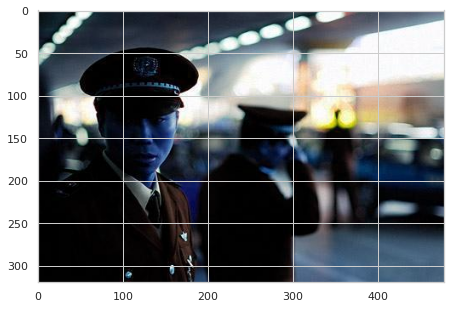

In [40]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')
plt.imshow(img)

In [41]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)

In [42]:
np.asarray(result).max()

1

/home/user/workspace/github/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

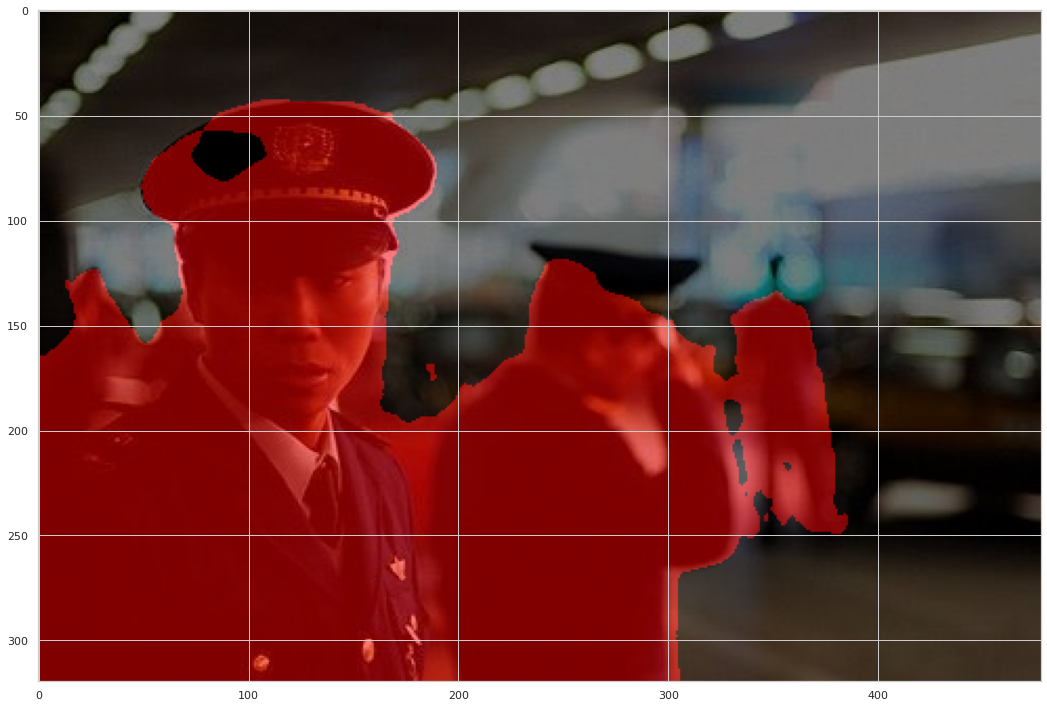

In [43]:
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

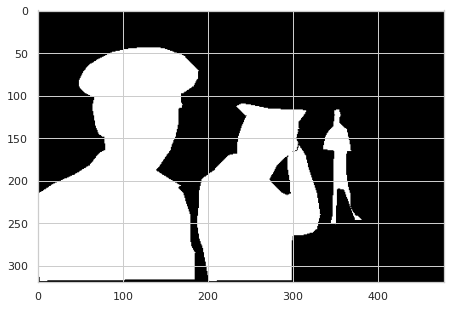

In [45]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/binary-labels/validation/ADE_val_00000011.png')
img[img == 1] = 255
plt.imshow(img, cmap="gray")

In [46]:
img.max()

255

In [47]:
img.min()

0

In [48]:
# print('show video')
# test a video and show the results
video = mmcv.VideoReader('../data/ramp.mp4')

In [49]:
import time

In [50]:
video[1].shape

(1080, 1920, 3)

In [51]:
x = 100

In [52]:
%%time
start = time.time()

for frame in video[:x]: # time - how many frame per sec - metrics acc - IoU
    result = inference_segmentor(model, frame)
    #model.show_result(frame, result)

end = time.time()

CPU times: user 14 s, sys: 590 ms, total: 14.6 s
Wall time: 4.76 s


In [53]:
from humanfriendly import format_timespan
aux0 = (end-start)
print("Time:", format_timespan(aux0))
aux1 = aux0/x
print("Time/frame:", format_timespan(aux1))
print("FPS: ", 1/aux1)

Time: 4.76 seconds
Time/frame: 0.05 seconds
FPS:  21.023038005785075


In [54]:
# display the training loss changes
